# Quantitative Trading and Analysis with Python: Course Project

Submitted by:

Jiawei Li (XXX)  
Sebastian Sydow (8316620)  
Strahinja Trenkic (1963)  
Xiaoyi Zhou (XXX)  

Date: 30th March 2022

# Introduction

In this notebook, we created several functions, which perform the necessary (sub-)steps for the given task. This allowed us to easily reproduce results or change certain parameters. Please refer to the docstrings at the beginning of and the comments within the functions for further explanations. 

**Note:** Some of the explanations or quality checks in this notebook might seem too exhaustive or dispensable for the given task. Nevertheless, these explanations and quality checks were added as they facilitated in the process of understanding the concepts and shall serve as a future point of reference for us. Moreover, this notebook used some of the code provided during the lectures of the course *Quantitative Trading and Analysis with Python* (M.Sc.) at the Frankfurt School of Finance and Management.

# Preliminaries

In [1]:
import datetime
import time
import warnings
from pathlib import Path

from matplotlib.axis import Axis
from matplotlib.pyplot import figure
from pandas.tseries.offsets import BDay
from scipy import stats
from scipy.optimize import minimize
from scipy.stats.mstats import winsorize
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from statsmodels.regression.rolling import RollingOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import quandl as quandl
import quantstats as qs
import seaborn as sns
import statsmodels.api as sm
import ta as ta
import wrds as wrds

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = "retina"

# Data Preperations

In the next cell, the data of different data sources is loaded and preprocessed. The data for the generalized lower bounds for the expected excess simple returns (`df_glb`) and  risk-neutral skewness (`df_mfis`) were provided by [Grigory Vilkov](https://www.vilkov.net/index.html) and retrieved from [here](https://osf.io/z2486/).

In [6]:
# WRDS username
wrds_username = "strahinja23"
# define the path to data folder
path = Path(r"\Users\Strahinja\Desktop\books_Germany\Quant\Group_Project")
# stocks
input_stocks = path / "permno_selection.csv"
# link betweeen CRSP (permno) and Option Metrics (SECID)
link_permno_secid = path / "daily_permno_secid_cusip_link.csv.zip"
# glb
glb = path / "glb_daily.csv"
# model-free implied skewness (MFIS)
#mfis = path / "MFIS_1996_2019.csv"
mfis = path / "mfis.csv"
# Save a hdf locally for easier modeling
hdf_path = path / "factors.h5"
# quandl key
quandl_key = "XWVLTpJSLyiA8s66Fh8x"
# import stock universe
df_input_stocks = pd.read_csv(input_stocks)
# glb
df_glb = pd.read_csv(glb)
# rename column
df_glb = df_glb.rename(columns={"id": "permno"})
# transfrom data type
df_glb["date"] = pd.to_datetime(df_glb["date"])
# mfis
df_mfis = pd.read_csv(mfis)
# rename column
df_mfis = df_mfis.rename(columns={"id": "permno"})
# transfrom data type
df_mfis["date"] = pd.to_datetime(df_mfis["date"])
# instantiate zip-file
zip_file = ZipFile(link_permno_secid)
# load linking table
df_link_permno_secid = pd.read_csv(zip_file.open("daily_permno_secid_cusip_link.csv"))

## Stock Returns and Market Capitalization
In the next cell, we created a function to retrieve the daily stock returns, daily stock prices and daily shares outstanding for the companies in `df_input_stocks`.

In [7]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    """
    This function retrieves the permno, cusip return, price, shares outstanding and market value of each stock
    on each day.
    
    Parameters
    ----------
    df_input: dataframe
        The dataframe storing the information about the stocks.
        
    date_start: str
        First date of data retrieval.
        
    date_end: str
        Last date of data retrieval.
    
    wrds_username: str
        Username of the wrds-account used for the data retrieval.
        
    Returns
    -------
    This functions returns the information for each stock on each day 
    as well as the weightage of each stock on each day by market value in a dataframe. 
    """
    
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            order by date
            """

    # define the parameters
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date').sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True) 
    db.close()
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

## Fama-French Factors
In the next cell, we created a function to download the data for the four-factor model (daily) from the Ken French data library.

In [8]:
def download_ffm(date_start, date_end):
    """
    This function download the data for the four-factor model (daily) from the Ken French data library.

    Parameters
    ----------
    date_start: str
        First date of data retrieval.
        
    date_end: str
        Last date of data retrieval.
    
    Returns
    -------
    This functions returns the data for the four-factor model (daily) from the Ken French data library
    in a dataframe. 
    """
    
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

## Quandl Data

In the next cell, we created a function to download data from quandl, among others:

**Crude Oil Prices**
- [WTI Spot Price](https://data.nasdaq.com/data/EIA/PET_RWTC_D-cushing-ok-wti-spot-price-fob-daily)

**Treasury Yields**
- [US Treasury Yields](https://data.nasdaq.com/data/USTREASURY/YIELD-treasury-yield-curve-rates)

**Gold**
- [LBMA/GOLD](https://data.nasdaq.com/data/LBMA/GOLD-gold-price-london-fixing)


In [9]:
def get_quandl_data(quandl_key):
    """
    This function download the data from quandl, which can later be utilized to construct factors.

    Parameters
    ----------
    quandl_key: path
        Path to an excel-file, which stores the quandl-key in the first cell.
    
    Returns
    -------
    This functions returns three dataframes: 
    - Daily WTI Spot Prices
    - Daily yield difference between 10year yield and 1year yield of US treasuries
    - Daily price of gold
    """
    
    # configure quandl
    quandl.ApiConfig.api_key = quandl_key
    
    # Crude Oil
    df_crude_oil = quandl.get("EIA/PET_RWTC_D")
    # calculate daily returns
    df_crude_oil = df_crude_oil.pct_change(1)
    # reset_index
    df_crude_oil.reset_index(inplace=True)
    # rename column
    df_crude_oil.rename(columns={"Value": "ret_crude_oil", "Date": "date"}, inplace=True)
    
    # Treasury Yields
    df_treasury_yield = quandl.get("USTREASURY/YIELD")
    # drop columns
    df_treasury_yield.drop(labels=['1 MO', '2 MO', '3 MO', '6 MO', '2 YR', '3 YR', '5 YR', '7 YR', '20 YR', '30 YR'], axis=1, inplace=True)
    # calculate difference between 10year yield and 1year yield
    df_treasury_yield['yield_dif_10y_1y'] = df_treasury_yield['10 YR'] - df_treasury_yield['1 YR']
    # drop columns
    df_treasury_yield.drop(labels=['1 YR', '10 YR'], axis=1, inplace=True)
    # reset_index
    df_treasury_yield.reset_index(inplace=True)
    # rename column
    df_treasury_yield.rename(columns={"Date": "date"}, inplace=True)
    
    # Gold
    df_gold = quandl.get("LBMA/GOLD")
    # drop columns
    df_gold.drop(labels=['USD (PM)','GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
    # calculate daily returns
    df_gold = df_gold.pct_change(1)
    # reset_index
    df_gold.reset_index(inplace=True)
    # rename column
    df_gold.rename(columns={"USD (AM)": "ret_gold", "Date": "date"}, inplace=True)
    
    return df_crude_oil, df_treasury_yield, df_gold

## Exchange Rate

Data about exchange rates were retrieved from the St. Louis FED with the function `get_fx_data`.
- [Exchange Rates ST. Louis FRED](https://fred.stlouisfed.org/categories/15)
- [Nominal Emerging Market Economies U.S. Dollar Index](https://fred.stlouisfed.org/series/DTWEXEMEGS), only available from 2006 onwards
- [Real Emerging Market Economies Dollar Index](https://fred.stlouisfed.org/series/RTWEXEMEGS), only available from 2006 onwards

In [10]:
def get_fx_data(symbol, start_date):
    """
    This function downloads the data about exchange rates from the ST. Louis FED.

    Parameters
    ----------
    symbol: symbol
        Identifier of the data provided by the St. Louis FED.
        
    start_date: datetime
        First date of data retrieval.
    
    Returns
    -------
    This functions returns the dataframe with the daily returns of the forex data. 
    """
    # get data
    df_fx = web.DataReader(symbol, 'fred', start_date)
    # calculate daily returns
    df_fx = df_fx.pct_change(1)
    # reset index
    df_fx.reset_index(inplace=True)
    # rename
    df_fx.rename(columns={'DATE': 'date', symbol: 'fx_rates'}, inplace=True)
    
    return df_fx

## Calculate Excess Return

In [11]:
def calc_excess_return(df, minuend, subtrahend):
    """
    This function calculates the excess return.

    Parameters
    ----------
    df: dataframe
        Identifier of the data provided by the St. Louis FED.

    minuend: str
        Column storing data about the minuend.

    subtrahend: str
        Column storing data about the subtrahend.

    Returns
    -------
    This functions returns the dataframe with an additional column for the excess return.
    """
    # calculate excess return
    df["excess_return"] = df[minuend] - df[subtrahend]
    return df


## Perfrom Data Preparation 

In [12]:
def data_prep(
    df_input,
    date_start,
    date_end,
    df_link,
    wrds_username,
    minuend,
    subtrahend,
    quandl_key,
):
    """
    This function calls the previously created functions to load and pre-process the data.

    Parameters
    ----------
    df_input: dataframe
        The dataframe storing the information about the stocks.

    date_start: str
        First date of data retrieval.

    date_end: str
        Last date of data retrieval.

    df_link: dataframe
        The dataframe storing the mapping between CRSP [permno] and OptionMetrics [secid] identifiers.

    wrds_username: str
        Username of the wrds-account used for the data retrieval.

    minuend: str
        Column storing data about the minuend.

    subtrahend: str
        Column storing data about the subtrahend.

    quandl_key: path
        Path to an excel-file, which stores the quandl-key in the first cell.

    Returns
    -------
    This functions returns the downloaded and pre-processed data as a dataframe.
    """
    # retrieve data
    df_stock_data = retrieve_stock_data(
        df_input=df_input,
        date_start=date_start,
        date_end=date_end,
        wrds_username=wrds_username,
    )

    # change type of entries in the columns date
    df_link["date"] = pd.to_datetime(df_link["date"])
    # merge with cusip
    df_stock_data = pd.merge(
        df_stock_data,
        df_link.loc[:, ["permno", "date", "secid"]],
        how="left",
        on=["permno", "date"],
    )
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    # merge stock data with ffm
    df_stocks_factors = pd.merge(df_stock_data, df_ffm, how="inner", on=["date"])
    # calculate excess return
    df_stocks_factors = calc_excess_return(
        df=df_stocks_factors, minuend=minuend, subtrahend=subtrahend
    )
    # get quandl data
    df_crude, df_yields, df_gold = get_quandl_data(quandl_key=quandl_key)
    # merge with stock data
    df_stocks_factors = pd.merge(df_stocks_factors, df_crude, how="left", on=["date"])
    df_stocks_factors = pd.merge(df_stocks_factors, df_yields, how="left", on=["date"])
    df_stocks_factors = pd.merge(df_stocks_factors, df_gold, how="left", on=["date"])

    return df_stocks_factors


In the next cell, we call the function `data_prep` to download, pre-process and merge the data.

In [13]:
df_prepared = data_prep(
    df_input=df_input_stocks,
    date_start="1999-01-01",
    date_end="2019-12-31",
    df_link=df_link_permno_secid,
    wrds_username=wrds_username,
    minuend="ret",
    subtrahend="rf",
    quandl_key=quandl_key,
)

Loading library list...
Done


## Estimation of $\beta$-Factors

In [14]:
def estimate_betas(df, window_size, factors, period="daily"):
    """
    This function calls the previously estimates the beta-factors for those characteristics,
    which are not directly observable for each stock.

    Parameters
    ----------
    df_input: dataframe
        The dataframe storing the information about the stocks.

    windo_size: int
        The window for whcich the betas shall be estimated.

    factors: list
        List of factors, for which betas need to be estimated.

    period: str
        The period of recalculating the betas, (daily or monthly).

    Returns
    -------
    This functions returns dataframe with etimated betas, which are unique for each stock.
    """
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df["permno"] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno["excess_return"]
            # independent variable
            X = df_current_permno[factors]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    for col in factors:
        df_params.rename(columns={col: col + str("_beta")}, inplace=True)
    # df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print("Merging the dataframes...")
    df_betas = pd.merge(
        df,
        df_params,
        how="left",
        left_index=True,
        right_index=True,
        suffixes=[None, None],
    )
    print("Merging completed.")

    if period == "daily":
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas

    if period == "monthly":
        # add '_factor' to the entries in list factors
        ls_factors_betas = [
            factors[i] + str("_beta") for i in list(range(len(factors)))
        ]
        # create a temporary copy of df_betas
        cols2copy = ["permno", "date", "const"] + ls_factors_betas
        df_temp = df_betas[cols2copy].copy()
        # df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp["year"] = df_temp["date"].dt.year
        df_temp["month"] = df_temp["date"].dt.month
        # group dataframe and select last row
        df_temp = df_temp.groupby(["permno", "year", "month"]).tail(n=1)

        # rename columns to indicate that those are the betas of the end of each month
        for col in cols2copy[2:]:
            df_temp.rename(columns={col: col + str("_eom")}, inplace=True)
        # df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_betas
        df_betas_monthly = pd.merge(
            df_betas, df_temp, how="left", on=["date", "permno"]
        )
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby("permno")
        cols_eom = cols2copy[2:]
        cols_eom = [cols_eom[i] + str("_eom") for i in list(range(len(cols_eom)))]
        for var in cols_eom:
            df_betas_monthly[var] = gb[var].ffill()

        # drop daily betas
        # df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)
        df_betas_monthly.drop(
            ["const", "year", "month"] + ls_factors_betas + factors,
            axis=1,
            inplace=True,
        )
        # drop nas
        df_betas_monthly.dropna(inplace=True)

        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)

        return df_betas_monthly

In [15]:
factors = [
    "mktrf",
    "smb",
    "hml",
    "mom",
    "ret_crude_oil",
    "yield_dif_10y_1y",
    "ret_gold",
]

df_betas = estimate_betas(
    df=df_prepared, window_size=252, factors=factors, period="monthly"
)

100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


Merging the dataframes...
Merging completed.


## Plot Benchmark Return

In [16]:
def weighted_avg(df, values, weights):
    """
    Calculate the valued weighted average.
    """
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [17]:
def plot_benchmark_performance(df, column_ret, column_weight):
    # calculate benchmark performance on each day
    df_plot = df.groupby(["date"]).apply(weighted_avg, column_ret, column_weight) + 1
    df_plot.iloc[0] = df_plot.iloc[0] * 100

    # size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # define the spacing on the x-axis
    ## major ticks every 4 years
    major_ticks_years = mdates.YearLocator(4)
    Axis.set_major_locator(ax.xaxis, major_ticks_years)
    ## Minor ticks every year
    minor_ticks_year = mdates.YearLocator(1)
    Axis.set_minor_locator(ax.xaxis, minor_ticks_year)

    # title
    plt.title(r"Value-Weighted Excess-Return of the Benchmark-Portfolio")

    # format the date type to year on the x-axis
    ax.format_xdata = mdates.DateFormatter("% m")

    # 9/11
    ax.annotate(
        "9/11",
        xy=("2001-09-11 00:00:00", 120),
        xytext=(15, 15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )
    ax.axvline(x=pd.to_datetime("2001-09-11"), color="r", linestyle="--", lw=1)

    # bankruptcy Lehman
    ax.annotate(
        "Bankruptcy Lehman Brothers",
        xy=("2008-09-15 00:00:00", 90),
        xytext=(15, 15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )
    ax.axvline(x=pd.to_datetime("2008-09-15"), color="r", linestyle="--", lw=1)

    # covid
    ax.annotate(
        "Covid-19",
        xy=("2020-03-16 00:00:00", 350),
        xytext=(-60, 5),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>"),
    )
    ax.axvline(x=pd.to_datetime("2020-03-16"), color="r", linestyle="--", lw=1)

    # define start and end of x-axis
    ax.set_xlim(min(df["date"]), max(df["date"]))

    # define labels of x- and y-axis
    ax.set(
        xlabel="Date",
        ylabel="Performance in % (Value-Weighted Mean of Benchmark Portfolio)",
    )

    ax.plot(df_plot.cumprod(), label="Excess Return Benchmark")
    ax.legend(loc="upper left")

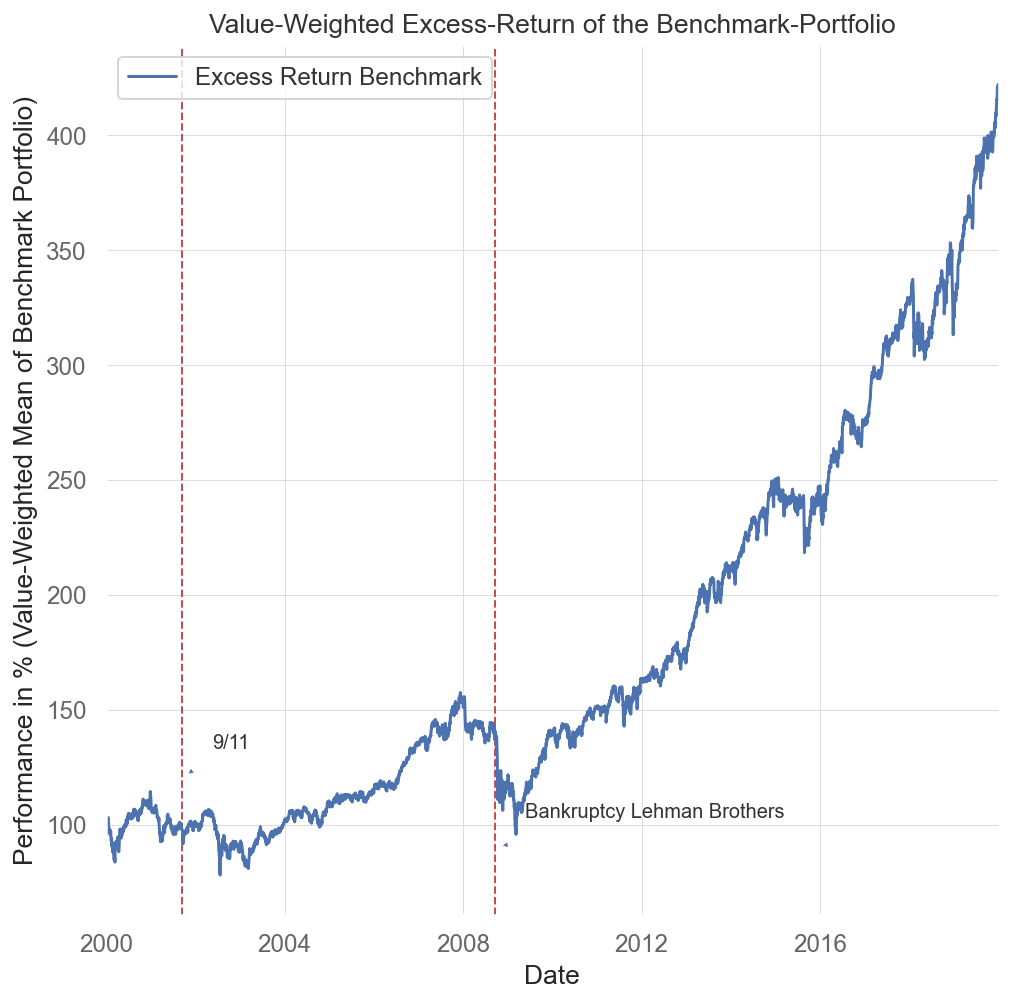

In [18]:
plot_benchmark_performance(df=df_betas, column_ret="ret", column_weight="weightage_pct")

## Option-Implied Data

### GLB and MFIS

In the next cell, the data for the generalized lower bounds for the expected excess simple returns (`df_glb`) and  risk-neutral skewness (`df_mfis`) are added.

In [19]:
# merge data with glb
df_stocks_betas_options = pd.merge(df_betas, df_glb, how="left", on=['permno', 'date'])
# merge data with mfis
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_mfis, how='left', on=['permno', 'date'])

### Average Volatility and SKEW

In [20]:
def retrieve_option_metrics(
    df,
    start_year,
    end_year,
    days,
    delta_otm_put,
    delta_atm_call,
    delta_otm_put2,
    delta_atm_call2,
    wrds_username,
):

    """
    This function retrieves the option metrics from WRDS.

    Parameters
    ----------
    df: dataframe
        The dataframe storing the information about the stocks.

    start_year: int
        First year of data retrieval.

    end_year: int
        Last year of data retrieval.

    days: int
        Number of days used for calulating the metrics.

    delta_otm_put: int
        Used for calculating skew, OTM put (delta)

    delta_atm_call: int
        Used for calculating skew, ATM put (delta)

    delta_otm_put2: int
        Used for calculating skew2, OTM put (delta)

    delta_atm_call2: int
        Used for calculating skew2, ATM put (delta)

    wrds_username: str
        Username of the wrds-account used for the data retrieval.

    Returns
    -------
    This functions returns the downloaded option metrics as a dataframe.
    """

    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)

    # define the parameters
    params = {}
    params["secids"] = tuple(df.secid.unique())
    params["days"] = days
    params["delta_otm_put"] = delta_otm_put
    params["delta_atm_call"] = delta_atm_call
    params["delta_otm_put2"] = delta_otm_put2
    params["delta_atm_call2"] = delta_atm_call2

    # define the sql query
    sql = """
    select a.date, a.secid, a.iv-b.iv as skew1, c.iv, (g.iv-v.iv)/a.iv as skew2 from 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call)s) as a, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put)s) as b, 

    (select date, secid, AVG(impl_volatility) as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and abs(delta)<=%(delta_atm_call)s
    group by date, secid) as c,
    
    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put2)s) as g, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call2)s) as v

    where a.date= b.date and a.secid = b.secid 
    and a.date = c.date and a.secid = c.secid
    and a.date = g.date and a.secid = g.secid
    and a.date = v.date and a.secid = v.secid
    """
    # retrieve data for 1999
    params["year"] = start_year
    df_optiondata = db.raw_sql(sql, params=params)

    # append data for each year from 2000 to 2020
    for y in tqdm(range(start_year + 1, end_year)):
        # print('Processing year ', y)
        # set parameter for the year
        params["year"] = y
        df_optiondata = pd.concat([df_optiondata, db.raw_sql(sql, params=params)])
    db.close()
    return df_optiondata

In [21]:
df_option_metrics = retrieve_option_metrics(
    df=df_stocks_betas_options,
    start_year=1999,
    end_year=2020,
    days=30,
    delta_otm_put=-10,
    delta_atm_call=50,
    delta_otm_put2=-25,
    delta_atm_call2=25,
    wrds_username=wrds_username,
)

# change type of entries in the column data
df_option_metrics.loc[:, "date"] = pd.to_datetime(df_option_metrics.loc[:, "date"])

# merge optiondata and stockdata
df_stocks_betas_options = pd.merge(
    df_stocks_betas_options, df_option_metrics, how="left", on=["secid", "date"]
)

Loading library list...
Done


100%|██████████| 20/20 [02:31<00:00,  7.58s/it]


### Variance Risk Premium

In [22]:
def get_vrp(wrds_username, df_stocks_betas_options):
    db = wrds.Connection(wrds_username=wrds_username)

    sql = """
    select a.date,a.secid,a.return
    from optionm.secprd%(year)s as a
    where secid in %(secids)s
    """
    params = {}
    params["secids"] = tuple(df_stocks_betas_options.secid.unique())
    params["year"] = 1999
    options_returns = db.raw_sql(sql, params=params)

    for y in tqdm(range(2000, 2020)):
        params["year"] = y
        options_returns = pd.concat([options_returns, db.raw_sql(sql, params=params)])

    options_returns.loc[:, "date"] = pd.to_datetime(options_returns.loc[:, "date"])
    options_returns = options_returns.rename(columns={"return": "option_returns"})
    options_returns = options_returns.set_index("date")

    temp1 = (
        options_returns.groupby(by=["secid"])["option_returns"].rolling(window=21).var()
        * 252
    )
    temp1.name = "realized_variance"
    temp1 = temp1.reset_index()
    db.close()

    df_stocks_betas_options = df_stocks_betas_options.merge(
        temp1, how="left", on=["date", "secid"]
    )
    df_stocks_betas_options.loc[:, "vrp"] = (
        df_stocks_betas_options.loc[:, "iv"] ** 2
    ).rolling(21).sum() / (df_stocks_betas_options.loc[:, "realized_variance"]).rolling(
        21
    ).sum()
    df_stocks_betas_options.drop(["realized_variance"], inplace=True, axis=1)

    df_stocks_betas_options.to_hdf(
        hdf_path, key="factors", mode="a", data_columns=True, complib="zlib"
    )
    return df_stocks_betas_options

## Technical Indicators

In [23]:
def technicals_rock(df_a):
    KAMA = KAMAIndicator(close = df_a["prc"],window = 10,pow1 = 2, pow2 = 30)
    PPO = PercentagePriceOscillator(close = df_a["prc"],window_slow = 26, window_fast = 12, window_sign = 9)
    ROCI = ROCIndicator(close=df_a["prc"],window=12)
    RSI = RSIIndicator(close=df_a["prc"],window = 14)
    EMA14 = EMAIndicator(close = df_a["prc"],window = 14)
    EMA25 = EMAIndicator(close = df_a["prc"],window = 25)
    MACD_ind = MACD(close = df_a["prc"],window_slow = 26,window_fast = 12,window_sign=9)
    Aroon = AroonIndicator(close = df_a["prc"],window = 25)
    
    df_a = df_a.assign(    
    KAMA = KAMA.kama(),
    PPO = PPO.ppo_signal(),
    ROCI = ROCI.roc(),
    RSI = RSI.rsi(),
    EMA14 = EMA14.ema_indicator(),
    EMA25 = EMA25.ema_indicator(),
    MACD = MACD_ind.macd_signal(),
    AroonInd = Aroon.aroon_indicator()
    )
    
    return df_a

In [24]:
df_stocks_betas_options = technicals_rock(df_stocks_betas_options)
df_stocks_betas_options = get_vrp(wrds_username, df_stocks_betas_options)

Loading library list...
Done


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


# Data Wrangling

## Delete Columns with Too Many Missing Values

In [25]:
def count_nan(df):
    """
    This function counts None values on each column plots the count as a bar-chart.

    Parameters
    ----------
    df_input: dataframe
        The dataframe with the columns for which the count of None values shall be plotted.

    Returns
    -------
    This functions returns the plotted None values as a bar-chart.
    """
    # Count NaN
    df_count_nan = df.isna().sum().reset_index(name="Count NaN")
    # Rename column
    df_count_nan = df_count_nan.rename(columns={"index": "Column"})
    # Plot
    df_count_nan.plot.bar(
        x="Column", y="Count NaN", rot=45, figsize=(16, 6), title="Count NaN per Column"
    )

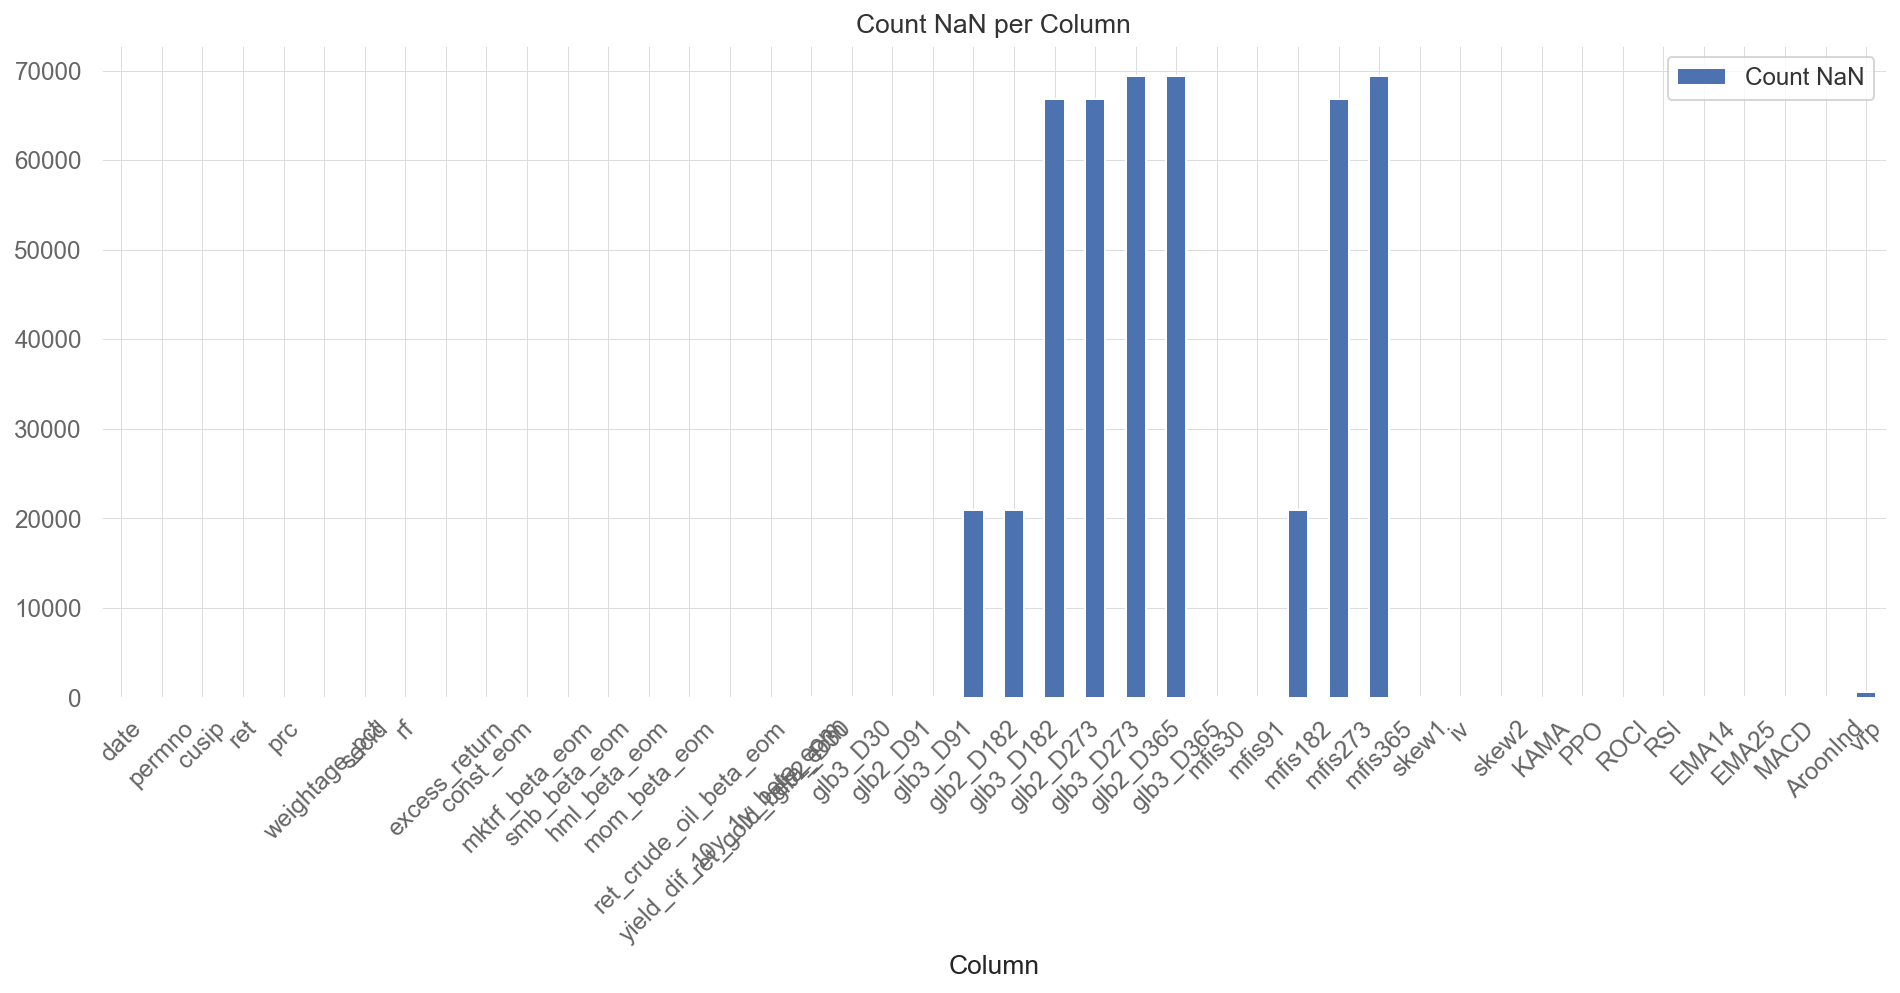

In [26]:
count_nan(df=df_stocks_betas_options)

In [27]:
# drop columns with many nas
df_stocks_betas_options.drop(
    [
        "glb2_D182",
        "glb3_D182",
        "glb2_D273",
        "glb3_D273",
        "glb2_D365",
        "glb3_D365",
        "mfis182",
        "mfis273",
        "mfis365",
    ],
    inplace=True,
    axis=1,
)

## Multicollinearity
Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves (see also [here](https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/) and [here](https://www.investopedia.com/terms/m/multicollinearity.asp)). This may lead to difficulties, when trying to distinguis between their individual effects on the dependent variable. <br> 
In statistics, one commone approach to quantify a relationship between two variables is to the [Pearson correlation coefficient](https://www.statology.org/pearson-correlation-coefficient/), which is a measure of the linear association between two variables. It has a value between -1 and 1 where:
- -1 indicates a perfectly negative linear correlation between two variables
- 0 indicates no linear correlation between two variables
- 1 indicates a perfectly positive linear correlation between two variables

The further away the Pearson correlation coefficient is away from zero, the stronger the relationship between the two variables.
The pairwise Pearson correlation coefficient of the respective variables can be clearly visualized using the correlation matrix as a heatmap.

In [28]:
def corrmatrix_heatmap(df, columns):
    """
    This function calculates the pairwise Pearson correlation coefficient of the respective variables
    and plots them in a heatmap.
    
    Parameters
    ----------
    df: dataframe
        The dataframe storing the information about the stocks.
        
    columns: list
        The variables for which the Pearson correlation coefficient shall be calculated.
        
    Returns
    -------
    This functions returns the heatmap of the pairwise Pearson correlation coefficient. 
    """
    
    X = df[columns]

    # Compute the correlation matrix
    corrMatrix = X.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 11))

    sns.heatmap(corrMatrix, annot=True)

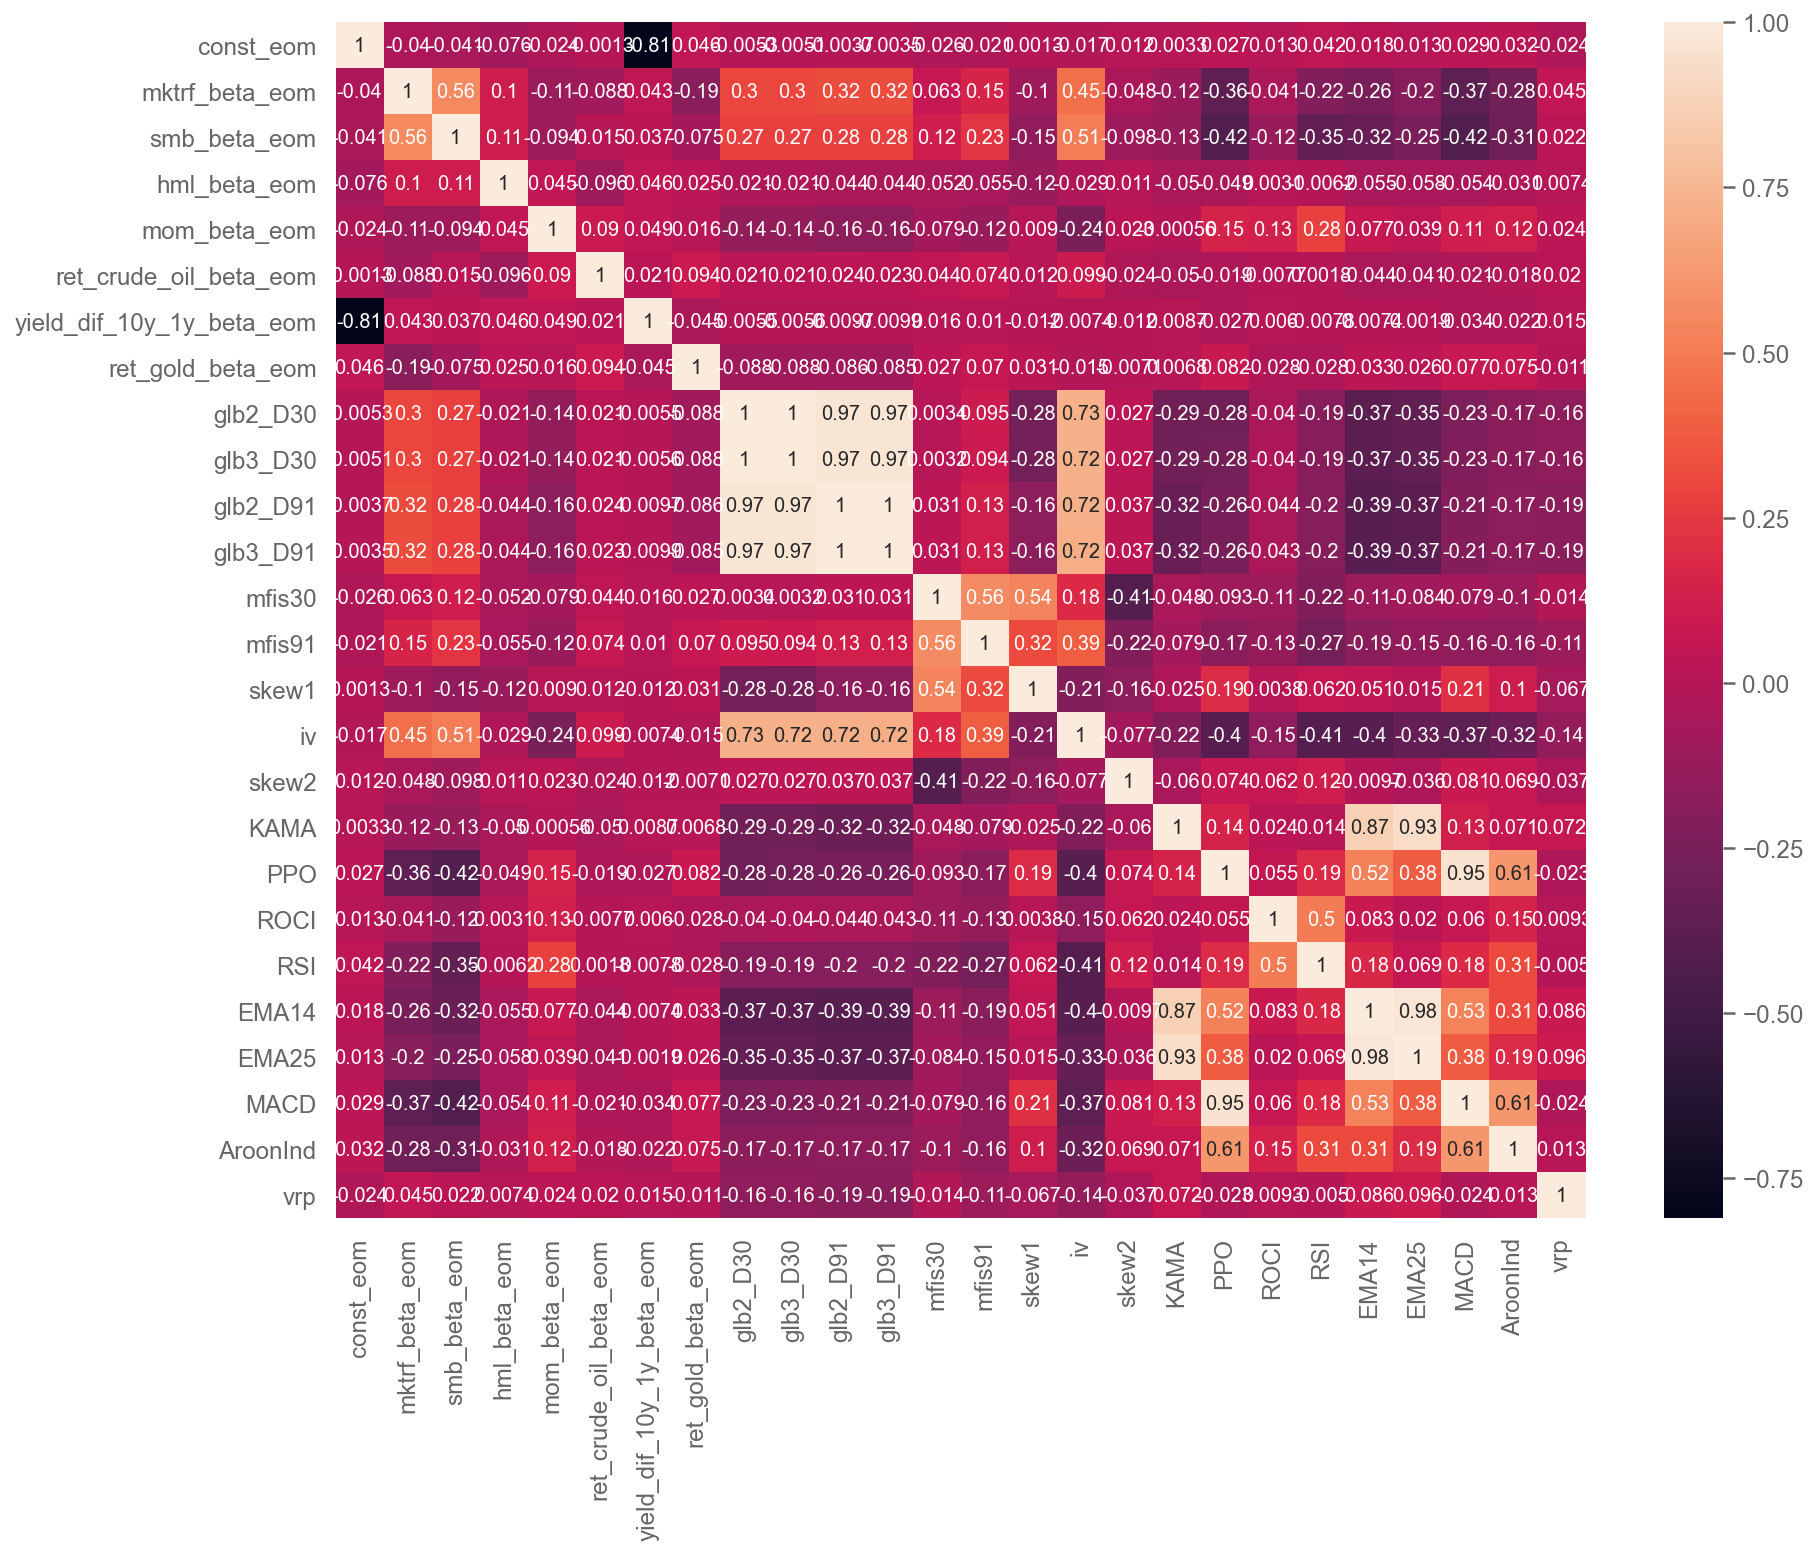

In [29]:
# define columns to calculate pearson correlation coefficient for
idx = list(df_stocks_betas_options.columns).index("excess_return")
columns = list(df_stocks_betas_options.columns)[idx+1:]

# execute function
corrmatrix_heatmap(df=df_stocks_betas_options, columns=columns)

In the next cells, we use the [variance inflation factor (VIF)](https://www.statsmodels.org/devel/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) to additionally measure the amount of collinearity. One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

In [30]:
def VIF_Features(df):
    """
    This function calculates the variance inflation factor (VIF).

    Parameters
    ----------
    df: dataframe
        The dataframe storing the information about the stocks.

    Returns
    -------
    This functions returns variance inflation factors.
    """

    X_ = df.copy()
    X_ = X_[X_.columns[10:]]
    X_ = X_.dropna()

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_.values, i) for i in range(len(X_.columns))
    ]

    return vif_data

In [31]:
# drop columns
df_stocks_betas_options.drop(
    ["glb2_D30", "glb2_D91", "glb3_D91", "mfis30", "EMA25", "EMA14", "KAMA"],
    inplace=True,
    axis=1,
)

In [32]:
dd = VIF_Features(df_stocks_betas_options)
dd

,feature,VIF
0,mktrf_beta_eom,9.258317
1,smb_beta_eom,1.907057
2,hml_beta_eom,1.060757
3,mom_beta_eom,1.143140
4,ret_crude_oil_beta_eom,1.077343
5,yield_dif_10y_1y_beta_eom,1.010883
6,ret_gold_beta_eom,1.079325
7,glb3_D30,4.095048
8,mfis91,5.631707
9,skew1,2.665618


## Split and Preprocessing 

In [33]:
def alpha_returns(df, kind):
    if kind == "Alpha":
        benchmark_returns = df.groupby(["date"])[["weightage_pct", "ret"]].apply(
            lambda x: np.nansum(x["ret"] * x["weightage_pct"])
        )
        benchmark_returns.name = "ret_benchmark"
        df = df.merge(benchmark_returns, on=["date"])
        df["ret_bm_fw"] = df.groupby(["permno"])["ret_benchmark"].shift(-1)
        df.loc[:, "fret1d"] = df.groupby(["permno"])["ret"].shift(-1)
        df["fret1d"] = df["fret1d"] - df["ret_bm_fw"]
        df.drop(columns={"ret_bm_fw", "ret_benchmark"}, inplace=True)
    if kind == "Regular":
        df.loc[:, "fret1d"] = df.groupby(["permno"])["ret"].shift(-1)
    return df

In [34]:
df_stocks_betas_options = alpha_returns(df_stocks_betas_options, kind="Regular")

In [35]:
def train_test_split_sorted(df, date_of_split, dates):

    date_of_split = pd.to_datetime(date_of_split)
    X_train = df[
        (df["date"] <= date_of_split) & (df["date"] > pd.datetime(1999, 12, 31))
    ]
    X_test = df[(df["date"] > date_of_split) & (df["date"] < pd.datetime(2020, 1, 1))]

    X_train = X_train.sort_values(by=["date", "permno"])
    X_test = X_test.sort_values(by=["date", "permno"])

    return X_train, X_test

In [36]:
def process(df, columns):
    df_scaled = df.copy()

    df_scaled = df_scaled.fillna(method="ffill", limit=30, inplace=False)
    df_scaled = df_scaled.dropna()

    for column in columns:
        df_scaled[column] = (df_scaled[column] - df_scaled[column].min())  / (df_scaled[column].max() - df_scaled[column].min())
        df_scaled[column], fitted_lambda = stats.boxcox(df_scaled[column] + 0.0001) 
        df_scaled.loc[:,column] = winsorize(df_scaled.loc[:,column], limits=0.01).data
        df_scaled[column] -= df_scaled[column].mean()
        
    return df_scaled


In [37]:
df_stocks_betas_options.loc[:, "date"] = pd.to_datetime(
    df_stocks_betas_options.loc[:, "date"]
)

train, test = train_test_split_sorted(
    df=df_stocks_betas_options,
    date_of_split=pd.datetime(2012, 12, 31),
    dates=df_stocks_betas_options.date,
)

columns2norm = train.columns[10:-1]

# Only the train gets processed, the rest will be processed on a rolling window in the testing phase
train = process(train, columns2norm)

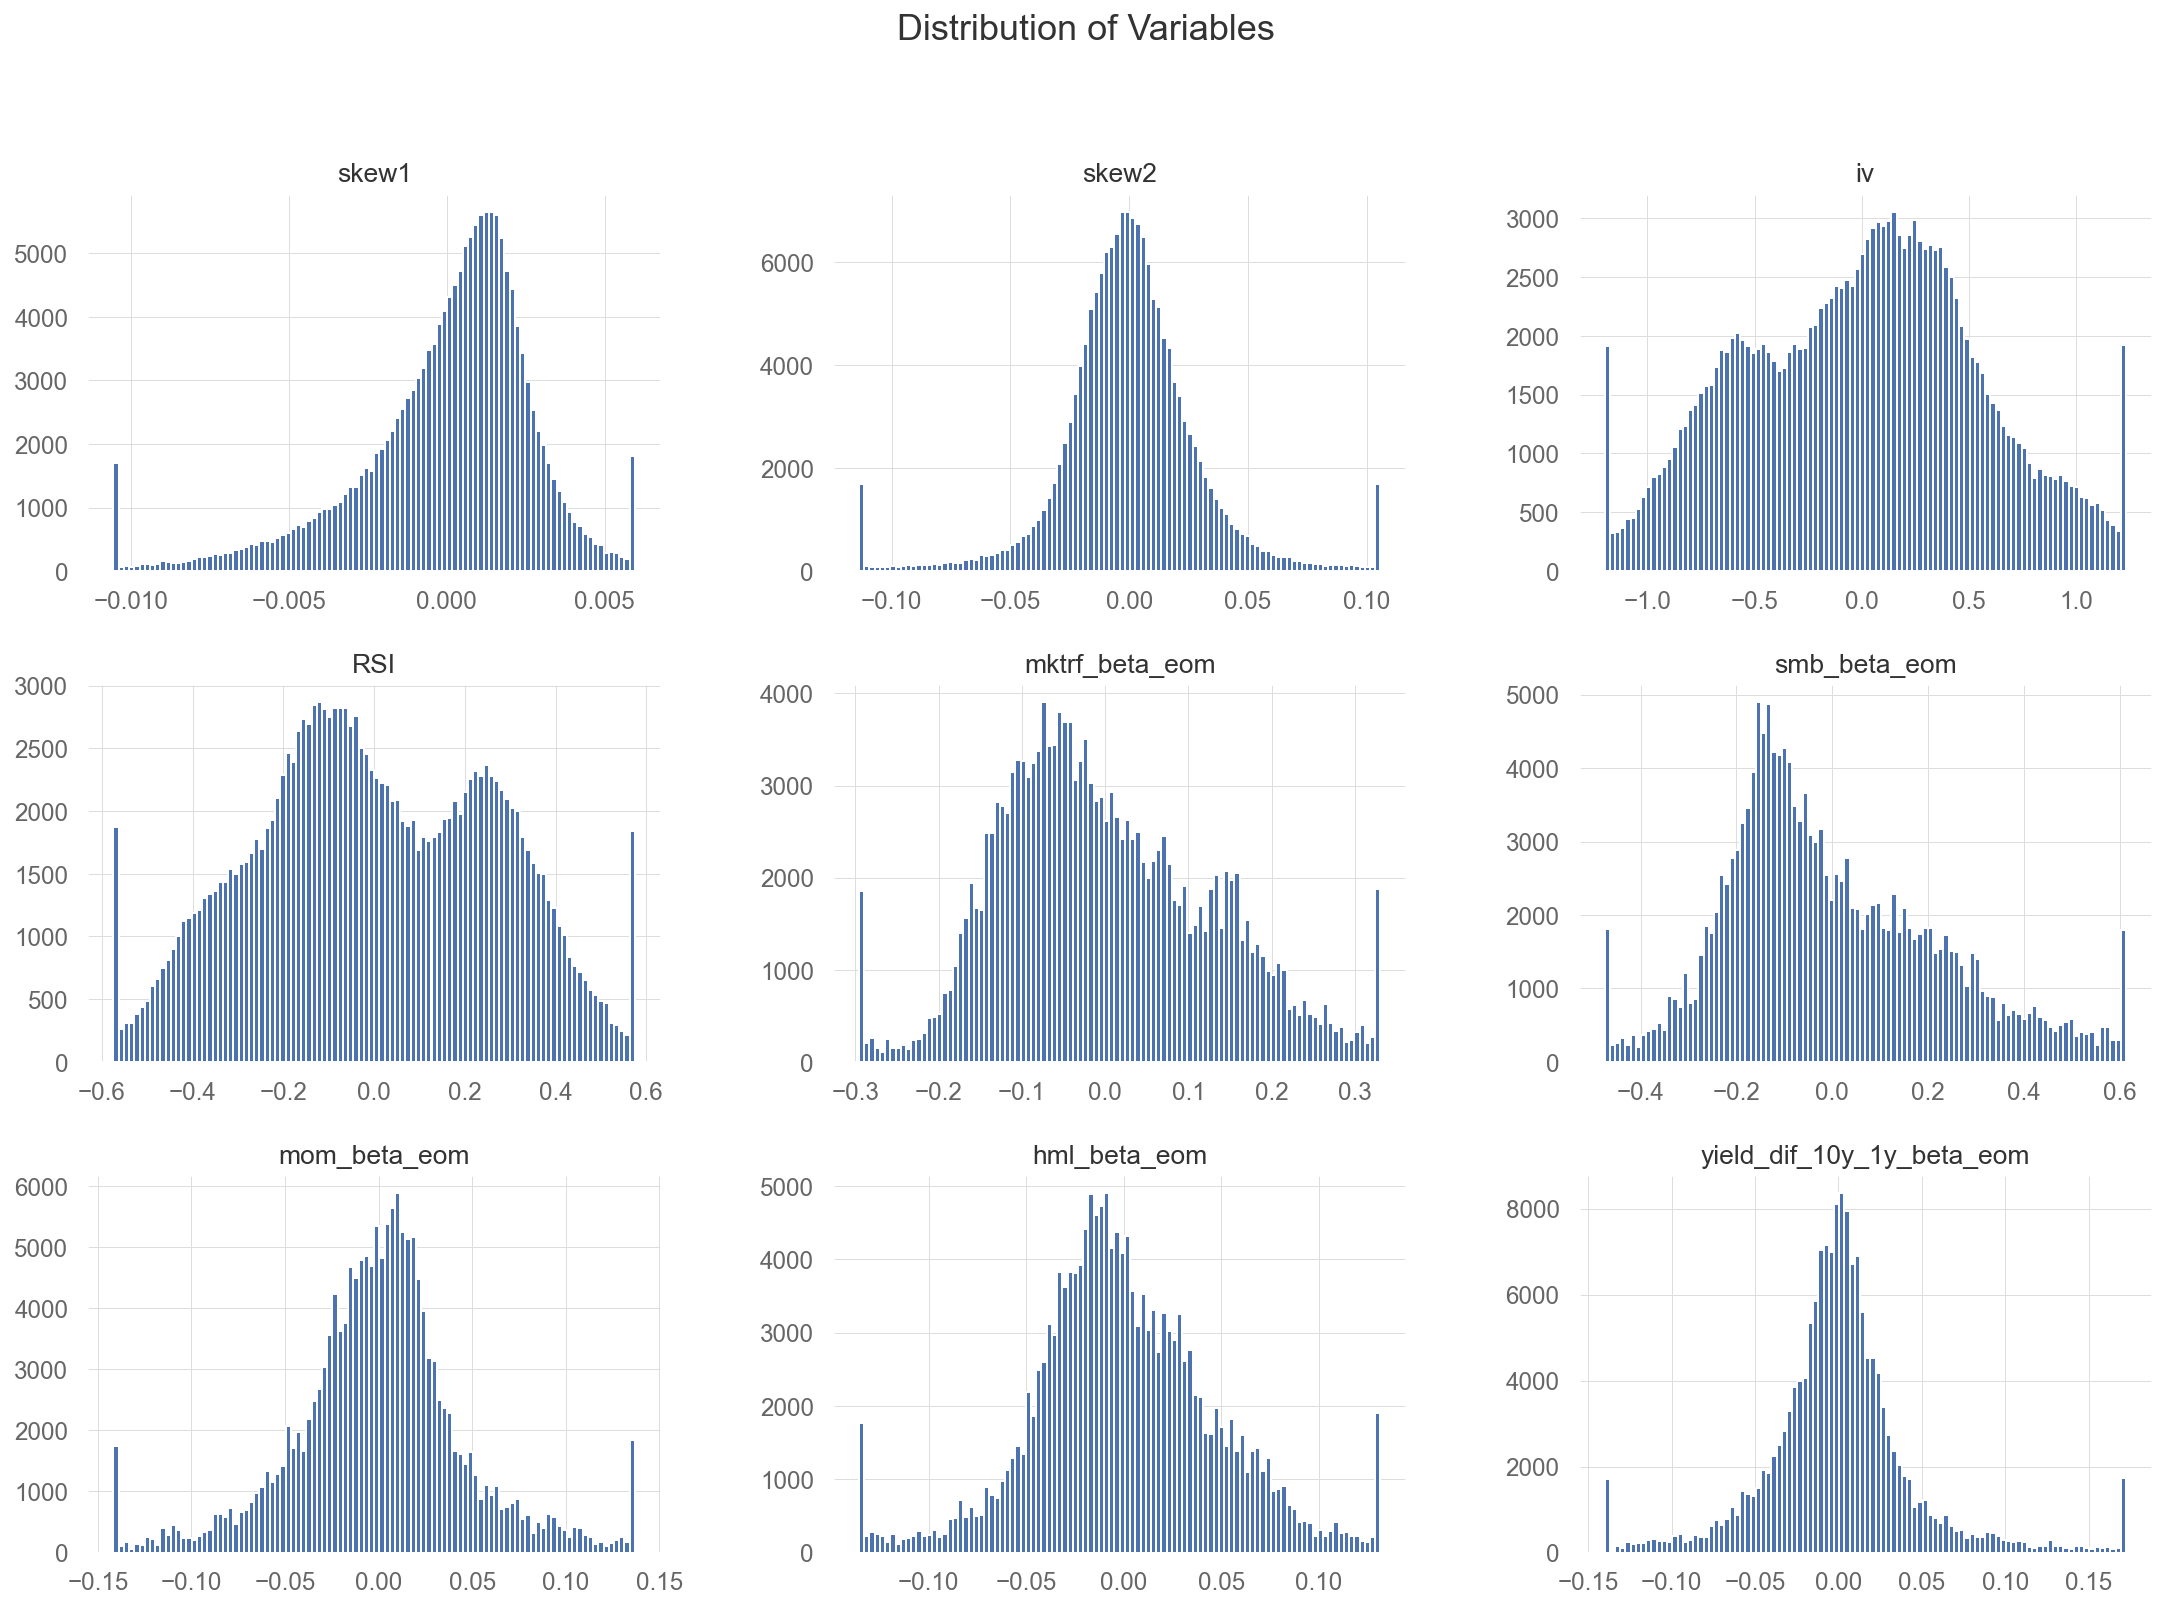

In [38]:
cols = [
    "skew1",
    "skew2",
    "iv",
    "RSI",
    "mktrf_beta_eom",
    "smb_beta_eom",
    "mom_beta_eom",
    "hml_beta_eom",
    "yield_dif_10y_1y_beta_eom",
] 
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(18.5, 12.5, forward=True)
fig.suptitle("Distribution of Variables", fontsize=18)

for i, el in enumerate(cols):
    a = train.hist(el, ax=axs.flatten()[i], bins=100)

# Models

## Random Forest

In [39]:
def rolling_forest(data, predictors, target, window, params):
    # First we form the window
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

    # Auxiliary placeholders and reg. constant
    data = data.sort_values(by=["date", "permno"])
    predictions_df = pd.DataFrame(
        index=[pred_date], columns=np.sort(data.permno.unique())
    )
    scores = []
    missing_dates = []

    # The train / predict loop
    while pred_date <= data.date.max():
        # The loop will go through business days, not necessarily trading days (hence the try clause).
        try:
            # Picking the window of data to train and instantiating the predictor model
            mask = (data["date"] >= start_window) & (data["date"] <= end_window)
            train_window = data[mask].set_index("permno")
            linreg = RandomForestRegressor(**params)
            # Fitting the model on the training window
            fit_ = linreg.fit(train_window[list(predictors)], train_window[target])
            # Predicting for each permno on the next day after fit
            predi_df = (
                data[data["date"] == pred_date]
                .loc[:, list(predictors) + ["permno"]]
                .set_index("permno")
            )
            predi = fit_.predict(predi_df)
            # Storing in a useful format for backtest
            one_predi = (
                pd.DataFrame(data=predi, index=predi_df.index, columns=[pred_date])
            ).T
            predictions_df = pd.concat(
                [predictions_df, one_predi], axis=0, ignore_index=False
            )
            # R^2 to help visualize training performance
            score_r2 = linreg.score(
                predi_df[list(predictors)], data[data["date"] == pred_date][target]
            )
            scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
        # Update window position
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
    # Real returns we will need
    real_returns = data.pivot(index="date", columns="permno", values="fret1d")

    return real_returns, predictions_df[1:], missing_dates, scores  # , r2_average

In [40]:
%%capture

params = {
    "n_estimators": [10, 20, 30],
    "max_features": ["sqrt", "auto", "log2"],
    "max_depth": [3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
    "min_samples_split": [2, 3, 4, 5],
}

train.insert(10, "constant", 1.0)
regressors = train.columns[10:-1]
target = ["fret1d"]

forest = RandomForestRegressor()

folds = 3
param_comb = 5

random_search = RandomizedSearchCV(
    forest,
    param_distributions=params,
    n_iter=param_comb,
    scoring="r2",
    n_jobs=4,
    cv=KFold(5),
    verbose=3,
    random_state=1001,
)
random_search.fit(train[regressors], train[target])

In [41]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=4, n_estimators=10)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
-1.0024181706527995

 Best hyperparameters:
{'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 4}


In [42]:
params_forest = {
    "n_estimators": 30,
    "max_features": "sqrt",
    "max_depth": 5,
    "min_samples_leaf": 3,
    "min_samples_split": 4,
    "random_state": 1001,
}

regressors = train.columns[10:-1]
target = ["fret1d"]

(
    real_returns_forest,
    expected_returns_forest,
    missing_dates_forest,
    scores_forest,
) = rolling_forest(
    data=train, predictors=regressors, target=target, window=126, params=params_forest
)

## Lasso

We will tune the alpha on the whole train set and then again apply a rolling approach to predict.

In [43]:
def lasso_regression(data, predictors, target, alpha):
    lasso = Lasso(alpha=alpha,normalize=True, max_iter=1e5).fit(data[predictors],data[target])
    predi = lasso.predict(data[predictors]) 
    score=lasso.score(data[predictors],data[target])
    n = np.sum(lasso.coef_!=0)
    mse=metrics.mean_squared_error(data[target].to_numpy(), predi)
    
    return mse, score,n

In [44]:
alpha_lasso = [1e-16, 1e-8, 1e-4, 1e-2, 1, 10]
res = pd.DataFrame(index=alpha_lasso, columns=["MSE"])
for i in range(len(alpha_lasso)):
    (
        res.loc[alpha_lasso[i], "MSE"],
        res.loc[alpha_lasso[i], "Score"],
        res.loc[alpha_lasso[i], "No."],
    ) = lasso_regression(train, regressors, target, alpha_lasso[i])

In [45]:
def rolling_lasso(data, predictors, target, window, alpha):

    # First we form the window
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

    # Auxiliary placeholders and reg. constant
    data = data.sort_values(by=["date", "permno"])
    predictions_df = pd.DataFrame(
        index=[pred_date], columns=np.sort(data.permno.unique())
    )
    scores = []
    missing_dates = []

    # The train / predict loop
    while pred_date <= data.date.max():
        # The loop will go through business days, not necessarily trading days (hence the try clause).
        try:
            # Picking the window of data to train and instantiating the predictor model
            mask = (data["date"] >= start_window) & (data["date"] <= end_window)
            train_window = data[mask].set_index("permno")
            linreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
            # Fitting the model on the training window
            fit_ = linreg.fit(train_window[list(predictors)], train_window[target])
            # Predicting for each permno on the next day after fit
            predi_df = (
                data[data["date"] == pred_date]
                .loc[:, list(predictors) + ["permno"]]
                .set_index("permno")
            )
            predi = fit_.predict(predi_df)
            # Storing in a useful format for backtest
            one_predi = (
                pd.DataFrame(data=predi, index=predi_df.index, columns=[pred_date])
            ).T
            predictions_df = pd.concat(
                [predictions_df, one_predi], axis=0, ignore_index=False
            )
            # R^2 to help visualize training performance
            score_r2 = linreg.score(
                predi_df[list(predictors)], data[data["date"] == pred_date][target]
            )
            scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
        # Update window position
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
    # Real returns we will need
    real_returns = data.pivot(index="date", columns="permno", values="fret1d")

    return real_returns, predictions_df[1:], missing_dates, scores  # , r2_average

In [49]:
(
    real_returns_lasso,
    expected_returns_lasso,
    missing_dates_lasso,
    scores_lasso,
) = rolling_lasso(
    data=train, predictors=regressors, target=target, window=126, alpha=1e-8
)

In [51]:
expected_returns_forest.to_hdf(
    hdf_path, key="Predictions", mode="a", data_columns=True, complib="zlib"
)
real_returns_forest.to_hdf(
    hdf_path, key="Real", mode="a", data_columns=True, complib="zlib"
)

In [48]:
real_returns = pd.read_hdf(hdf_path, key="Real")
expected_returns = pd.read_hdf(hdf_path, key="Predictions")

# Optimization

In [49]:
def prepare_returns(real, expected, days_to_test,years_lookback):
    real = real.loc[np.logical_and(real.index >= days_to_test - pd.Timedelta(days=252*years_lookback + 1), real.index < days_to_test), :]
    expected = expected.loc[np.logical_and(expected.index >= days_to_test - pd.Timedelta(days=252*years_lookback + 1), expected.index < days_to_test), :]   
    real = real.fillna(0.0)
    expected = expected.fillna(0.0)
    
    return real, expected

In [50]:
real,ret = prepare_returns(real_returns,expected_returns,pd.datetime(2012, 12, 28),5)

In [51]:
def MVP(wvec, *args):
     cov = args[0]
     var = wvec@cov@wvec
     return var

In [52]:
def benchmark_drawdown_rolling(df, ret, d, lookback):
    d = pd.Timestamp(d)
    start = d - BDay(lookback)

    means = ret.loc[start : (d - BDay(1)), :].values
    means_df = ret.loc[start : (d - BDay(1)), :]

    weights_bench = df[(df["date"] >= start) & (df["date"] < d)]
    weights_bench = weights_bench[["date", "permno", "weightage_pct"]]
    weights_bench = weights_bench.pivot(
        index="date", columns="permno", values="weightage_pct"
    )
    weights_bench = weights_bench.loc[weights_bench.index.isin(means_df.index)]
    monthly_benchmark_returns = (means * weights_bench).sum(axis=1)
    monthly_benchmark_returns = pd.DataFrame(
        monthly_benchmark_returns, columns=["Benchmark_Return"]
    )

    # cumulative return
    monthly_benchmark_returns["Cum_ret"] = (
        1 + monthly_benchmark_returns["Benchmark_Return"]
    ).cumprod()

    # cumulative peaks
    monthly_benchmark_returns["Peaks"] = monthly_benchmark_returns["Cum_ret"].cummax()
    
    # drawdown from trailing peak
    monthly_benchmark_returns["Drawdown"] = (
        monthly_benchmark_returns["Cum_ret"] - monthly_benchmark_returns["Peaks"]
    ) / monthly_benchmark_returns["Peaks"]

    return monthly_benchmark_returns, monthly_benchmark_returns["Drawdown"].min()

In [53]:
def configure_inputs_for_optimisation(df, ret, expret, d, limit, lookback):

    cov = ret.cov().values
    mu = expret.iloc[-1].values
    mu = mu - np.mean(mu)
    mu = winsorize(mu, limits=0.1).data

    if np.sum(mu > 0) == 0:
        mu -= mu.mean()

    # Bounds on Weights Based on Benchmark on day d
    bounds = [
        [] for _ in range(len(ret.columns))
    ]  # Empty placeholder for the 50 lower and upper bounds per day
    for en, i in enumerate(ret.columns, start=0):
        try:
            lower_bound = 0.9 * float(
                df.loc[df["date"] == d][df["permno"] == i].weightage_pct.values
            )
            higher_bound = 1.1 * float(
                df.loc[df["date"] == d][df["permno"] == i].weightage_pct.values
            )
            bounds[en].extend((lower_bound, higher_bound))
        except:
            lower_bound = 0.0
            higher_bound = 0.0
            bounds[en].extend((lower_bound, higher_bound))

    # Constraints on Factor Exposure
    cons = []
    fact = pd.DataFrame(columns=list(regressors) + ["permno"])
    fact.permno = ret.columns.tolist()
    fact.set_index("permno", inplace=True)
    fact = fact.fillna(0.0)

    # Exposure of strategy
    for stock in fact.index:
        for fct in fact.columns:
            flt = np.logical_and(df["date"] == d, df["permno"] == stock)
            if flt.any():
                fact.loc[stock, fct] = df.loc[flt, fct].values[0]

    B = fact.T[1:]

    # Benchmark Weights
    weights_Benchmark = df.loc[df["date"] == d][["permno", "weightage_pct"]]
    weights_Benchmark = weights_Benchmark.sort_values("permno")
    weights_Benchmark = weights_Benchmark.set_index(["permno"]).squeeze()
    for i in df.permno.unique():
        if i not in weights_Benchmark.index:
            weights_Benchmark[i] = 0.0
    weights_Benchmark = weights_Benchmark.sort_index()

    cons.append(
        {"type": "ineq", "fun": lambda wvec: B @ weights_Benchmark - B @ wvec + limit}
    )
    cons.append(
        {"type": "ineq", "fun": lambda wvec: B @ wvec - B @ weights_Benchmark + limit}
    )

    # Constraints on Weight Sum (long portfolio)
    cons.append({"type": "eq", "fun": lambda wvec: wvec.sum() - 1})

    # Constraints on Drawdown
    if (pd.Timestamp(d) - BDay(lookback)) in ret.index:
        _, benchmark_dd = benchmark_drawdown_rolling(df, ret, d, 21)
        cons.append(
            {"type": "ineq", "fun": lambda wvec: mu.T @ wvec - (benchmark_dd - 0.01)}
        )

    return cov, mu, cons, bounds

# Backtest

## Backtest on In-Sample Period 

In [54]:
dtall = pd.DataFrame(index=ret.index, data=ret.index, columns=["dates"])  #
dt_m = dtall.groupby(
    pd.Grouper(freq="B")
).last()  # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values  # But less realistic (daily trading)

# We need to also exclude from rebalance dates the business days that were actually not trading days
dates_rebal = [x for x in dates_rebal if x not in missing_dates_forest]

In [55]:
names = ret.columns
ptf = {}

# Initiate a dictionary of placeholders for the 3 strategies
ptf["minvar_w_cons"] = pd.DataFrame(data=0.0, index=dates_rebal, columns=names)

In [56]:
# Optimization routine for the minimization problem
st_point_mvp = None

for d in tqdm(dates_rebal):
    print(d)
    start_time = time.time()

    ret, expret = prepare_returns(real_returns, expected_returns, d, 3)

    # we prepare inputs:
    cov, mu, cons, bounds = configure_inputs_for_optimisation(
        train, ret, expret, d, 0.05, 21
    )

    # define starting point
    if st_point_mvp is None:
        st_point_mvp = np.ones(ret.columns.size) / ret.columns.size

    res = minimize(
        MVP,
        st_point_mvp,
        args=(cov, mu),
        constraints=cons,
        bounds=bounds,
        method="SLSQP",
        options={"ftol": 1e-16, "disp": False},
    )
    ptf["minvar_w_cons"].loc[d] = res.x
    # Set next starting point
    st_point_mvp = res.x

  0%|          | 0/870 [00:00<?, ?it/s]

2009-07-16T00:00:00.000000000


  0%|          | 1/870 [00:03<52:39,  3.64s/it]

2009-07-17T00:00:00.000000000


  0%|          | 2/870 [00:06<43:32,  3.01s/it]

2009-07-20T00:00:00.000000000


  0%|          | 3/870 [00:09<47:39,  3.30s/it]

2009-07-21T00:00:00.000000000


  0%|          | 4/870 [00:13<48:42,  3.37s/it]

2009-07-22T00:00:00.000000000


  1%|          | 5/870 [00:16<50:03,  3.47s/it]

2009-07-23T00:00:00.000000000


  1%|          | 6/870 [00:20<51:00,  3.54s/it]

2009-07-24T00:00:00.000000000


  1%|          | 7/870 [00:24<53:30,  3.72s/it]

2009-07-27T00:00:00.000000000


  1%|          | 8/870 [00:28<54:18,  3.78s/it]

2009-07-28T00:00:00.000000000


  1%|          | 9/870 [00:30<47:40,  3.32s/it]

2009-07-29T00:00:00.000000000


  1%|          | 10/870 [00:35<50:48,  3.55s/it]

2009-07-30T00:00:00.000000000


  1%|▏         | 11/870 [00:39<54:02,  3.77s/it]

2009-07-31T00:00:00.000000000


  1%|▏         | 12/870 [00:43<55:28,  3.88s/it]

2009-08-03T00:00:00.000000000


  1%|▏         | 13/870 [00:47<56:31,  3.96s/it]

2009-08-04T00:00:00.000000000


  2%|▏         | 14/870 [00:51<57:29,  4.03s/it]

2009-08-05T00:00:00.000000000


  2%|▏         | 15/870 [00:56<1:01:33,  4.32s/it]

2009-08-06T00:00:00.000000000


  2%|▏         | 16/870 [01:00<1:00:53,  4.28s/it]

2009-08-07T00:00:00.000000000


  2%|▏         | 17/870 [01:05<1:01:22,  4.32s/it]

2009-08-10T00:00:00.000000000


  2%|▏         | 18/870 [01:09<59:26,  4.19s/it]  

2009-08-11T00:00:00.000000000


  2%|▏         | 19/870 [01:13<57:39,  4.07s/it]

2009-08-12T00:00:00.000000000


  2%|▏         | 20/870 [01:16<55:54,  3.95s/it]

2009-08-13T00:00:00.000000000


  2%|▏         | 21/870 [01:20<56:09,  3.97s/it]

2009-08-14T00:00:00.000000000


  3%|▎         | 22/870 [01:24<54:16,  3.84s/it]

2009-08-17T00:00:00.000000000


  3%|▎         | 23/870 [01:26<49:04,  3.48s/it]

2009-08-18T00:00:00.000000000


  3%|▎         | 24/870 [01:30<49:03,  3.48s/it]

2009-08-19T00:00:00.000000000


  3%|▎         | 25/870 [01:34<50:31,  3.59s/it]

2009-08-20T00:00:00.000000000


  3%|▎         | 26/870 [01:37<50:44,  3.61s/it]

2009-08-21T00:00:00.000000000


  3%|▎         | 27/870 [01:40<47:53,  3.41s/it]

2009-08-24T00:00:00.000000000


  3%|▎         | 28/870 [01:43<46:24,  3.31s/it]

2009-08-25T00:00:00.000000000


  3%|▎         | 29/870 [01:47<48:44,  3.48s/it]

2009-08-26T00:00:00.000000000


  3%|▎         | 30/870 [01:51<48:30,  3.46s/it]

2009-08-27T00:00:00.000000000


  4%|▎         | 31/870 [01:55<53:48,  3.85s/it]

2009-08-28T00:00:00.000000000


  4%|▎         | 32/870 [01:59<51:25,  3.68s/it]

2009-08-31T00:00:00.000000000


  4%|▍         | 33/870 [02:02<51:33,  3.70s/it]

2009-09-01T00:00:00.000000000


  4%|▍         | 34/870 [02:05<48:27,  3.48s/it]

2009-09-02T00:00:00.000000000


  4%|▍         | 35/870 [02:10<51:02,  3.67s/it]

2009-09-03T00:00:00.000000000


  4%|▍         | 36/870 [02:14<54:21,  3.91s/it]

2009-09-04T00:00:00.000000000


  4%|▍         | 37/870 [02:17<52:07,  3.75s/it]

2009-09-08T00:00:00.000000000


  4%|▍         | 38/870 [02:21<49:42,  3.59s/it]

2009-09-09T00:00:00.000000000


  4%|▍         | 39/870 [02:23<46:52,  3.38s/it]

2009-09-10T00:00:00.000000000


  5%|▍         | 40/870 [02:27<46:57,  3.39s/it]

2009-09-11T00:00:00.000000000


  5%|▍         | 41/870 [02:31<49:43,  3.60s/it]

2009-09-14T00:00:00.000000000


  5%|▍         | 42/870 [02:35<49:56,  3.62s/it]

2009-09-15T00:00:00.000000000


  5%|▍         | 43/870 [02:38<47:00,  3.41s/it]

2009-09-16T00:00:00.000000000


  5%|▌         | 44/870 [02:41<47:07,  3.42s/it]

2009-09-17T00:00:00.000000000


  5%|▌         | 45/870 [02:44<45:10,  3.29s/it]

2009-09-18T00:00:00.000000000


  5%|▌         | 46/870 [02:48<49:27,  3.60s/it]

2009-09-21T00:00:00.000000000


  5%|▌         | 47/870 [02:53<55:46,  4.07s/it]

2009-09-22T00:00:00.000000000


  6%|▌         | 48/870 [02:57<54:08,  3.95s/it]

2009-09-23T00:00:00.000000000


  6%|▌         | 49/870 [03:01<52:57,  3.87s/it]

2009-09-24T00:00:00.000000000


  6%|▌         | 50/870 [03:05<54:29,  3.99s/it]

2009-09-25T00:00:00.000000000


  6%|▌         | 51/870 [03:12<1:04:35,  4.73s/it]

2009-09-28T00:00:00.000000000


  6%|▌         | 52/870 [03:14<56:11,  4.12s/it]  

2009-09-29T00:00:00.000000000


  6%|▌         | 53/870 [03:17<51:06,  3.75s/it]

2009-09-30T00:00:00.000000000


  6%|▌         | 54/870 [03:21<51:53,  3.82s/it]

2009-10-01T00:00:00.000000000


  6%|▋         | 55/870 [03:26<54:55,  4.04s/it]

2009-10-02T00:00:00.000000000


  6%|▋         | 56/870 [03:29<52:35,  3.88s/it]

2009-10-05T00:00:00.000000000


  7%|▋         | 57/870 [03:34<55:03,  4.06s/it]

2009-10-06T00:00:00.000000000


  7%|▋         | 58/870 [03:38<54:26,  4.02s/it]

2009-10-07T00:00:00.000000000


  7%|▋         | 59/870 [03:41<53:20,  3.95s/it]

2009-10-08T00:00:00.000000000


  7%|▋         | 60/870 [03:44<49:27,  3.66s/it]

2009-10-09T00:00:00.000000000


  7%|▋         | 61/870 [03:47<46:25,  3.44s/it]

2009-10-12T00:00:00.000000000


  7%|▋         | 62/870 [03:51<45:40,  3.39s/it]

2009-10-13T00:00:00.000000000


  7%|▋         | 63/870 [03:54<45:48,  3.41s/it]

2009-10-14T00:00:00.000000000


  7%|▋         | 64/870 [03:57<45:31,  3.39s/it]

2009-10-15T00:00:00.000000000


  7%|▋         | 65/870 [04:01<45:39,  3.40s/it]

2009-10-16T00:00:00.000000000


  8%|▊         | 66/870 [04:04<45:13,  3.37s/it]

2009-10-19T00:00:00.000000000


  8%|▊         | 67/870 [04:07<42:34,  3.18s/it]

2009-10-20T00:00:00.000000000


  8%|▊         | 68/870 [04:11<45:25,  3.40s/it]

2009-10-21T00:00:00.000000000


  8%|▊         | 69/870 [04:13<42:14,  3.16s/it]

2009-10-22T00:00:00.000000000


  8%|▊         | 70/870 [04:17<42:55,  3.22s/it]

2009-10-23T00:00:00.000000000


  8%|▊         | 71/870 [04:20<44:28,  3.34s/it]

2009-10-26T00:00:00.000000000


  8%|▊         | 72/870 [04:24<43:59,  3.31s/it]

2009-10-27T00:00:00.000000000


  8%|▊         | 73/870 [04:27<45:23,  3.42s/it]

2009-10-28T00:00:00.000000000


  9%|▊         | 74/870 [04:31<45:22,  3.42s/it]

2009-10-29T00:00:00.000000000


  9%|▊         | 75/870 [04:34<44:17,  3.34s/it]

2009-10-30T00:00:00.000000000


  9%|▊         | 76/870 [04:37<43:30,  3.29s/it]

2009-11-02T00:00:00.000000000


  9%|▉         | 77/870 [04:40<40:34,  3.07s/it]

2009-11-03T00:00:00.000000000


  9%|▉         | 78/870 [04:43<40:05,  3.04s/it]

2009-11-04T00:00:00.000000000


  9%|▉         | 79/870 [04:46<41:08,  3.12s/it]

2009-11-05T00:00:00.000000000


  9%|▉         | 80/870 [04:49<43:05,  3.27s/it]

2009-11-06T00:00:00.000000000


  9%|▉         | 81/870 [04:53<44:00,  3.35s/it]

2009-11-09T00:00:00.000000000


  9%|▉         | 82/870 [04:56<43:52,  3.34s/it]

2009-11-10T00:00:00.000000000


 10%|▉         | 83/870 [05:01<48:42,  3.71s/it]

2009-11-11T00:00:00.000000000


 10%|▉         | 84/870 [05:06<54:26,  4.16s/it]

2009-11-12T00:00:00.000000000


 10%|▉         | 85/870 [05:10<54:02,  4.13s/it]

2009-11-13T00:00:00.000000000


 10%|▉         | 86/870 [05:14<53:31,  4.10s/it]

2009-11-16T00:00:00.000000000


 10%|█         | 87/870 [05:18<52:57,  4.06s/it]

2009-11-17T00:00:00.000000000


 10%|█         | 88/870 [05:21<48:05,  3.69s/it]

2009-11-18T00:00:00.000000000


 10%|█         | 89/870 [05:24<45:37,  3.51s/it]

2009-11-19T00:00:00.000000000


 10%|█         | 90/870 [05:31<1:00:00,  4.62s/it]

2009-11-20T00:00:00.000000000


 10%|█         | 91/870 [05:34<53:16,  4.10s/it]  

2009-11-23T00:00:00.000000000


 11%|█         | 92/870 [05:38<50:59,  3.93s/it]

2009-11-24T00:00:00.000000000


 11%|█         | 93/870 [05:41<47:24,  3.66s/it]

2009-11-25T00:00:00.000000000


 11%|█         | 94/870 [05:44<46:49,  3.62s/it]

2009-11-27T00:00:00.000000000


 11%|█         | 95/870 [05:48<48:36,  3.76s/it]

2009-11-30T00:00:00.000000000


 11%|█         | 96/870 [05:52<48:06,  3.73s/it]

2009-12-01T00:00:00.000000000


 11%|█         | 97/870 [05:57<54:50,  4.26s/it]

2009-12-02T00:00:00.000000000


 11%|█▏        | 98/870 [06:03<1:00:45,  4.72s/it]

2009-12-03T00:00:00.000000000


 11%|█▏        | 99/870 [06:08<59:41,  4.65s/it]  

2009-12-04T00:00:00.000000000


 11%|█▏        | 100/870 [06:12<59:16,  4.62s/it]

2009-12-07T00:00:00.000000000


 12%|█▏        | 101/870 [06:17<1:00:17,  4.70s/it]

2009-12-08T00:00:00.000000000


 12%|█▏        | 102/870 [06:21<58:01,  4.53s/it]  

2009-12-09T00:00:00.000000000


 12%|█▏        | 103/870 [06:26<59:54,  4.69s/it]

2009-12-10T00:00:00.000000000


 12%|█▏        | 104/870 [06:31<59:10,  4.64s/it]

2009-12-11T00:00:00.000000000


 12%|█▏        | 105/870 [06:35<57:59,  4.55s/it]

2009-12-14T00:00:00.000000000


 12%|█▏        | 106/870 [06:40<59:51,  4.70s/it]

2009-12-15T00:00:00.000000000


 12%|█▏        | 107/870 [06:45<58:22,  4.59s/it]

2009-12-16T00:00:00.000000000


 12%|█▏        | 108/870 [06:50<59:49,  4.71s/it]

2009-12-17T00:00:00.000000000


 13%|█▎        | 109/870 [06:55<1:01:11,  4.82s/it]

2009-12-18T00:00:00.000000000


 13%|█▎        | 110/870 [07:00<1:03:31,  5.02s/it]

2009-12-21T00:00:00.000000000


 13%|█▎        | 111/870 [07:07<1:09:58,  5.53s/it]

2009-12-22T00:00:00.000000000


 13%|█▎        | 112/870 [07:11<1:03:51,  5.05s/it]

2009-12-23T00:00:00.000000000


 13%|█▎        | 113/870 [07:15<1:00:37,  4.81s/it]

2009-12-24T00:00:00.000000000


 13%|█▎        | 114/870 [07:21<1:03:21,  5.03s/it]

2009-12-28T00:00:00.000000000


 13%|█▎        | 115/870 [07:26<1:05:43,  5.22s/it]

2009-12-29T00:00:00.000000000


 13%|█▎        | 116/870 [07:31<1:04:50,  5.16s/it]

2009-12-30T00:00:00.000000000


 13%|█▎        | 117/870 [07:36<1:02:53,  5.01s/it]

2009-12-31T00:00:00.000000000


 14%|█▎        | 118/870 [07:41<1:04:16,  5.13s/it]

2010-01-04T00:00:00.000000000


 14%|█▎        | 119/870 [07:47<1:06:49,  5.34s/it]

2010-01-05T00:00:00.000000000


 14%|█▍        | 120/870 [07:52<1:06:08,  5.29s/it]

2010-01-06T00:00:00.000000000


 14%|█▍        | 121/870 [07:58<1:06:55,  5.36s/it]

2010-01-07T00:00:00.000000000


 14%|█▍        | 122/870 [08:03<1:07:31,  5.42s/it]

2010-01-08T00:00:00.000000000


 14%|█▍        | 123/870 [08:09<1:06:27,  5.34s/it]

2010-01-11T00:00:00.000000000


 14%|█▍        | 124/870 [08:15<1:08:35,  5.52s/it]

2010-01-12T00:00:00.000000000


 14%|█▍        | 125/870 [08:20<1:07:50,  5.46s/it]

2010-01-13T00:00:00.000000000


 14%|█▍        | 126/870 [08:25<1:04:55,  5.24s/it]

2010-01-14T00:00:00.000000000


 15%|█▍        | 127/870 [08:29<1:00:56,  4.92s/it]

2010-01-15T00:00:00.000000000


 15%|█▍        | 128/870 [08:33<59:32,  4.82s/it]  

2010-01-19T00:00:00.000000000


 15%|█▍        | 129/870 [08:38<57:09,  4.63s/it]

2010-01-20T00:00:00.000000000


 15%|█▍        | 130/870 [08:41<52:38,  4.27s/it]

2010-01-21T00:00:00.000000000


 15%|█▌        | 131/870 [08:45<52:55,  4.30s/it]

2010-01-22T00:00:00.000000000


 15%|█▌        | 132/870 [08:53<1:05:00,  5.29s/it]

2010-01-25T00:00:00.000000000


 15%|█▌        | 133/870 [08:58<1:04:08,  5.22s/it]

2010-01-26T00:00:00.000000000


 15%|█▌        | 134/870 [09:03<1:02:07,  5.06s/it]

2010-01-27T00:00:00.000000000


 16%|█▌        | 135/870 [09:08<1:03:25,  5.18s/it]

2010-01-28T00:00:00.000000000


 16%|█▌        | 136/870 [09:14<1:04:58,  5.31s/it]

2010-01-29T00:00:00.000000000


 16%|█▌        | 137/870 [09:27<1:32:35,  7.58s/it]

2010-02-01T00:00:00.000000000


 16%|█▌        | 138/870 [09:32<1:22:49,  6.79s/it]

2010-02-02T00:00:00.000000000


 16%|█▌        | 139/870 [09:37<1:17:24,  6.35s/it]

2010-02-03T00:00:00.000000000


 16%|█▌        | 140/870 [09:42<1:11:30,  5.88s/it]

2010-02-04T00:00:00.000000000


 16%|█▌        | 141/870 [09:47<1:08:55,  5.67s/it]

2010-02-05T00:00:00.000000000


 16%|█▋        | 142/870 [09:53<1:10:26,  5.81s/it]

2010-02-08T00:00:00.000000000


 16%|█▋        | 143/870 [09:59<1:09:29,  5.74s/it]

2010-02-09T00:00:00.000000000


 17%|█▋        | 144/870 [10:04<1:07:34,  5.59s/it]

2010-02-10T00:00:00.000000000


 17%|█▋        | 145/870 [10:09<1:05:29,  5.42s/it]

2010-02-11T00:00:00.000000000


 17%|█▋        | 146/870 [10:14<1:04:23,  5.34s/it]

2010-02-12T00:00:00.000000000


 17%|█▋        | 147/870 [10:19<1:01:43,  5.12s/it]

2010-02-16T00:00:00.000000000


 17%|█▋        | 148/870 [10:24<1:01:35,  5.12s/it]

2010-02-17T00:00:00.000000000


 17%|█▋        | 149/870 [10:29<1:00:48,  5.06s/it]

2010-02-18T00:00:00.000000000


 17%|█▋        | 150/870 [10:33<58:46,  4.90s/it]  

2010-02-19T00:00:00.000000000


 17%|█▋        | 151/870 [10:39<1:02:19,  5.20s/it]

2010-02-22T00:00:00.000000000


 17%|█▋        | 152/870 [10:44<1:00:33,  5.06s/it]

2010-02-23T00:00:00.000000000


 18%|█▊        | 153/870 [10:49<59:13,  4.96s/it]  

2010-02-24T00:00:00.000000000


 18%|█▊        | 154/870 [10:53<59:05,  4.95s/it]

2010-02-25T00:00:00.000000000


 18%|█▊        | 155/870 [10:58<59:15,  4.97s/it]

2010-02-26T00:00:00.000000000


 18%|█▊        | 156/870 [11:04<1:01:46,  5.19s/it]

2010-03-01T00:00:00.000000000


 18%|█▊        | 157/870 [11:09<1:00:54,  5.12s/it]

2010-03-02T00:00:00.000000000


 18%|█▊        | 158/870 [11:14<58:14,  4.91s/it]  

2010-03-03T00:00:00.000000000


 18%|█▊        | 159/870 [11:19<58:58,  4.98s/it]

2010-03-04T00:00:00.000000000


 18%|█▊        | 160/870 [11:24<59:28,  5.03s/it]

2010-03-05T00:00:00.000000000


 19%|█▊        | 161/870 [11:28<56:59,  4.82s/it]

2010-03-08T00:00:00.000000000


 19%|█▊        | 162/870 [11:34<59:06,  5.01s/it]

2010-03-09T00:00:00.000000000


 19%|█▊        | 163/870 [11:38<58:18,  4.95s/it]

2010-03-10T00:00:00.000000000


 19%|█▉        | 164/870 [11:43<56:41,  4.82s/it]

2010-03-11T00:00:00.000000000


 19%|█▉        | 165/870 [11:48<55:45,  4.75s/it]

2010-03-12T00:00:00.000000000


 19%|█▉        | 166/870 [11:53<56:51,  4.85s/it]

2010-03-15T00:00:00.000000000


 19%|█▉        | 167/870 [11:57<56:05,  4.79s/it]

2010-03-16T00:00:00.000000000


 19%|█▉        | 168/870 [12:03<58:28,  5.00s/it]

2010-03-17T00:00:00.000000000


 19%|█▉        | 169/870 [12:08<59:45,  5.11s/it]

2010-03-18T00:00:00.000000000


 20%|█▉        | 170/870 [12:13<58:16,  4.99s/it]

2010-03-19T00:00:00.000000000


 20%|█▉        | 171/870 [12:17<53:40,  4.61s/it]

2010-03-22T00:00:00.000000000


 20%|█▉        | 172/870 [12:21<51:46,  4.45s/it]

2010-03-23T00:00:00.000000000


 20%|█▉        | 173/870 [12:26<53:24,  4.60s/it]

2010-03-24T00:00:00.000000000


 20%|██        | 174/870 [12:30<52:56,  4.56s/it]

2010-03-25T00:00:00.000000000


 20%|██        | 175/870 [12:35<52:49,  4.56s/it]

2010-03-26T00:00:00.000000000


 20%|██        | 176/870 [12:47<1:18:48,  6.81s/it]

2010-03-29T00:00:00.000000000


 20%|██        | 177/870 [12:51<1:11:20,  6.18s/it]

2010-03-30T00:00:00.000000000


 20%|██        | 178/870 [12:55<1:01:19,  5.32s/it]

2010-03-31T00:00:00.000000000


 21%|██        | 179/870 [12:58<54:18,  4.72s/it]  

2010-04-01T00:00:00.000000000


 21%|██        | 180/870 [13:02<50:50,  4.42s/it]

2010-04-05T00:00:00.000000000


 21%|██        | 181/870 [13:05<47:12,  4.11s/it]

2010-04-06T00:00:00.000000000


 21%|██        | 182/870 [13:09<47:02,  4.10s/it]

2010-04-07T00:00:00.000000000


 21%|██        | 183/870 [13:14<48:25,  4.23s/it]

2010-04-08T00:00:00.000000000


 21%|██        | 184/870 [13:19<51:44,  4.53s/it]

2010-04-09T00:00:00.000000000


 21%|██▏       | 185/870 [13:24<52:20,  4.58s/it]

2010-04-12T00:00:00.000000000


 21%|██▏       | 186/870 [13:28<50:42,  4.45s/it]

2010-04-13T00:00:00.000000000


 21%|██▏       | 187/870 [13:31<47:24,  4.16s/it]

2010-04-14T00:00:00.000000000


 22%|██▏       | 188/870 [13:35<46:32,  4.09s/it]

2010-04-15T00:00:00.000000000


 22%|██▏       | 189/870 [13:39<45:46,  4.03s/it]

2010-04-16T00:00:00.000000000


 22%|██▏       | 190/870 [13:43<45:23,  4.00s/it]

2010-04-19T00:00:00.000000000


 22%|██▏       | 191/870 [13:47<45:22,  4.01s/it]

2010-04-20T00:00:00.000000000


 22%|██▏       | 192/870 [13:51<44:16,  3.92s/it]

2010-04-21T00:00:00.000000000


 22%|██▏       | 193/870 [13:55<44:28,  3.94s/it]

2010-04-22T00:00:00.000000000


 22%|██▏       | 194/870 [13:58<43:27,  3.86s/it]

2010-04-23T00:00:00.000000000


 22%|██▏       | 195/870 [14:03<44:18,  3.94s/it]

2010-04-26T00:00:00.000000000


 23%|██▎       | 196/870 [14:07<44:37,  3.97s/it]

2010-04-27T00:00:00.000000000


 23%|██▎       | 197/870 [14:11<44:29,  3.97s/it]

2010-04-28T00:00:00.000000000


 23%|██▎       | 198/870 [14:20<1:02:10,  5.55s/it]

2010-04-29T00:00:00.000000000


 23%|██▎       | 199/870 [14:24<59:04,  5.28s/it]  

2010-04-30T00:00:00.000000000


 23%|██▎       | 200/870 [14:28<53:14,  4.77s/it]

2010-05-03T00:00:00.000000000


 23%|██▎       | 201/870 [14:32<49:22,  4.43s/it]

2010-05-04T00:00:00.000000000


 23%|██▎       | 202/870 [14:35<45:55,  4.13s/it]

2010-05-05T00:00:00.000000000


 23%|██▎       | 203/870 [14:39<46:30,  4.18s/it]

2010-05-06T00:00:00.000000000


 23%|██▎       | 204/870 [14:43<43:53,  3.95s/it]

2010-05-07T00:00:00.000000000


 24%|██▎       | 205/870 [14:46<40:34,  3.66s/it]

2010-05-10T00:00:00.000000000


 24%|██▎       | 206/870 [14:50<40:50,  3.69s/it]

2010-05-11T00:00:00.000000000


 24%|██▍       | 207/870 [14:52<37:34,  3.40s/it]

2010-05-12T00:00:00.000000000


 24%|██▍       | 208/870 [15:01<55:25,  5.02s/it]

2010-05-13T00:00:00.000000000


 24%|██▍       | 209/870 [15:05<51:14,  4.65s/it]

2010-05-14T00:00:00.000000000


 24%|██▍       | 210/870 [15:09<48:50,  4.44s/it]

2010-05-17T00:00:00.000000000


 24%|██▍       | 211/870 [15:13<46:33,  4.24s/it]

2010-05-18T00:00:00.000000000


 24%|██▍       | 212/870 [15:17<45:23,  4.14s/it]

2010-05-19T00:00:00.000000000


 24%|██▍       | 213/870 [15:21<46:15,  4.23s/it]

2010-05-20T00:00:00.000000000


 25%|██▍       | 214/870 [15:25<44:44,  4.09s/it]

2010-05-21T00:00:00.000000000


 25%|██▍       | 215/870 [15:29<44:18,  4.06s/it]

2010-05-24T00:00:00.000000000


 25%|██▍       | 216/870 [15:32<42:54,  3.94s/it]

2010-05-25T00:00:00.000000000


 25%|██▍       | 217/870 [15:36<41:07,  3.78s/it]

2010-05-26T00:00:00.000000000


 25%|██▌       | 218/870 [15:40<42:03,  3.87s/it]

2010-05-27T00:00:00.000000000


 25%|██▌       | 219/870 [15:43<41:03,  3.78s/it]

2010-05-28T00:00:00.000000000


 25%|██▌       | 220/870 [15:47<39:09,  3.61s/it]

2010-06-01T00:00:00.000000000


 25%|██▌       | 221/870 [15:50<37:34,  3.47s/it]

2010-06-02T00:00:00.000000000


 26%|██▌       | 222/870 [15:54<39:26,  3.65s/it]

2010-06-03T00:00:00.000000000


 26%|██▌       | 223/870 [15:57<36:12,  3.36s/it]

2010-06-04T00:00:00.000000000


 26%|██▌       | 224/870 [15:59<34:49,  3.23s/it]

2010-06-07T00:00:00.000000000


 26%|██▌       | 225/870 [16:03<35:41,  3.32s/it]

2010-06-08T00:00:00.000000000


 26%|██▌       | 226/870 [16:07<36:12,  3.37s/it]

2010-06-09T00:00:00.000000000


 26%|██▌       | 227/870 [16:10<36:19,  3.39s/it]

2010-06-10T00:00:00.000000000


 26%|██▌       | 228/870 [16:14<37:10,  3.47s/it]

2010-06-11T00:00:00.000000000


 26%|██▋       | 229/870 [16:18<39:21,  3.68s/it]

2010-06-14T00:00:00.000000000


 26%|██▋       | 230/870 [16:23<42:53,  4.02s/it]

2010-06-15T00:00:00.000000000


 27%|██▋       | 231/870 [16:26<41:50,  3.93s/it]

2010-06-16T00:00:00.000000000


 27%|██▋       | 232/870 [16:30<41:01,  3.86s/it]

2010-06-17T00:00:00.000000000


 27%|██▋       | 233/870 [16:34<40:06,  3.78s/it]

2010-06-18T00:00:00.000000000


 27%|██▋       | 234/870 [16:38<40:58,  3.87s/it]

2010-06-21T00:00:00.000000000


 27%|██▋       | 235/870 [16:41<40:46,  3.85s/it]

2010-06-22T00:00:00.000000000


 27%|██▋       | 236/870 [16:46<43:45,  4.14s/it]

2010-06-23T00:00:00.000000000


 27%|██▋       | 237/870 [16:52<47:29,  4.50s/it]

2010-06-24T00:00:00.000000000


 27%|██▋       | 238/870 [16:55<43:56,  4.17s/it]

2010-06-25T00:00:00.000000000


 27%|██▋       | 239/870 [17:00<47:24,  4.51s/it]

2010-06-28T00:00:00.000000000


 28%|██▊       | 240/870 [17:05<47:01,  4.48s/it]

2010-06-29T00:00:00.000000000


 28%|██▊       | 241/870 [17:09<46:44,  4.46s/it]

2010-06-30T00:00:00.000000000


 28%|██▊       | 242/870 [17:14<47:57,  4.58s/it]

2010-07-01T00:00:00.000000000


 28%|██▊       | 243/870 [17:18<47:08,  4.51s/it]

2010-07-02T00:00:00.000000000


 28%|██▊       | 244/870 [17:23<46:10,  4.43s/it]

2010-07-06T00:00:00.000000000


 28%|██▊       | 245/870 [17:27<44:30,  4.27s/it]

2010-07-07T00:00:00.000000000


 28%|██▊       | 246/870 [17:31<44:13,  4.25s/it]

2010-07-08T00:00:00.000000000


 28%|██▊       | 247/870 [17:34<42:21,  4.08s/it]

2010-07-09T00:00:00.000000000


 29%|██▊       | 248/870 [17:38<42:02,  4.06s/it]

2010-07-12T00:00:00.000000000


 29%|██▊       | 249/870 [17:43<42:16,  4.08s/it]

2010-07-13T00:00:00.000000000


 29%|██▊       | 250/870 [17:47<42:43,  4.14s/it]

2010-07-14T00:00:00.000000000


 29%|██▉       | 251/870 [17:51<41:36,  4.03s/it]

2010-07-15T00:00:00.000000000


 29%|██▉       | 252/870 [17:54<39:45,  3.86s/it]

2010-07-16T00:00:00.000000000


 29%|██▉       | 253/870 [17:58<40:09,  3.91s/it]

2010-07-19T00:00:00.000000000


 29%|██▉       | 254/870 [18:02<38:58,  3.80s/it]

2010-07-20T00:00:00.000000000


 29%|██▉       | 255/870 [18:05<39:06,  3.81s/it]

2010-07-21T00:00:00.000000000


 29%|██▉       | 256/870 [18:10<39:44,  3.88s/it]

2010-07-22T00:00:00.000000000


 30%|██▉       | 257/870 [18:14<41:12,  4.03s/it]

2010-07-23T00:00:00.000000000


 30%|██▉       | 258/870 [18:18<40:38,  3.99s/it]

2010-07-26T00:00:00.000000000


 30%|██▉       | 259/870 [18:22<41:03,  4.03s/it]

2010-07-27T00:00:00.000000000


 30%|██▉       | 260/870 [18:25<38:25,  3.78s/it]

2010-07-28T00:00:00.000000000


 30%|███       | 261/870 [18:28<36:53,  3.64s/it]

2010-07-29T00:00:00.000000000


 30%|███       | 262/870 [18:32<35:49,  3.54s/it]

2010-07-30T00:00:00.000000000


 30%|███       | 263/870 [18:35<36:25,  3.60s/it]

2010-08-02T00:00:00.000000000


 30%|███       | 264/870 [18:39<36:14,  3.59s/it]

2010-08-03T00:00:00.000000000


 30%|███       | 265/870 [18:42<34:30,  3.42s/it]

2010-08-04T00:00:00.000000000


 31%|███       | 266/870 [18:46<35:09,  3.49s/it]

2010-08-05T00:00:00.000000000


 31%|███       | 267/870 [18:50<37:41,  3.75s/it]

2010-08-06T00:00:00.000000000


 31%|███       | 268/870 [18:55<41:48,  4.17s/it]

2010-08-09T00:00:00.000000000


 31%|███       | 269/870 [19:00<43:24,  4.33s/it]

2010-08-10T00:00:00.000000000


 31%|███       | 270/870 [19:04<42:24,  4.24s/it]

2010-08-11T00:00:00.000000000


 31%|███       | 271/870 [19:08<43:09,  4.32s/it]

2010-08-12T00:00:00.000000000


 31%|███▏      | 272/870 [19:13<45:09,  4.53s/it]

2010-08-13T00:00:00.000000000


 31%|███▏      | 273/870 [19:18<44:01,  4.42s/it]

2010-08-16T00:00:00.000000000


 31%|███▏      | 274/870 [19:21<42:00,  4.23s/it]

2010-08-17T00:00:00.000000000


 32%|███▏      | 275/870 [19:25<39:27,  3.98s/it]

2010-08-18T00:00:00.000000000


 32%|███▏      | 276/870 [19:28<37:02,  3.74s/it]

2010-08-19T00:00:00.000000000


 32%|███▏      | 277/870 [19:31<34:58,  3.54s/it]

2010-08-20T00:00:00.000000000


 32%|███▏      | 278/870 [19:34<32:07,  3.26s/it]

2010-08-23T00:00:00.000000000


 32%|███▏      | 279/870 [19:37<32:34,  3.31s/it]

2010-08-24T00:00:00.000000000


 32%|███▏      | 280/870 [19:40<32:38,  3.32s/it]

2010-08-25T00:00:00.000000000


 32%|███▏      | 281/870 [19:43<31:15,  3.18s/it]

2010-08-26T00:00:00.000000000


 32%|███▏      | 282/870 [19:47<31:20,  3.20s/it]

2010-08-27T00:00:00.000000000


 33%|███▎      | 283/870 [19:49<30:09,  3.08s/it]

2010-08-30T00:00:00.000000000


 33%|███▎      | 284/870 [19:53<31:34,  3.23s/it]

2010-08-31T00:00:00.000000000


 33%|███▎      | 285/870 [19:56<31:09,  3.20s/it]

2010-09-01T00:00:00.000000000


 33%|███▎      | 286/870 [19:59<30:19,  3.12s/it]

2010-09-02T00:00:00.000000000


 33%|███▎      | 287/870 [20:02<30:38,  3.15s/it]

2010-09-03T00:00:00.000000000


 33%|███▎      | 288/870 [20:06<31:13,  3.22s/it]

2010-09-07T00:00:00.000000000


 33%|███▎      | 289/870 [20:08<30:11,  3.12s/it]

2010-09-08T00:00:00.000000000


 33%|███▎      | 290/870 [20:12<30:52,  3.19s/it]

2010-09-09T00:00:00.000000000


 33%|███▎      | 291/870 [20:15<30:32,  3.16s/it]

2010-09-10T00:00:00.000000000


 34%|███▎      | 292/870 [20:18<31:26,  3.26s/it]

2010-09-13T00:00:00.000000000


 34%|███▎      | 293/870 [20:22<31:46,  3.30s/it]

2010-09-14T00:00:00.000000000


 34%|███▍      | 294/870 [20:26<33:12,  3.46s/it]

2010-09-15T00:00:00.000000000


 34%|███▍      | 295/870 [20:29<32:53,  3.43s/it]

2010-09-16T00:00:00.000000000


 34%|███▍      | 296/870 [20:34<35:51,  3.75s/it]

2010-09-17T00:00:00.000000000


 34%|███▍      | 297/870 [20:37<35:22,  3.70s/it]

2010-09-20T00:00:00.000000000


 34%|███▍      | 298/870 [20:40<33:50,  3.55s/it]

2010-09-21T00:00:00.000000000


 34%|███▍      | 299/870 [20:44<34:48,  3.66s/it]

2010-09-22T00:00:00.000000000


 34%|███▍      | 300/870 [20:48<36:26,  3.84s/it]

2010-09-23T00:00:00.000000000


 35%|███▍      | 301/870 [20:51<33:24,  3.52s/it]

2010-09-24T00:00:00.000000000


 35%|███▍      | 302/870 [20:54<32:20,  3.42s/it]

2010-09-27T00:00:00.000000000


 35%|███▍      | 303/870 [20:58<31:51,  3.37s/it]

2010-09-28T00:00:00.000000000


 35%|███▍      | 304/870 [21:02<33:46,  3.58s/it]

2010-09-29T00:00:00.000000000


 35%|███▌      | 305/870 [21:05<32:13,  3.42s/it]

2010-09-30T00:00:00.000000000


 35%|███▌      | 306/870 [21:08<32:39,  3.47s/it]

2010-10-01T00:00:00.000000000


 35%|███▌      | 307/870 [21:12<32:56,  3.51s/it]

2010-10-04T00:00:00.000000000


 35%|███▌      | 308/870 [21:15<31:54,  3.41s/it]

2010-10-05T00:00:00.000000000


 36%|███▌      | 309/870 [21:18<31:25,  3.36s/it]

2010-10-06T00:00:00.000000000


 36%|███▌      | 310/870 [21:22<30:39,  3.29s/it]

2010-10-07T00:00:00.000000000


 36%|███▌      | 311/870 [21:25<30:49,  3.31s/it]

2010-10-08T00:00:00.000000000


 36%|███▌      | 312/870 [21:28<29:34,  3.18s/it]

2010-10-11T00:00:00.000000000


 36%|███▌      | 313/870 [21:31<30:51,  3.32s/it]

2010-10-12T00:00:00.000000000


 36%|███▌      | 314/870 [21:34<29:08,  3.14s/it]

2010-10-13T00:00:00.000000000


 36%|███▌      | 315/870 [21:38<31:33,  3.41s/it]

2010-10-14T00:00:00.000000000


 36%|███▋      | 316/870 [21:41<31:10,  3.38s/it]

2010-10-15T00:00:00.000000000


 36%|███▋      | 317/870 [21:46<33:54,  3.68s/it]

2010-10-18T00:00:00.000000000


 37%|███▋      | 318/870 [21:49<32:26,  3.53s/it]

2010-10-19T00:00:00.000000000


 37%|███▋      | 319/870 [21:52<30:22,  3.31s/it]

2010-10-20T00:00:00.000000000


 37%|███▋      | 320/870 [21:55<30:08,  3.29s/it]

2010-10-21T00:00:00.000000000


 37%|███▋      | 321/870 [21:58<29:52,  3.26s/it]

2010-10-22T00:00:00.000000000


 37%|███▋      | 322/870 [22:03<32:26,  3.55s/it]

2010-10-25T00:00:00.000000000


 37%|███▋      | 323/870 [22:05<29:58,  3.29s/it]

2010-10-26T00:00:00.000000000


 37%|███▋      | 324/870 [22:09<32:24,  3.56s/it]

2010-10-27T00:00:00.000000000


 37%|███▋      | 325/870 [22:14<36:21,  4.00s/it]

2010-10-28T00:00:00.000000000


 37%|███▋      | 326/870 [22:19<38:09,  4.21s/it]

2010-10-29T00:00:00.000000000


 38%|███▊      | 327/870 [22:24<39:05,  4.32s/it]

2010-11-01T00:00:00.000000000


 38%|███▊      | 328/870 [22:28<39:58,  4.43s/it]

2010-11-02T00:00:00.000000000


 38%|███▊      | 329/870 [22:33<40:54,  4.54s/it]

2010-11-03T00:00:00.000000000


 38%|███▊      | 330/870 [22:38<41:00,  4.56s/it]

2010-11-04T00:00:00.000000000


 38%|███▊      | 331/870 [22:43<42:14,  4.70s/it]

2010-11-05T00:00:00.000000000


 38%|███▊      | 332/870 [22:48<43:26,  4.85s/it]

2010-11-08T00:00:00.000000000


 38%|███▊      | 333/870 [22:54<45:49,  5.12s/it]

2010-11-09T00:00:00.000000000


 38%|███▊      | 334/870 [22:58<44:25,  4.97s/it]

2010-11-10T00:00:00.000000000


 39%|███▊      | 335/870 [23:12<1:07:24,  7.56s/it]

2010-11-11T00:00:00.000000000


 39%|███▊      | 336/870 [23:17<1:01:31,  6.91s/it]

2010-11-12T00:00:00.000000000


 39%|███▊      | 337/870 [23:21<53:45,  6.05s/it]  

2010-11-15T00:00:00.000000000


 39%|███▉      | 338/870 [23:26<48:57,  5.52s/it]

2010-11-16T00:00:00.000000000


 39%|███▉      | 339/870 [23:30<44:53,  5.07s/it]

2010-11-17T00:00:00.000000000


 39%|███▉      | 340/870 [23:34<41:52,  4.74s/it]

2010-11-18T00:00:00.000000000


 39%|███▉      | 341/870 [23:38<40:20,  4.57s/it]

2010-11-19T00:00:00.000000000


 39%|███▉      | 342/870 [23:42<37:46,  4.29s/it]

2010-11-22T00:00:00.000000000


 39%|███▉      | 343/870 [23:45<36:25,  4.15s/it]

2010-11-23T00:00:00.000000000


 40%|███▉      | 344/870 [23:48<33:48,  3.86s/it]

2010-11-24T00:00:00.000000000


 40%|███▉      | 345/870 [23:51<31:10,  3.56s/it]

2010-11-26T00:00:00.000000000


 40%|███▉      | 346/870 [23:54<29:39,  3.40s/it]

2010-11-29T00:00:00.000000000


 40%|███▉      | 347/870 [23:59<31:31,  3.62s/it]

2010-11-30T00:00:00.000000000


 40%|████      | 348/870 [24:03<32:45,  3.77s/it]

2010-12-01T00:00:00.000000000


 40%|████      | 349/870 [24:06<31:35,  3.64s/it]

2010-12-02T00:00:00.000000000


 40%|████      | 350/870 [24:13<40:39,  4.69s/it]

2010-12-03T00:00:00.000000000


 40%|████      | 351/870 [24:18<40:16,  4.66s/it]

2010-12-06T00:00:00.000000000


 40%|████      | 352/870 [24:22<40:18,  4.67s/it]

2010-12-07T00:00:00.000000000


 41%|████      | 353/870 [24:26<37:21,  4.34s/it]

2010-12-08T00:00:00.000000000


 41%|████      | 354/870 [24:29<33:38,  3.91s/it]

2010-12-09T00:00:00.000000000


 41%|████      | 355/870 [24:33<34:26,  4.01s/it]

2010-12-10T00:00:00.000000000


 41%|████      | 356/870 [24:36<31:46,  3.71s/it]

2010-12-13T00:00:00.000000000


 41%|████      | 357/870 [24:39<30:21,  3.55s/it]

2010-12-14T00:00:00.000000000


 41%|████      | 358/870 [24:42<28:53,  3.39s/it]

2010-12-15T00:00:00.000000000


 41%|████▏     | 359/870 [24:45<28:19,  3.33s/it]

2010-12-16T00:00:00.000000000


 41%|████▏     | 360/870 [24:48<27:11,  3.20s/it]

2010-12-17T00:00:00.000000000


 41%|████▏     | 361/870 [24:52<27:08,  3.20s/it]

2010-12-20T00:00:00.000000000


 42%|████▏     | 362/870 [24:56<29:46,  3.52s/it]

2010-12-21T00:00:00.000000000


 42%|████▏     | 363/870 [25:00<31:40,  3.75s/it]

2010-12-22T00:00:00.000000000


 42%|████▏     | 364/870 [25:03<29:51,  3.54s/it]

2010-12-23T00:00:00.000000000


 42%|████▏     | 365/870 [25:07<29:26,  3.50s/it]

2010-12-27T00:00:00.000000000


 42%|████▏     | 366/870 [25:10<28:36,  3.41s/it]

2010-12-28T00:00:00.000000000


 42%|████▏     | 367/870 [25:13<29:06,  3.47s/it]

2010-12-29T00:00:00.000000000


 42%|████▏     | 368/870 [25:17<29:21,  3.51s/it]

2010-12-30T00:00:00.000000000


 42%|████▏     | 369/870 [25:21<29:55,  3.58s/it]

2010-12-31T00:00:00.000000000


 43%|████▎     | 370/870 [25:24<29:44,  3.57s/it]

2011-01-03T00:00:00.000000000


 43%|████▎     | 371/870 [25:27<27:35,  3.32s/it]

2011-01-04T00:00:00.000000000


 43%|████▎     | 372/870 [25:30<27:44,  3.34s/it]

2011-01-05T00:00:00.000000000


 43%|████▎     | 373/870 [25:34<27:04,  3.27s/it]

2011-01-06T00:00:00.000000000


 43%|████▎     | 374/870 [25:36<26:13,  3.17s/it]

2011-01-07T00:00:00.000000000


 43%|████▎     | 375/870 [25:40<25:54,  3.14s/it]

2011-01-10T00:00:00.000000000


 43%|████▎     | 376/870 [25:42<24:47,  3.01s/it]

2011-01-11T00:00:00.000000000


 43%|████▎     | 377/870 [25:46<25:31,  3.11s/it]

2011-01-12T00:00:00.000000000


 43%|████▎     | 378/870 [25:49<25:25,  3.10s/it]

2011-01-13T00:00:00.000000000


 44%|████▎     | 379/870 [25:51<24:22,  2.98s/it]

2011-01-14T00:00:00.000000000


 44%|████▎     | 380/870 [25:55<25:35,  3.13s/it]

2011-01-18T00:00:00.000000000


 44%|████▍     | 381/870 [25:58<25:49,  3.17s/it]

2011-01-19T00:00:00.000000000


 44%|████▍     | 382/870 [26:02<26:59,  3.32s/it]

2011-01-20T00:00:00.000000000


 44%|████▍     | 383/870 [26:05<26:14,  3.23s/it]

2011-01-21T00:00:00.000000000


 44%|████▍     | 384/870 [26:08<25:49,  3.19s/it]

2011-01-24T00:00:00.000000000


 44%|████▍     | 385/870 [26:10<23:57,  2.96s/it]

2011-01-25T00:00:00.000000000


 44%|████▍     | 386/870 [26:13<24:11,  3.00s/it]

2011-01-26T00:00:00.000000000


 44%|████▍     | 387/870 [26:17<25:58,  3.23s/it]

2011-01-27T00:00:00.000000000


 45%|████▍     | 388/870 [26:20<25:04,  3.12s/it]

2011-01-28T00:00:00.000000000


 45%|████▍     | 389/870 [26:24<26:07,  3.26s/it]

2011-01-31T00:00:00.000000000


 45%|████▍     | 390/870 [26:26<24:39,  3.08s/it]

2011-02-01T00:00:00.000000000


 45%|████▍     | 391/870 [26:30<25:11,  3.16s/it]

2011-02-02T00:00:00.000000000


 45%|████▌     | 392/870 [26:33<26:12,  3.29s/it]

2011-02-03T00:00:00.000000000


 45%|████▌     | 393/870 [26:36<25:02,  3.15s/it]

2011-02-04T00:00:00.000000000


 45%|████▌     | 394/870 [26:39<24:14,  3.06s/it]

2011-02-07T00:00:00.000000000


 45%|████▌     | 395/870 [26:43<26:35,  3.36s/it]

2011-02-08T00:00:00.000000000


 46%|████▌     | 396/870 [26:45<24:15,  3.07s/it]

2011-02-09T00:00:00.000000000


 46%|████▌     | 397/870 [26:48<24:21,  3.09s/it]

2011-02-10T00:00:00.000000000


 46%|████▌     | 398/870 [26:51<23:53,  3.04s/it]

2011-02-11T00:00:00.000000000


 46%|████▌     | 399/870 [26:55<25:29,  3.25s/it]

2011-02-14T00:00:00.000000000


 46%|████▌     | 400/870 [27:01<31:52,  4.07s/it]

2011-02-15T00:00:00.000000000


 46%|████▌     | 401/870 [27:06<34:52,  4.46s/it]

2011-02-16T00:00:00.000000000


 46%|████▌     | 402/870 [27:10<33:36,  4.31s/it]

2011-02-17T00:00:00.000000000


 46%|████▋     | 403/870 [27:14<31:23,  4.03s/it]

2011-02-18T00:00:00.000000000


 46%|████▋     | 404/870 [27:18<32:30,  4.19s/it]

2011-02-22T00:00:00.000000000


 47%|████▋     | 405/870 [27:22<31:55,  4.12s/it]

2011-02-23T00:00:00.000000000


 47%|████▋     | 406/870 [27:26<29:41,  3.84s/it]

2011-02-24T00:00:00.000000000


 47%|████▋     | 407/870 [27:29<28:05,  3.64s/it]

2011-02-25T00:00:00.000000000


 47%|████▋     | 408/870 [27:32<27:46,  3.61s/it]

2011-02-28T00:00:00.000000000


 47%|████▋     | 409/870 [27:35<25:44,  3.35s/it]

2011-03-01T00:00:00.000000000


 47%|████▋     | 410/870 [27:39<26:34,  3.47s/it]

2011-03-02T00:00:00.000000000


 47%|████▋     | 411/870 [27:42<25:30,  3.34s/it]

2011-03-03T00:00:00.000000000


 47%|████▋     | 412/870 [27:45<25:18,  3.32s/it]

2011-03-04T00:00:00.000000000


 47%|████▋     | 413/870 [27:50<27:56,  3.67s/it]

2011-03-07T00:00:00.000000000


 48%|████▊     | 414/870 [27:53<28:22,  3.73s/it]

2011-03-08T00:00:00.000000000


 48%|████▊     | 415/870 [27:57<27:18,  3.60s/it]

2011-03-09T00:00:00.000000000


 48%|████▊     | 416/870 [28:00<26:06,  3.45s/it]

2011-03-10T00:00:00.000000000


 48%|████▊     | 417/870 [28:03<25:31,  3.38s/it]

2011-03-11T00:00:00.000000000


 48%|████▊     | 418/870 [28:07<25:50,  3.43s/it]

2011-03-14T00:00:00.000000000


 48%|████▊     | 419/870 [28:10<24:50,  3.31s/it]

2011-03-15T00:00:00.000000000


 48%|████▊     | 420/870 [28:12<23:44,  3.17s/it]

2011-03-16T00:00:00.000000000


 48%|████▊     | 421/870 [28:16<23:58,  3.20s/it]

2011-03-17T00:00:00.000000000


 49%|████▊     | 422/870 [28:19<24:38,  3.30s/it]

2011-03-18T00:00:00.000000000


 49%|████▊     | 423/870 [28:23<26:31,  3.56s/it]

2011-03-21T00:00:00.000000000


 49%|████▊     | 424/870 [28:26<25:26,  3.42s/it]

2011-03-22T00:00:00.000000000


 49%|████▉     | 425/870 [28:29<24:18,  3.28s/it]

2011-03-23T00:00:00.000000000


 49%|████▉     | 426/870 [28:33<25:10,  3.40s/it]

2011-03-24T00:00:00.000000000


 49%|████▉     | 427/870 [28:40<31:47,  4.31s/it]

2011-03-25T00:00:00.000000000


 49%|████▉     | 428/870 [28:43<30:16,  4.11s/it]

2011-03-28T00:00:00.000000000


 49%|████▉     | 429/870 [28:47<29:12,  3.97s/it]

2011-03-29T00:00:00.000000000


 49%|████▉     | 430/870 [28:50<26:46,  3.65s/it]

2011-03-30T00:00:00.000000000


 50%|████▉     | 431/870 [28:52<24:42,  3.38s/it]

2011-03-31T00:00:00.000000000


 50%|████▉     | 432/870 [28:56<24:15,  3.32s/it]

2011-04-01T00:00:00.000000000


 50%|████▉     | 433/870 [28:59<23:59,  3.29s/it]

2011-04-04T00:00:00.000000000


 50%|████▉     | 434/870 [29:03<24:42,  3.40s/it]

2011-04-05T00:00:00.000000000


 50%|█████     | 435/870 [29:06<25:28,  3.51s/it]

2011-04-06T00:00:00.000000000


 50%|█████     | 436/870 [29:09<24:31,  3.39s/it]

2011-04-07T00:00:00.000000000


 50%|█████     | 437/870 [29:13<24:12,  3.36s/it]

2011-04-08T00:00:00.000000000


 50%|█████     | 438/870 [29:17<25:23,  3.53s/it]

2011-04-11T00:00:00.000000000


 50%|█████     | 439/870 [29:20<24:58,  3.48s/it]

2011-04-12T00:00:00.000000000


 51%|█████     | 440/870 [29:24<25:44,  3.59s/it]

2011-04-13T00:00:00.000000000


 51%|█████     | 441/870 [29:28<25:57,  3.63s/it]

2011-04-14T00:00:00.000000000


 51%|█████     | 442/870 [29:32<26:34,  3.73s/it]

2011-04-15T00:00:00.000000000


 51%|█████     | 443/870 [29:34<24:44,  3.48s/it]

2011-04-18T00:00:00.000000000


 51%|█████     | 444/870 [29:37<23:18,  3.28s/it]

2011-04-19T00:00:00.000000000


 51%|█████     | 445/870 [29:40<22:43,  3.21s/it]

2011-04-20T00:00:00.000000000


 51%|█████▏    | 446/870 [29:44<23:33,  3.33s/it]

2011-04-21T00:00:00.000000000


 51%|█████▏    | 447/870 [29:53<35:56,  5.10s/it]

2011-04-25T00:00:00.000000000


 51%|█████▏    | 448/870 [29:57<33:18,  4.74s/it]

2011-04-26T00:00:00.000000000


 52%|█████▏    | 449/870 [30:01<31:26,  4.48s/it]

2011-04-27T00:00:00.000000000


 52%|█████▏    | 450/870 [30:04<29:18,  4.19s/it]

2011-04-28T00:00:00.000000000


 52%|█████▏    | 451/870 [30:08<28:13,  4.04s/it]

2011-04-29T00:00:00.000000000


 52%|█████▏    | 452/870 [30:13<29:54,  4.29s/it]

2011-05-02T00:00:00.000000000


 52%|█████▏    | 453/870 [30:17<28:31,  4.10s/it]

2011-05-03T00:00:00.000000000


 52%|█████▏    | 454/870 [30:20<27:13,  3.93s/it]

2011-05-04T00:00:00.000000000


 52%|█████▏    | 455/870 [30:23<24:46,  3.58s/it]

2011-05-05T00:00:00.000000000


 52%|█████▏    | 456/870 [30:26<24:38,  3.57s/it]

2011-05-06T00:00:00.000000000


 53%|█████▎    | 457/870 [30:30<24:03,  3.49s/it]

2011-05-09T00:00:00.000000000


 53%|█████▎    | 458/870 [30:34<24:47,  3.61s/it]

2011-05-10T00:00:00.000000000


 53%|█████▎    | 459/870 [30:37<24:12,  3.53s/it]

2011-05-11T00:00:00.000000000


 53%|█████▎    | 460/870 [30:40<22:52,  3.35s/it]

2011-05-12T00:00:00.000000000


 53%|█████▎    | 461/870 [30:44<23:31,  3.45s/it]

2011-05-13T00:00:00.000000000


 53%|█████▎    | 462/870 [30:47<22:48,  3.36s/it]

2011-05-16T00:00:00.000000000


 53%|█████▎    | 463/870 [30:50<21:42,  3.20s/it]

2011-05-17T00:00:00.000000000


 53%|█████▎    | 464/870 [30:53<21:55,  3.24s/it]

2011-05-18T00:00:00.000000000


 53%|█████▎    | 465/870 [30:56<21:23,  3.17s/it]

2011-05-19T00:00:00.000000000


 54%|█████▎    | 466/870 [30:59<20:33,  3.05s/it]

2011-05-20T00:00:00.000000000


 54%|█████▎    | 467/870 [31:02<20:56,  3.12s/it]

2011-05-23T00:00:00.000000000


 54%|█████▍    | 468/870 [31:05<21:29,  3.21s/it]

2011-05-24T00:00:00.000000000


 54%|█████▍    | 469/870 [31:09<22:33,  3.38s/it]

2011-05-25T00:00:00.000000000


 54%|█████▍    | 470/870 [31:12<20:43,  3.11s/it]

2011-05-26T00:00:00.000000000


 54%|█████▍    | 471/870 [31:14<20:02,  3.01s/it]

2011-05-27T00:00:00.000000000


 54%|█████▍    | 472/870 [31:17<18:41,  2.82s/it]

2011-05-31T00:00:00.000000000


 54%|█████▍    | 473/870 [31:20<19:21,  2.93s/it]

2011-06-01T00:00:00.000000000


 54%|█████▍    | 474/870 [31:23<18:59,  2.88s/it]

2011-06-02T00:00:00.000000000


 55%|█████▍    | 475/870 [31:26<18:47,  2.85s/it]

2011-06-03T00:00:00.000000000


 55%|█████▍    | 476/870 [31:28<18:18,  2.79s/it]

2011-06-06T00:00:00.000000000


 55%|█████▍    | 477/870 [31:32<19:17,  2.94s/it]

2011-06-07T00:00:00.000000000


 55%|█████▍    | 478/870 [31:35<19:44,  3.02s/it]

2011-06-08T00:00:00.000000000


 55%|█████▌    | 479/870 [31:38<19:40,  3.02s/it]

2011-06-09T00:00:00.000000000


 55%|█████▌    | 480/870 [31:41<19:20,  2.98s/it]

2011-06-10T00:00:00.000000000


 55%|█████▌    | 481/870 [31:45<22:17,  3.44s/it]

2011-06-13T00:00:00.000000000


 55%|█████▌    | 482/870 [31:49<22:23,  3.46s/it]

2011-06-14T00:00:00.000000000


 56%|█████▌    | 483/870 [31:52<21:16,  3.30s/it]

2011-06-15T00:00:00.000000000


 56%|█████▌    | 484/870 [31:55<21:09,  3.29s/it]

2011-06-16T00:00:00.000000000


 56%|█████▌    | 485/870 [31:58<21:26,  3.34s/it]

2011-06-17T00:00:00.000000000


 56%|█████▌    | 486/870 [32:02<21:27,  3.35s/it]

2011-06-20T00:00:00.000000000


 56%|█████▌    | 487/870 [32:05<21:01,  3.29s/it]

2011-06-21T00:00:00.000000000


 56%|█████▌    | 488/870 [32:08<20:33,  3.23s/it]

2011-06-22T00:00:00.000000000


 56%|█████▌    | 489/870 [32:12<21:45,  3.43s/it]

2011-06-23T00:00:00.000000000


 56%|█████▋    | 490/870 [32:17<25:01,  3.95s/it]

2011-06-24T00:00:00.000000000


 56%|█████▋    | 491/870 [32:22<27:16,  4.32s/it]

2011-06-27T00:00:00.000000000


 57%|█████▋    | 492/870 [32:27<27:41,  4.39s/it]

2011-06-28T00:00:00.000000000


 57%|█████▋    | 493/870 [32:30<24:59,  3.98s/it]

2011-06-29T00:00:00.000000000


 57%|█████▋    | 494/870 [32:33<23:21,  3.73s/it]

2011-06-30T00:00:00.000000000


 57%|█████▋    | 495/870 [32:36<21:55,  3.51s/it]

2011-07-01T00:00:00.000000000


 57%|█████▋    | 496/870 [32:39<21:49,  3.50s/it]

2011-07-05T00:00:00.000000000


 57%|█████▋    | 497/870 [32:42<20:50,  3.35s/it]

2011-07-06T00:00:00.000000000


 57%|█████▋    | 498/870 [32:45<20:18,  3.28s/it]

2011-07-07T00:00:00.000000000


 57%|█████▋    | 499/870 [32:49<19:52,  3.21s/it]

2011-07-08T00:00:00.000000000


 57%|█████▋    | 500/870 [32:51<18:45,  3.04s/it]

2011-07-11T00:00:00.000000000


 58%|█████▊    | 501/870 [32:55<19:25,  3.16s/it]

2011-07-12T00:00:00.000000000


 58%|█████▊    | 502/870 [32:58<19:27,  3.17s/it]

2011-07-13T00:00:00.000000000


 58%|█████▊    | 503/870 [33:01<19:42,  3.22s/it]

2011-07-14T00:00:00.000000000


 58%|█████▊    | 504/870 [33:04<19:06,  3.13s/it]

2011-07-15T00:00:00.000000000


 58%|█████▊    | 505/870 [33:08<20:35,  3.38s/it]

2011-07-18T00:00:00.000000000


 58%|█████▊    | 506/870 [33:11<20:28,  3.38s/it]

2011-07-19T00:00:00.000000000


 58%|█████▊    | 507/870 [33:14<19:56,  3.30s/it]

2011-07-20T00:00:00.000000000


 58%|█████▊    | 508/870 [33:18<19:38,  3.26s/it]

2011-07-21T00:00:00.000000000


 59%|█████▊    | 509/870 [33:21<19:18,  3.21s/it]

2011-07-22T00:00:00.000000000


 59%|█████▊    | 510/870 [33:23<18:13,  3.04s/it]

2011-07-25T00:00:00.000000000


 59%|█████▊    | 511/870 [33:26<18:15,  3.05s/it]

2011-07-26T00:00:00.000000000


 59%|█████▉    | 512/870 [33:29<18:05,  3.03s/it]

2011-07-27T00:00:00.000000000


 59%|█████▉    | 513/870 [33:32<17:08,  2.88s/it]

2011-07-28T00:00:00.000000000


 59%|█████▉    | 514/870 [33:35<16:59,  2.86s/it]

2011-07-29T00:00:00.000000000


 59%|█████▉    | 515/870 [33:38<16:51,  2.85s/it]

2011-08-01T00:00:00.000000000


 59%|█████▉    | 516/870 [33:41<17:07,  2.90s/it]

2011-08-02T00:00:00.000000000


 59%|█████▉    | 517/870 [33:44<17:23,  2.95s/it]

2011-08-03T00:00:00.000000000


 60%|█████▉    | 518/870 [33:47<17:14,  2.94s/it]

2011-08-04T00:00:00.000000000


 60%|█████▉    | 519/870 [33:49<16:55,  2.89s/it]

2011-08-05T00:00:00.000000000


 60%|█████▉    | 520/870 [33:52<17:09,  2.94s/it]

2011-08-08T00:00:00.000000000


 60%|█████▉    | 521/870 [33:56<18:22,  3.16s/it]

2011-08-09T00:00:00.000000000


 60%|██████    | 522/870 [34:00<19:17,  3.33s/it]

2011-08-10T00:00:00.000000000


 60%|██████    | 523/870 [34:03<19:43,  3.41s/it]

2011-08-11T00:00:00.000000000


 60%|██████    | 524/870 [34:07<20:03,  3.48s/it]

2011-08-12T00:00:00.000000000


 60%|██████    | 525/870 [34:10<19:31,  3.40s/it]

2011-08-15T00:00:00.000000000


 60%|██████    | 526/870 [34:14<19:22,  3.38s/it]

2011-08-16T00:00:00.000000000


 61%|██████    | 527/870 [34:17<19:34,  3.42s/it]

2011-08-17T00:00:00.000000000


 61%|██████    | 528/870 [34:21<19:43,  3.46s/it]

2011-08-18T00:00:00.000000000


 61%|██████    | 529/870 [34:25<20:25,  3.59s/it]

2011-08-19T00:00:00.000000000


 61%|██████    | 530/870 [34:28<19:11,  3.39s/it]

2011-08-22T00:00:00.000000000


 61%|██████    | 531/870 [34:32<21:41,  3.84s/it]

2011-08-23T00:00:00.000000000


 61%|██████    | 532/870 [34:37<22:55,  4.07s/it]

2011-08-24T00:00:00.000000000


 61%|██████▏   | 533/870 [34:45<29:06,  5.18s/it]

2011-08-25T00:00:00.000000000


 61%|██████▏   | 534/870 [34:49<26:54,  4.80s/it]

2011-08-26T00:00:00.000000000


 61%|██████▏   | 535/870 [34:52<24:06,  4.32s/it]

2011-08-29T00:00:00.000000000


 62%|██████▏   | 536/870 [34:56<23:47,  4.27s/it]

2011-08-30T00:00:00.000000000


 62%|██████▏   | 537/870 [35:00<22:53,  4.12s/it]

2011-08-31T00:00:00.000000000


 62%|██████▏   | 538/870 [35:03<21:11,  3.83s/it]

2011-09-01T00:00:00.000000000


 62%|██████▏   | 539/870 [35:06<20:32,  3.72s/it]

2011-09-02T00:00:00.000000000


 62%|██████▏   | 540/870 [35:11<21:30,  3.91s/it]

2011-09-06T00:00:00.000000000


 62%|██████▏   | 541/870 [35:16<22:53,  4.17s/it]

2011-09-07T00:00:00.000000000


 62%|██████▏   | 542/870 [35:21<24:17,  4.44s/it]

2011-09-08T00:00:00.000000000


 62%|██████▏   | 543/870 [35:24<23:06,  4.24s/it]

2011-09-09T00:00:00.000000000


 63%|██████▎   | 544/870 [35:28<21:49,  4.02s/it]

2011-09-12T00:00:00.000000000


 63%|██████▎   | 545/870 [35:32<21:26,  3.96s/it]

2011-09-13T00:00:00.000000000


 63%|██████▎   | 546/870 [35:35<20:03,  3.72s/it]

2011-09-14T00:00:00.000000000


 63%|██████▎   | 547/870 [35:40<21:34,  4.01s/it]

2011-09-15T00:00:00.000000000


 63%|██████▎   | 548/870 [35:44<22:04,  4.11s/it]

2011-09-16T00:00:00.000000000


 63%|██████▎   | 549/870 [35:48<21:06,  3.95s/it]

2011-09-19T00:00:00.000000000


 63%|██████▎   | 550/870 [35:51<19:53,  3.73s/it]

2011-09-20T00:00:00.000000000


 63%|██████▎   | 551/870 [35:54<19:12,  3.61s/it]

2011-09-21T00:00:00.000000000


 63%|██████▎   | 552/870 [35:57<18:20,  3.46s/it]

2011-09-22T00:00:00.000000000


 64%|██████▎   | 553/870 [36:01<18:36,  3.52s/it]

2011-09-23T00:00:00.000000000


 64%|██████▎   | 554/870 [36:05<19:07,  3.63s/it]

2011-09-26T00:00:00.000000000


 64%|██████▍   | 555/870 [36:10<21:38,  4.12s/it]

2011-09-27T00:00:00.000000000


 64%|██████▍   | 556/870 [36:14<20:42,  3.96s/it]

2011-09-28T00:00:00.000000000


 64%|██████▍   | 557/870 [36:18<21:48,  4.18s/it]

2011-09-29T00:00:00.000000000


 64%|██████▍   | 558/870 [36:22<21:13,  4.08s/it]

2011-09-30T00:00:00.000000000


 64%|██████▍   | 559/870 [36:25<20:00,  3.86s/it]

2011-10-03T00:00:00.000000000


 64%|██████▍   | 560/870 [36:30<21:35,  4.18s/it]

2011-10-04T00:00:00.000000000


 64%|██████▍   | 561/870 [36:36<23:14,  4.51s/it]

2011-10-05T00:00:00.000000000


 65%|██████▍   | 562/870 [36:41<24:28,  4.77s/it]

2011-10-06T00:00:00.000000000


 65%|██████▍   | 563/870 [36:45<23:30,  4.60s/it]

2011-10-07T00:00:00.000000000


 65%|██████▍   | 564/870 [36:52<26:40,  5.23s/it]

2011-10-10T00:00:00.000000000


 65%|██████▍   | 565/870 [36:58<27:24,  5.39s/it]

2011-10-11T00:00:00.000000000


 65%|██████▌   | 566/870 [37:01<24:34,  4.85s/it]

2011-10-12T00:00:00.000000000


 65%|██████▌   | 567/870 [37:05<23:12,  4.59s/it]

2011-10-13T00:00:00.000000000


 65%|██████▌   | 568/870 [37:09<22:22,  4.45s/it]

2011-10-14T00:00:00.000000000


 65%|██████▌   | 569/870 [37:15<23:33,  4.70s/it]

2011-10-17T00:00:00.000000000


 66%|██████▌   | 570/870 [37:19<22:35,  4.52s/it]

2011-10-18T00:00:00.000000000


 66%|██████▌   | 571/870 [37:23<21:29,  4.31s/it]

2011-10-19T00:00:00.000000000


 66%|██████▌   | 572/870 [37:27<21:47,  4.39s/it]

2011-10-20T00:00:00.000000000


 66%|██████▌   | 573/870 [37:33<23:58,  4.84s/it]

2011-10-21T00:00:00.000000000


 66%|██████▌   | 574/870 [37:38<24:07,  4.89s/it]

2011-10-24T00:00:00.000000000


 66%|██████▌   | 575/870 [37:42<22:37,  4.60s/it]

2011-10-25T00:00:00.000000000


 66%|██████▌   | 576/870 [37:46<21:23,  4.36s/it]

2011-10-26T00:00:00.000000000


 66%|██████▋   | 577/870 [37:50<20:20,  4.17s/it]

2011-10-27T00:00:00.000000000


 66%|██████▋   | 578/870 [37:52<18:17,  3.76s/it]

2011-10-28T00:00:00.000000000


 67%|██████▋   | 579/870 [37:55<16:37,  3.43s/it]

2011-10-31T00:00:00.000000000


 67%|██████▋   | 580/870 [37:58<15:53,  3.29s/it]

2011-11-01T00:00:00.000000000


 67%|██████▋   | 581/870 [38:02<16:33,  3.44s/it]

2011-11-02T00:00:00.000000000


 67%|██████▋   | 582/870 [38:05<15:59,  3.33s/it]

2011-11-03T00:00:00.000000000


 67%|██████▋   | 583/870 [38:08<15:20,  3.21s/it]

2011-11-04T00:00:00.000000000


 67%|██████▋   | 584/870 [38:11<15:09,  3.18s/it]

2011-11-07T00:00:00.000000000


 67%|██████▋   | 585/870 [38:14<15:43,  3.31s/it]

2011-11-08T00:00:00.000000000


 67%|██████▋   | 586/870 [38:18<16:09,  3.41s/it]

2011-11-09T00:00:00.000000000


 67%|██████▋   | 587/870 [38:23<18:25,  3.90s/it]

2011-11-10T00:00:00.000000000


 68%|██████▊   | 588/870 [38:27<18:11,  3.87s/it]

2011-11-11T00:00:00.000000000


 68%|██████▊   | 589/870 [38:31<17:48,  3.80s/it]

2011-11-14T00:00:00.000000000


 68%|██████▊   | 590/870 [38:34<16:41,  3.58s/it]

2011-11-15T00:00:00.000000000


 68%|██████▊   | 591/870 [38:37<16:33,  3.56s/it]

2011-11-16T00:00:00.000000000


 68%|██████▊   | 592/870 [38:42<18:34,  4.01s/it]

2011-11-17T00:00:00.000000000


 68%|██████▊   | 593/870 [38:48<20:55,  4.53s/it]

2011-11-18T00:00:00.000000000


 68%|██████▊   | 594/870 [38:53<20:56,  4.55s/it]

2011-11-21T00:00:00.000000000


 68%|██████▊   | 595/870 [38:57<21:17,  4.65s/it]

2011-11-22T00:00:00.000000000


 69%|██████▊   | 596/870 [39:01<20:17,  4.44s/it]

2011-11-23T00:00:00.000000000


 69%|██████▊   | 597/870 [39:05<18:36,  4.09s/it]

2011-11-25T00:00:00.000000000


 69%|██████▊   | 598/870 [39:09<18:47,  4.14s/it]

2011-11-28T00:00:00.000000000


 69%|██████▉   | 599/870 [39:13<18:14,  4.04s/it]

2011-11-29T00:00:00.000000000


 69%|██████▉   | 600/870 [39:17<18:21,  4.08s/it]

2011-11-30T00:00:00.000000000


 69%|██████▉   | 601/870 [39:20<17:23,  3.88s/it]

2011-12-01T00:00:00.000000000


 69%|██████▉   | 602/870 [39:24<17:04,  3.82s/it]

2011-12-02T00:00:00.000000000


 69%|██████▉   | 603/870 [39:28<16:59,  3.82s/it]

2011-12-05T00:00:00.000000000


 69%|██████▉   | 604/870 [39:32<17:36,  3.97s/it]

2011-12-06T00:00:00.000000000


 70%|██████▉   | 605/870 [39:35<16:37,  3.76s/it]

2011-12-07T00:00:00.000000000


 70%|██████▉   | 606/870 [39:38<15:26,  3.51s/it]

2011-12-08T00:00:00.000000000


 70%|██████▉   | 607/870 [39:41<14:12,  3.24s/it]

2011-12-09T00:00:00.000000000


 70%|██████▉   | 608/870 [39:44<14:17,  3.27s/it]

2011-12-12T00:00:00.000000000


 70%|███████   | 609/870 [39:47<13:32,  3.11s/it]

2011-12-13T00:00:00.000000000


 70%|███████   | 610/870 [39:51<14:15,  3.29s/it]

2011-12-14T00:00:00.000000000


 70%|███████   | 611/870 [39:55<14:50,  3.44s/it]

2011-12-15T00:00:00.000000000


 70%|███████   | 612/870 [39:58<15:05,  3.51s/it]

2011-12-16T00:00:00.000000000


 70%|███████   | 613/870 [40:01<14:12,  3.32s/it]

2011-12-19T00:00:00.000000000


 71%|███████   | 614/870 [40:04<13:17,  3.11s/it]

2011-12-20T00:00:00.000000000


 71%|███████   | 615/870 [40:07<13:18,  3.13s/it]

2011-12-21T00:00:00.000000000


 71%|███████   | 616/870 [40:10<12:43,  3.00s/it]

2011-12-22T00:00:00.000000000


 71%|███████   | 617/870 [40:12<12:23,  2.94s/it]

2011-12-23T00:00:00.000000000


 71%|███████   | 618/870 [40:16<12:39,  3.01s/it]

2011-12-27T00:00:00.000000000


 71%|███████   | 619/870 [40:18<12:23,  2.96s/it]

2011-12-28T00:00:00.000000000


 71%|███████▏  | 620/870 [40:22<12:42,  3.05s/it]

2011-12-29T00:00:00.000000000


 71%|███████▏  | 621/870 [40:25<13:03,  3.15s/it]

2011-12-30T00:00:00.000000000


 71%|███████▏  | 622/870 [40:28<13:02,  3.15s/it]

2012-01-03T00:00:00.000000000


 72%|███████▏  | 623/870 [40:31<12:34,  3.05s/it]

2012-01-04T00:00:00.000000000


 72%|███████▏  | 624/870 [40:34<12:45,  3.11s/it]

2012-01-05T00:00:00.000000000


 72%|███████▏  | 625/870 [40:38<13:04,  3.20s/it]

2012-01-06T00:00:00.000000000


 72%|███████▏  | 626/870 [40:40<12:25,  3.05s/it]

2012-01-09T00:00:00.000000000


 72%|███████▏  | 627/870 [40:43<12:11,  3.01s/it]

2012-01-10T00:00:00.000000000


 72%|███████▏  | 628/870 [40:47<12:27,  3.09s/it]

2012-01-11T00:00:00.000000000


 72%|███████▏  | 629/870 [40:49<11:59,  2.98s/it]

2012-01-12T00:00:00.000000000


 72%|███████▏  | 630/870 [40:52<11:51,  2.96s/it]

2012-01-13T00:00:00.000000000


 73%|███████▎  | 631/870 [40:55<11:40,  2.93s/it]

2012-01-17T00:00:00.000000000


 73%|███████▎  | 632/870 [40:58<12:06,  3.05s/it]

2012-01-18T00:00:00.000000000


 73%|███████▎  | 633/870 [41:02<12:42,  3.22s/it]

2012-01-19T00:00:00.000000000


 73%|███████▎  | 634/870 [41:06<13:30,  3.43s/it]

2012-01-20T00:00:00.000000000


 73%|███████▎  | 635/870 [41:09<13:18,  3.40s/it]

2012-01-23T00:00:00.000000000


 73%|███████▎  | 636/870 [41:12<12:50,  3.29s/it]

2012-01-24T00:00:00.000000000


 73%|███████▎  | 637/870 [41:16<12:36,  3.25s/it]

2012-01-25T00:00:00.000000000


 73%|███████▎  | 638/870 [41:18<12:14,  3.16s/it]

2012-01-26T00:00:00.000000000


 73%|███████▎  | 639/870 [41:22<12:33,  3.26s/it]

2012-01-27T00:00:00.000000000


 74%|███████▎  | 640/870 [41:25<12:30,  3.26s/it]

2012-01-30T00:00:00.000000000


 74%|███████▎  | 641/870 [41:28<12:15,  3.21s/it]

2012-01-31T00:00:00.000000000


 74%|███████▍  | 642/870 [41:32<12:32,  3.30s/it]

2012-02-01T00:00:00.000000000


 74%|███████▍  | 643/870 [41:36<13:18,  3.52s/it]

2012-02-02T00:00:00.000000000


 74%|███████▍  | 644/870 [41:39<13:03,  3.47s/it]

2012-02-03T00:00:00.000000000


 74%|███████▍  | 645/870 [41:43<12:50,  3.42s/it]

2012-02-06T00:00:00.000000000


 74%|███████▍  | 646/870 [41:48<14:37,  3.92s/it]

2012-02-07T00:00:00.000000000


 74%|███████▍  | 647/870 [41:51<13:34,  3.65s/it]

2012-02-08T00:00:00.000000000


 74%|███████▍  | 648/870 [41:54<12:47,  3.46s/it]

2012-02-09T00:00:00.000000000


 75%|███████▍  | 649/870 [41:56<11:50,  3.22s/it]

2012-02-10T00:00:00.000000000


 75%|███████▍  | 650/870 [42:00<12:03,  3.29s/it]

2012-02-13T00:00:00.000000000


 75%|███████▍  | 651/870 [42:03<12:03,  3.31s/it]

2012-02-14T00:00:00.000000000


 75%|███████▍  | 652/870 [42:07<12:18,  3.39s/it]

2012-02-15T00:00:00.000000000


 75%|███████▌  | 653/870 [42:10<11:51,  3.28s/it]

2012-02-16T00:00:00.000000000


 75%|███████▌  | 654/870 [42:13<12:06,  3.36s/it]

2012-02-17T00:00:00.000000000


 75%|███████▌  | 655/870 [42:16<11:45,  3.28s/it]

2012-02-21T00:00:00.000000000


 75%|███████▌  | 656/870 [42:20<11:56,  3.35s/it]

2012-02-22T00:00:00.000000000


 76%|███████▌  | 657/870 [42:23<11:24,  3.21s/it]

2012-02-23T00:00:00.000000000


 76%|███████▌  | 658/870 [42:25<10:38,  3.01s/it]

2012-02-24T00:00:00.000000000


 76%|███████▌  | 659/870 [42:30<11:55,  3.39s/it]

2012-02-27T00:00:00.000000000


 76%|███████▌  | 660/870 [42:34<12:40,  3.62s/it]

2012-02-28T00:00:00.000000000


 76%|███████▌  | 661/870 [42:37<12:31,  3.60s/it]

2012-02-29T00:00:00.000000000


 76%|███████▌  | 662/870 [42:41<12:06,  3.49s/it]

2012-03-01T00:00:00.000000000


 76%|███████▌  | 663/870 [42:44<12:17,  3.56s/it]

2012-03-02T00:00:00.000000000


 76%|███████▋  | 664/870 [42:48<12:36,  3.67s/it]

2012-03-05T00:00:00.000000000


 76%|███████▋  | 665/870 [42:51<12:00,  3.52s/it]

2012-03-06T00:00:00.000000000


 77%|███████▋  | 666/870 [42:55<11:39,  3.43s/it]

2012-03-07T00:00:00.000000000


 77%|███████▋  | 667/870 [42:58<12:06,  3.58s/it]

2012-03-08T00:00:00.000000000


 77%|███████▋  | 668/870 [43:02<11:45,  3.49s/it]

2012-03-09T00:00:00.000000000


 77%|███████▋  | 669/870 [43:05<11:37,  3.47s/it]

2012-03-12T00:00:00.000000000


 77%|███████▋  | 670/870 [43:08<10:50,  3.25s/it]

2012-03-13T00:00:00.000000000


 77%|███████▋  | 671/870 [43:11<10:51,  3.28s/it]

2012-03-14T00:00:00.000000000


 77%|███████▋  | 672/870 [43:15<10:55,  3.31s/it]

2012-03-15T00:00:00.000000000


 77%|███████▋  | 673/870 [43:18<10:27,  3.19s/it]

2012-03-16T00:00:00.000000000


 77%|███████▋  | 674/870 [43:21<10:47,  3.30s/it]

2012-03-19T00:00:00.000000000


 78%|███████▊  | 675/870 [43:24<10:26,  3.21s/it]

2012-03-20T00:00:00.000000000


 78%|███████▊  | 676/870 [43:27<09:59,  3.09s/it]

2012-03-21T00:00:00.000000000


 78%|███████▊  | 677/870 [43:30<09:56,  3.09s/it]

2012-03-22T00:00:00.000000000


 78%|███████▊  | 678/870 [43:33<09:48,  3.06s/it]

2012-03-23T00:00:00.000000000


 78%|███████▊  | 679/870 [43:36<09:44,  3.06s/it]

2012-03-26T00:00:00.000000000


 78%|███████▊  | 680/870 [43:39<09:36,  3.03s/it]

2012-03-27T00:00:00.000000000


 78%|███████▊  | 681/870 [43:43<10:21,  3.29s/it]

2012-03-28T00:00:00.000000000


 78%|███████▊  | 682/870 [43:46<10:03,  3.21s/it]

2012-03-29T00:00:00.000000000


 79%|███████▊  | 683/870 [43:49<09:44,  3.12s/it]

2012-03-30T00:00:00.000000000


 79%|███████▊  | 684/870 [43:52<09:45,  3.15s/it]

2012-04-02T00:00:00.000000000


 79%|███████▊  | 685/870 [43:56<10:09,  3.29s/it]

2012-04-03T00:00:00.000000000


 79%|███████▉  | 686/870 [43:59<09:41,  3.16s/it]

2012-04-04T00:00:00.000000000


 79%|███████▉  | 687/870 [44:02<09:32,  3.13s/it]

2012-04-05T00:00:00.000000000


 79%|███████▉  | 688/870 [44:09<13:11,  4.35s/it]

2012-04-09T00:00:00.000000000


 79%|███████▉  | 689/870 [44:12<12:08,  4.02s/it]

2012-04-10T00:00:00.000000000


 79%|███████▉  | 690/870 [44:15<11:26,  3.81s/it]

2012-04-11T00:00:00.000000000


 79%|███████▉  | 691/870 [44:19<10:47,  3.62s/it]

2012-04-12T00:00:00.000000000


 80%|███████▉  | 692/870 [44:22<10:47,  3.64s/it]

2012-04-13T00:00:00.000000000


 80%|███████▉  | 693/870 [44:26<11:08,  3.78s/it]

2012-04-16T00:00:00.000000000


 80%|███████▉  | 694/870 [44:30<11:15,  3.84s/it]

2012-04-17T00:00:00.000000000


 80%|███████▉  | 695/870 [44:34<11:16,  3.87s/it]

2012-04-18T00:00:00.000000000


 80%|████████  | 696/870 [44:39<11:32,  3.98s/it]

2012-04-19T00:00:00.000000000


 80%|████████  | 697/870 [44:43<12:08,  4.21s/it]

2012-04-20T00:00:00.000000000


 80%|████████  | 698/870 [44:46<11:05,  3.87s/it]

2012-04-23T00:00:00.000000000


 80%|████████  | 699/870 [44:50<11:05,  3.89s/it]

2012-04-24T00:00:00.000000000


 80%|████████  | 700/870 [44:53<10:06,  3.57s/it]

2012-04-25T00:00:00.000000000


 81%|████████  | 701/870 [44:57<10:28,  3.72s/it]

2012-04-26T00:00:00.000000000


 81%|████████  | 702/870 [45:00<09:54,  3.54s/it]

2012-04-27T00:00:00.000000000


 81%|████████  | 703/870 [45:03<09:34,  3.44s/it]

2012-04-30T00:00:00.000000000


 81%|████████  | 704/870 [45:07<09:39,  3.49s/it]

2012-05-01T00:00:00.000000000


 81%|████████  | 705/870 [45:10<09:10,  3.33s/it]

2012-05-02T00:00:00.000000000


 81%|████████  | 706/870 [45:15<10:21,  3.79s/it]

2012-05-03T00:00:00.000000000


 81%|████████▏ | 707/870 [45:20<10:56,  4.03s/it]

2012-05-04T00:00:00.000000000


 81%|████████▏ | 708/870 [45:24<11:24,  4.22s/it]

2012-05-07T00:00:00.000000000


 81%|████████▏ | 709/870 [45:27<10:32,  3.93s/it]

2012-05-08T00:00:00.000000000


 82%|████████▏ | 710/870 [45:32<10:40,  4.00s/it]

2012-05-09T00:00:00.000000000


 82%|████████▏ | 711/870 [45:35<10:27,  3.95s/it]

2012-05-10T00:00:00.000000000


 82%|████████▏ | 712/870 [45:39<10:15,  3.90s/it]

2012-05-11T00:00:00.000000000


 82%|████████▏ | 713/870 [45:43<10:27,  4.00s/it]

2012-05-14T00:00:00.000000000


 82%|████████▏ | 714/870 [45:48<10:33,  4.06s/it]

2012-05-15T00:00:00.000000000


 82%|████████▏ | 715/870 [45:51<09:57,  3.85s/it]

2012-05-16T00:00:00.000000000


 82%|████████▏ | 716/870 [45:55<10:10,  3.96s/it]

2012-05-17T00:00:00.000000000


 82%|████████▏ | 717/870 [45:59<09:38,  3.78s/it]

2012-05-18T00:00:00.000000000


 83%|████████▎ | 718/870 [46:03<09:43,  3.84s/it]

2012-05-21T00:00:00.000000000


 83%|████████▎ | 719/870 [46:06<09:33,  3.80s/it]

2012-05-22T00:00:00.000000000


 83%|████████▎ | 720/870 [46:10<09:37,  3.85s/it]

2012-05-23T00:00:00.000000000


 83%|████████▎ | 721/870 [46:14<09:23,  3.78s/it]

2012-05-24T00:00:00.000000000


 83%|████████▎ | 722/870 [46:17<09:13,  3.74s/it]

2012-05-25T00:00:00.000000000


 83%|████████▎ | 723/870 [46:21<09:02,  3.69s/it]

2012-05-29T00:00:00.000000000


 83%|████████▎ | 724/870 [46:25<09:09,  3.76s/it]

2012-05-30T00:00:00.000000000


 83%|████████▎ | 725/870 [46:28<08:35,  3.56s/it]

2012-05-31T00:00:00.000000000


 83%|████████▎ | 726/870 [46:31<08:04,  3.36s/it]

2012-06-01T00:00:00.000000000


 84%|████████▎ | 727/870 [46:34<07:56,  3.33s/it]

2012-06-04T00:00:00.000000000


 84%|████████▎ | 728/870 [46:40<09:21,  3.95s/it]

2012-06-05T00:00:00.000000000


 84%|████████▍ | 729/870 [46:43<08:57,  3.81s/it]

2012-06-06T00:00:00.000000000


 84%|████████▍ | 730/870 [46:47<09:07,  3.91s/it]

2012-06-07T00:00:00.000000000


 84%|████████▍ | 731/870 [46:51<08:40,  3.74s/it]

2012-06-08T00:00:00.000000000


 84%|████████▍ | 732/870 [46:54<08:33,  3.72s/it]

2012-06-11T00:00:00.000000000


 84%|████████▍ | 733/870 [46:57<07:59,  3.50s/it]

2012-06-12T00:00:00.000000000


 84%|████████▍ | 734/870 [47:01<08:04,  3.56s/it]

2012-06-13T00:00:00.000000000


 84%|████████▍ | 735/870 [47:05<08:17,  3.68s/it]

2012-06-14T00:00:00.000000000


 85%|████████▍ | 736/870 [47:08<07:59,  3.58s/it]

2012-06-15T00:00:00.000000000


 85%|████████▍ | 737/870 [47:12<08:02,  3.63s/it]

2012-06-18T00:00:00.000000000


 85%|████████▍ | 738/870 [47:15<07:38,  3.47s/it]

2012-06-19T00:00:00.000000000


 85%|████████▍ | 739/870 [47:18<07:22,  3.38s/it]

2012-06-20T00:00:00.000000000


 85%|████████▌ | 740/870 [47:22<07:16,  3.35s/it]

2012-06-21T00:00:00.000000000


 85%|████████▌ | 741/870 [47:25<07:00,  3.26s/it]

2012-06-22T00:00:00.000000000


 85%|████████▌ | 742/870 [47:29<07:25,  3.48s/it]

2012-06-25T00:00:00.000000000


 85%|████████▌ | 743/870 [47:32<07:11,  3.40s/it]

2012-06-26T00:00:00.000000000


 86%|████████▌ | 744/870 [47:35<07:13,  3.44s/it]

2012-06-27T00:00:00.000000000


 86%|████████▌ | 745/870 [47:39<07:10,  3.45s/it]

2012-06-28T00:00:00.000000000


 86%|████████▌ | 746/870 [47:42<06:43,  3.25s/it]

2012-06-29T00:00:00.000000000


 86%|████████▌ | 747/870 [47:44<06:20,  3.10s/it]

2012-07-02T00:00:00.000000000


 86%|████████▌ | 748/870 [47:47<06:14,  3.07s/it]

2012-07-03T00:00:00.000000000


 86%|████████▌ | 749/870 [47:51<06:14,  3.10s/it]

2012-07-05T00:00:00.000000000


 86%|████████▌ | 750/870 [47:54<06:08,  3.07s/it]

2012-07-06T00:00:00.000000000


 86%|████████▋ | 751/870 [47:56<06:01,  3.04s/it]

2012-07-09T00:00:00.000000000


 86%|████████▋ | 752/870 [47:59<05:46,  2.94s/it]

2012-07-10T00:00:00.000000000


 87%|████████▋ | 753/870 [48:03<05:59,  3.07s/it]

2012-07-11T00:00:00.000000000


 87%|████████▋ | 754/870 [48:06<06:03,  3.13s/it]

2012-07-12T00:00:00.000000000


 87%|████████▋ | 755/870 [48:09<06:14,  3.25s/it]

2012-07-13T00:00:00.000000000


 87%|████████▋ | 756/870 [48:13<06:29,  3.41s/it]

2012-07-16T00:00:00.000000000


 87%|████████▋ | 757/870 [48:16<06:08,  3.26s/it]

2012-07-17T00:00:00.000000000


 87%|████████▋ | 758/870 [48:19<05:54,  3.17s/it]

2012-07-18T00:00:00.000000000


 87%|████████▋ | 759/870 [48:22<05:45,  3.12s/it]

2012-07-19T00:00:00.000000000


 87%|████████▋ | 760/870 [48:25<05:50,  3.19s/it]

2012-07-20T00:00:00.000000000


 87%|████████▋ | 761/870 [48:29<05:55,  3.26s/it]

2012-07-23T00:00:00.000000000


 88%|████████▊ | 762/870 [48:38<08:48,  4.89s/it]

2012-07-24T00:00:00.000000000


 88%|████████▊ | 763/870 [48:42<08:24,  4.71s/it]

2012-07-25T00:00:00.000000000


 88%|████████▊ | 764/870 [48:46<07:51,  4.45s/it]

2012-07-26T00:00:00.000000000


 88%|████████▊ | 765/870 [48:50<07:43,  4.41s/it]

2012-07-27T00:00:00.000000000


 88%|████████▊ | 766/870 [48:54<07:14,  4.17s/it]

2012-07-30T00:00:00.000000000


 88%|████████▊ | 767/870 [48:59<07:48,  4.55s/it]

2012-07-31T00:00:00.000000000


 88%|████████▊ | 768/870 [49:04<07:43,  4.55s/it]

2012-08-01T00:00:00.000000000


 88%|████████▊ | 769/870 [49:08<07:31,  4.48s/it]

2012-08-02T00:00:00.000000000


 89%|████████▊ | 770/870 [49:12<07:19,  4.39s/it]

2012-08-03T00:00:00.000000000


 89%|████████▊ | 771/870 [49:16<07:07,  4.32s/it]

2012-08-06T00:00:00.000000000


 89%|████████▊ | 772/870 [49:20<06:38,  4.07s/it]

2012-08-07T00:00:00.000000000


 89%|████████▉ | 773/870 [49:23<06:17,  3.89s/it]

2012-08-08T00:00:00.000000000


 89%|████████▉ | 774/870 [49:27<06:09,  3.85s/it]

2012-08-09T00:00:00.000000000


 89%|████████▉ | 775/870 [49:31<06:09,  3.89s/it]

2012-08-10T00:00:00.000000000


 89%|████████▉ | 776/870 [49:34<05:49,  3.71s/it]

2012-08-13T00:00:00.000000000


 89%|████████▉ | 777/870 [49:38<05:39,  3.65s/it]

2012-08-14T00:00:00.000000000


 89%|████████▉ | 778/870 [49:41<05:23,  3.51s/it]

2012-08-15T00:00:00.000000000


 90%|████████▉ | 779/870 [49:44<05:21,  3.54s/it]

2012-08-16T00:00:00.000000000


 90%|████████▉ | 780/870 [49:48<05:08,  3.43s/it]

2012-08-17T00:00:00.000000000


 90%|████████▉ | 781/870 [49:51<05:13,  3.53s/it]

2012-08-20T00:00:00.000000000


 90%|████████▉ | 782/870 [49:55<05:13,  3.56s/it]

2012-08-21T00:00:00.000000000


 90%|█████████ | 783/870 [49:58<05:05,  3.52s/it]

2012-08-22T00:00:00.000000000


 90%|█████████ | 784/870 [50:02<04:58,  3.47s/it]

2012-08-23T00:00:00.000000000


 90%|█████████ | 785/870 [50:05<04:45,  3.36s/it]

2012-08-24T00:00:00.000000000


 90%|█████████ | 786/870 [50:09<04:53,  3.49s/it]

2012-08-27T00:00:00.000000000


 90%|█████████ | 787/870 [50:13<04:58,  3.60s/it]

2012-08-28T00:00:00.000000000


 91%|█████████ | 788/870 [50:16<04:55,  3.60s/it]

2012-08-29T00:00:00.000000000


 91%|█████████ | 789/870 [50:20<04:45,  3.52s/it]

2012-08-30T00:00:00.000000000


 91%|█████████ | 790/870 [50:23<04:52,  3.65s/it]

2012-08-31T00:00:00.000000000


 91%|█████████ | 791/870 [50:27<04:53,  3.72s/it]

2012-09-04T00:00:00.000000000


 91%|█████████ | 792/870 [50:33<05:42,  4.39s/it]

2012-09-05T00:00:00.000000000


 91%|█████████ | 793/870 [50:37<05:20,  4.16s/it]

2012-09-06T00:00:00.000000000


 91%|█████████▏| 794/870 [50:41<05:24,  4.26s/it]

2012-09-07T00:00:00.000000000


 91%|█████████▏| 795/870 [50:45<04:59,  3.99s/it]

2012-09-10T00:00:00.000000000


 91%|█████████▏| 796/870 [50:49<04:58,  4.03s/it]

2012-09-11T00:00:00.000000000


 92%|█████████▏| 797/870 [50:52<04:35,  3.78s/it]

2012-09-12T00:00:00.000000000


 92%|█████████▏| 798/870 [50:55<04:19,  3.60s/it]

2012-09-13T00:00:00.000000000


 92%|█████████▏| 799/870 [50:58<04:06,  3.47s/it]

2012-09-14T00:00:00.000000000


 92%|█████████▏| 800/870 [51:02<03:56,  3.38s/it]

2012-09-17T00:00:00.000000000


 92%|█████████▏| 801/870 [51:05<03:53,  3.38s/it]

2012-09-18T00:00:00.000000000


 92%|█████████▏| 802/870 [51:08<03:43,  3.29s/it]

2012-09-19T00:00:00.000000000


 92%|█████████▏| 803/870 [51:11<03:37,  3.24s/it]

2012-09-20T00:00:00.000000000


 92%|█████████▏| 804/870 [51:14<03:33,  3.23s/it]

2012-09-21T00:00:00.000000000


 93%|█████████▎| 805/870 [51:18<03:46,  3.48s/it]

2012-09-24T00:00:00.000000000


 93%|█████████▎| 806/870 [51:23<04:05,  3.84s/it]

2012-09-25T00:00:00.000000000


 93%|█████████▎| 807/870 [51:27<04:00,  3.81s/it]

2012-09-26T00:00:00.000000000


 93%|█████████▎| 808/870 [51:31<03:58,  3.84s/it]

2012-09-27T00:00:00.000000000


 93%|█████████▎| 809/870 [51:34<03:46,  3.71s/it]

2012-09-28T00:00:00.000000000


 93%|█████████▎| 810/870 [51:38<03:40,  3.68s/it]

2012-10-01T00:00:00.000000000


 93%|█████████▎| 811/870 [51:41<03:33,  3.61s/it]

2012-10-02T00:00:00.000000000


 93%|█████████▎| 812/870 [51:44<03:15,  3.37s/it]

2012-10-03T00:00:00.000000000


 93%|█████████▎| 813/870 [51:47<03:04,  3.24s/it]

2012-10-04T00:00:00.000000000


 94%|█████████▎| 814/870 [51:50<03:00,  3.23s/it]

2012-10-05T00:00:00.000000000


 94%|█████████▎| 815/870 [51:54<03:03,  3.33s/it]

2012-10-08T00:00:00.000000000


 94%|█████████▍| 816/870 [51:57<02:52,  3.19s/it]

2012-10-09T00:00:00.000000000


 94%|█████████▍| 817/870 [52:00<02:59,  3.38s/it]

2012-10-10T00:00:00.000000000


 94%|█████████▍| 818/870 [52:04<03:04,  3.56s/it]

2012-10-11T00:00:00.000000000


 94%|█████████▍| 819/870 [52:08<03:05,  3.64s/it]

2012-10-12T00:00:00.000000000


 94%|█████████▍| 820/870 [52:12<03:03,  3.68s/it]

2012-10-15T00:00:00.000000000


 94%|█████████▍| 821/870 [52:15<02:55,  3.57s/it]

2012-10-16T00:00:00.000000000


 94%|█████████▍| 822/870 [52:19<02:55,  3.65s/it]

2012-10-17T00:00:00.000000000


 95%|█████████▍| 823/870 [52:23<02:52,  3.67s/it]

2012-10-18T00:00:00.000000000


 95%|█████████▍| 824/870 [52:28<03:10,  4.14s/it]

2012-10-19T00:00:00.000000000


 95%|█████████▍| 825/870 [52:32<02:59,  3.98s/it]

2012-10-22T00:00:00.000000000


 95%|█████████▍| 826/870 [52:35<02:44,  3.74s/it]

2012-10-23T00:00:00.000000000


 95%|█████████▌| 827/870 [52:38<02:32,  3.56s/it]

2012-10-24T00:00:00.000000000


 95%|█████████▌| 828/870 [52:42<02:28,  3.54s/it]

2012-10-25T00:00:00.000000000


 95%|█████████▌| 829/870 [52:45<02:19,  3.40s/it]

2012-10-26T00:00:00.000000000


 95%|█████████▌| 830/870 [52:48<02:15,  3.38s/it]

2012-10-31T00:00:00.000000000


 96%|█████████▌| 831/870 [52:51<02:03,  3.16s/it]

2012-11-01T00:00:00.000000000


 96%|█████████▌| 832/870 [52:54<02:01,  3.21s/it]

2012-11-02T00:00:00.000000000


 96%|█████████▌| 833/870 [52:57<02:01,  3.28s/it]

2012-11-05T00:00:00.000000000


 96%|█████████▌| 834/870 [53:00<01:53,  3.16s/it]

2012-11-06T00:00:00.000000000


 96%|█████████▌| 835/870 [53:03<01:50,  3.16s/it]

2012-11-07T00:00:00.000000000


 96%|█████████▌| 836/870 [53:07<01:46,  3.14s/it]

2012-11-08T00:00:00.000000000


 96%|█████████▌| 837/870 [53:09<01:38,  2.99s/it]

2012-11-09T00:00:00.000000000


 96%|█████████▋| 838/870 [53:13<01:40,  3.13s/it]

2012-11-12T00:00:00.000000000


 96%|█████████▋| 839/870 [53:16<01:36,  3.10s/it]

2012-11-13T00:00:00.000000000


 97%|█████████▋| 840/870 [53:19<01:33,  3.11s/it]

2012-11-14T00:00:00.000000000


 97%|█████████▋| 841/870 [53:23<01:37,  3.35s/it]

2012-11-15T00:00:00.000000000


 97%|█████████▋| 842/870 [53:28<01:47,  3.84s/it]

2012-11-16T00:00:00.000000000


 97%|█████████▋| 843/870 [53:30<01:35,  3.52s/it]

2012-11-19T00:00:00.000000000


 97%|█████████▋| 844/870 [53:34<01:29,  3.44s/it]

2012-11-20T00:00:00.000000000


 97%|█████████▋| 845/870 [53:37<01:22,  3.32s/it]

2012-11-21T00:00:00.000000000


 97%|█████████▋| 846/870 [53:39<01:15,  3.13s/it]

2012-11-23T00:00:00.000000000


 97%|█████████▋| 847/870 [53:43<01:11,  3.11s/it]

2012-11-26T00:00:00.000000000


 97%|█████████▋| 848/870 [53:46<01:10,  3.20s/it]

2012-11-27T00:00:00.000000000


 98%|█████████▊| 849/870 [53:49<01:08,  3.25s/it]

2012-11-28T00:00:00.000000000


 98%|█████████▊| 850/870 [53:52<01:04,  3.22s/it]

2012-11-29T00:00:00.000000000


 98%|█████████▊| 851/870 [53:56<01:01,  3.24s/it]

2012-11-30T00:00:00.000000000


 98%|█████████▊| 852/870 [53:58<00:55,  3.07s/it]

2012-12-03T00:00:00.000000000


 98%|█████████▊| 853/870 [54:02<00:54,  3.19s/it]

2012-12-04T00:00:00.000000000


 98%|█████████▊| 854/870 [54:05<00:50,  3.17s/it]

2012-12-05T00:00:00.000000000


 98%|█████████▊| 855/870 [54:08<00:48,  3.20s/it]

2012-12-06T00:00:00.000000000


 98%|█████████▊| 856/870 [54:11<00:43,  3.12s/it]

2012-12-07T00:00:00.000000000


 99%|█████████▊| 857/870 [54:14<00:39,  3.05s/it]

2012-12-10T00:00:00.000000000


 99%|█████████▊| 858/870 [54:18<00:38,  3.19s/it]

2012-12-11T00:00:00.000000000


 99%|█████████▊| 859/870 [54:21<00:34,  3.16s/it]

2012-12-12T00:00:00.000000000


 99%|█████████▉| 860/870 [54:24<00:32,  3.23s/it]

2012-12-13T00:00:00.000000000


 99%|█████████▉| 861/870 [54:27<00:28,  3.19s/it]

2012-12-14T00:00:00.000000000


 99%|█████████▉| 862/870 [54:30<00:25,  3.18s/it]

2012-12-17T00:00:00.000000000


 99%|█████████▉| 863/870 [54:35<00:24,  3.49s/it]

2012-12-18T00:00:00.000000000


 99%|█████████▉| 864/870 [54:38<00:20,  3.47s/it]

2012-12-19T00:00:00.000000000


 99%|█████████▉| 865/870 [54:41<00:17,  3.45s/it]

2012-12-20T00:00:00.000000000


100%|█████████▉| 866/870 [54:44<00:13,  3.29s/it]

2012-12-21T00:00:00.000000000


100%|█████████▉| 867/870 [54:48<00:10,  3.40s/it]

2012-12-24T00:00:00.000000000


100%|█████████▉| 868/870 [54:51<00:06,  3.23s/it]

2012-12-26T00:00:00.000000000


100%|█████████▉| 869/870 [54:54<00:03,  3.13s/it]

2012-12-27T00:00:00.000000000


100%|██████████| 870/870 [54:57<00:00,  3.79s/it]


In [57]:
def clc_str_return(w, ret, str_name):
    w_i = np.zeros(len(ret.columns.tolist()))
    ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
    for i in ret.index:
        ret_str.loc[i, str_name] = w_i@ret.loc[i,:]
        if i in w.index:
            w_i = w.loc[i,:]
    return ret_str

In [58]:
ret_str = clc_str_return(ptf["minvar_w_cons"], ret, "minvar_w_cons")

                    Strategy
------------------  ----------
Start Period        2010-12-01
End Period          2012-12-26
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   16.12%
CAGR﹪              7.48%

Sharpe              0.66
Sortino             0.95
Sortino/√2          0.67
Omega               1.12

Max Drawdown        -10.71%
Longest DD Days     201

Gain/Pain Ratio     0.12
Gain/Pain (1M)      0.95

Payoff Ratio        0.99
Profit Factor       1.12
Common Sense Ratio  1.13
CPC Index           0.59
Tail Ratio          1.01
Outlier Win Ratio   3.57
Outlier Loss Ratio  3.98

MTD                 -0.58%
3M                  -2.38%
6M                  4.63%
YTD                 4.99%
1Y                  4.88%
3Y (ann.)           7.48%
5Y (ann.)           7.48%
10Y (ann.)          7.48%
All-time (ann.)     7.48%

Avg. Drawdown       -1.55%
Avg. Drawdown Days  22
Recovery Factor     1.51
Ulcer Index         0.03
Serenity Index      1.01


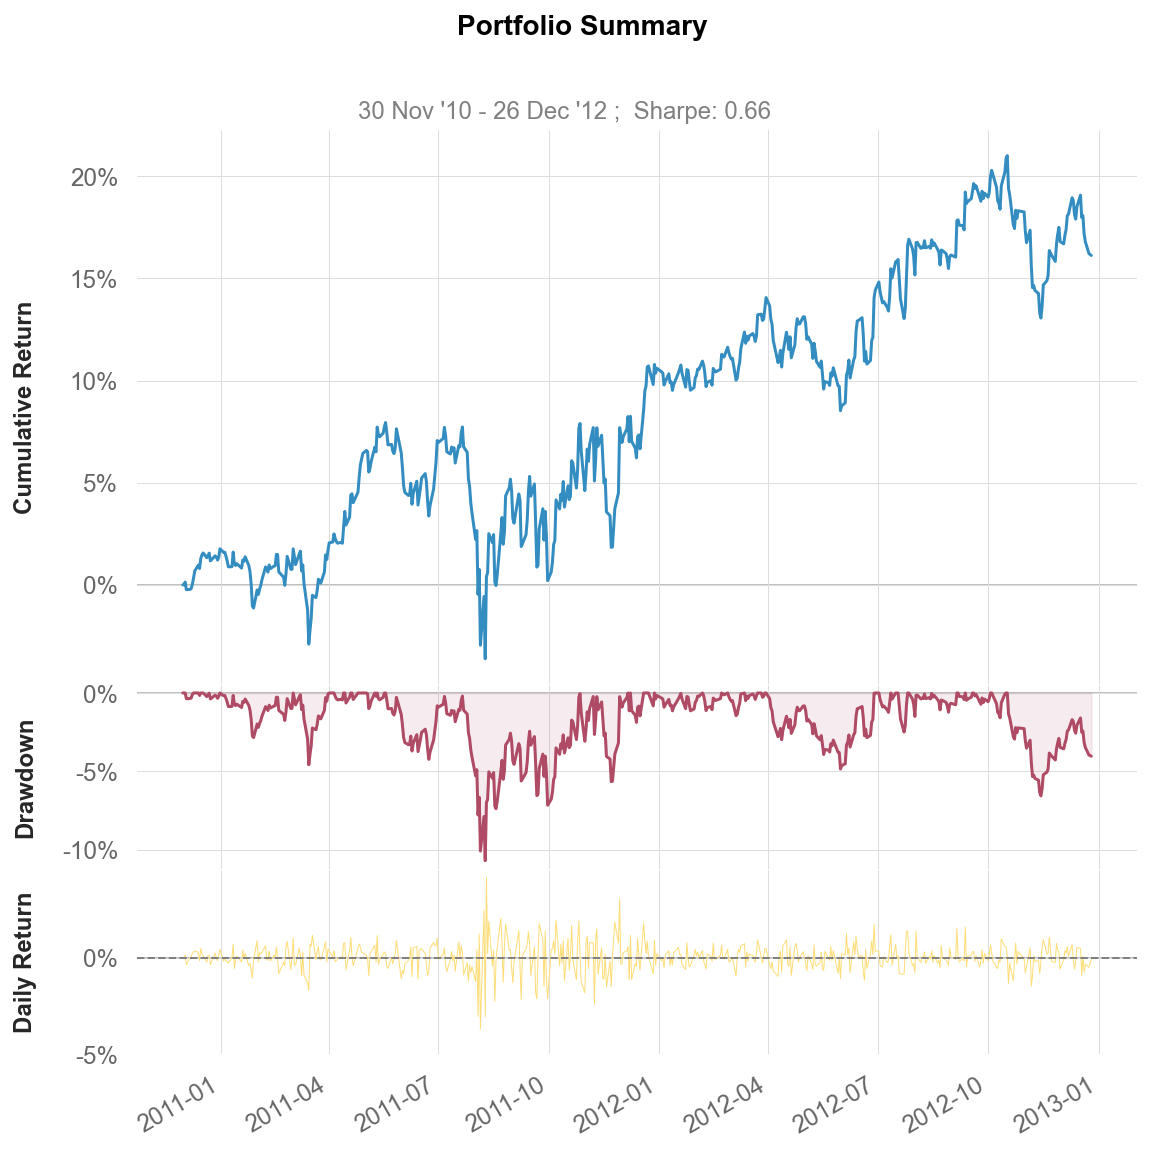

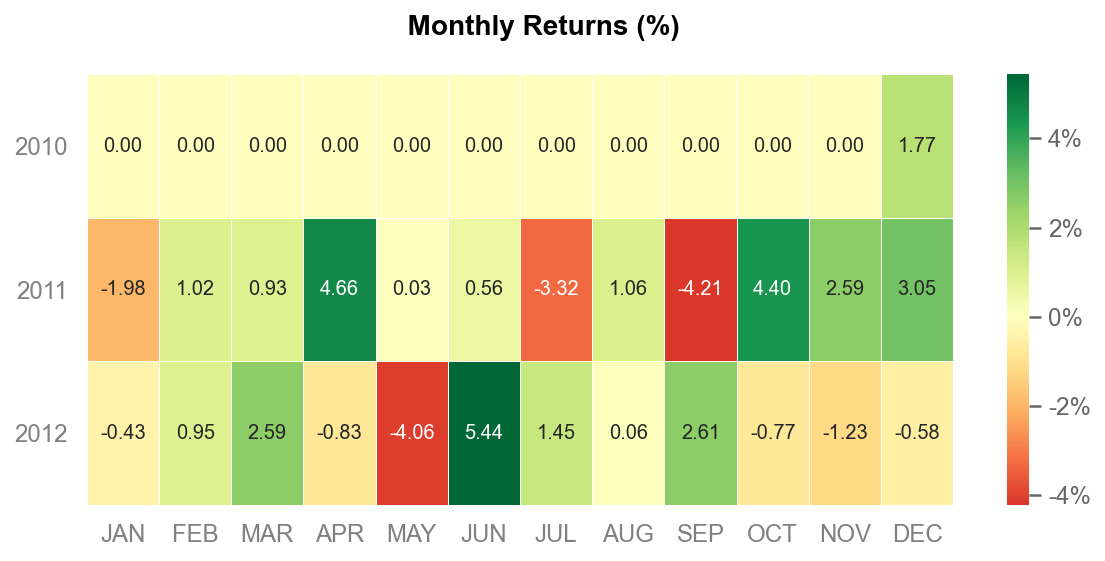

In [60]:
qs.reports.basic(ret_str['minvar_w_cons'])

## Backtest on Out-of-Sample Period 

The function is only different so that it also normalizes the rolling window we are fitting/testing on. This is important so we avoid lookahead bias in our test set.

In [61]:
def rolling_forest_test(data, predictors, target, window, params):
    # First we form the window
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

    # Auxiliary placeholders and reg. constant
    data = data.sort_values(by=["date", "permno"])
    predictions_df = pd.DataFrame(
        index=[pred_date], columns=np.sort(data.permno.unique())
    )
    scores = []
    missing_dates = []

    # The train / predict loop
    while pred_date <= data.date.max():
        # The loop will go through business days, not necessarily trading days (hence the try clause).
        try:
            # Picking the window of data to train and instantiating the predictor model
            mask = (data["date"] >= start_window) & (data["date"] <= end_window)
            train_window = data[mask].set_index("permno")
            train_window = process(train_window, list(predictors)[1:])
            linreg = RandomForestRegressor(**params)
            # Fitting the model on the training window
            fit_ = linreg.fit(train_window[list(predictors)], train_window[target])
            # Predicting for each permno on the next day after fit
            predi_df = (
                data[data["date"] == pred_date]
                .loc[:, list(predictors) + ["permno"]]
                .set_index("permno")
            )
            predi = fit_.predict(predi_df)
            # Storing in a useful format for backtest
            one_predi = (
                pd.DataFrame(data=predi, index=predi_df.index, columns=[pred_date])
            ).T
            predictions_df = pd.concat(
                [predictions_df, one_predi], axis=0, ignore_index=False
            )
            # R^2 to help visualize training performance
            score_r2 = linreg.score(
                predi_df[list(predictors)], data[data["date"] == pred_date][target]
            )
            scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
        # Update window position
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
    # Real returns we will need
    real_returns = data.pivot(index="date", columns="permno", values="fret1d")

    return real_returns, predictions_df[1:], missing_dates, scores 

In [62]:
params_forest = {
    "n_estimators": 30,
    "max_features": "sqrt",
    "max_depth": 5,
    "min_samples_leaf": 3,
    "min_samples_split": 4,
    "random_state": 1001,
}

regressors = test.columns[10:-1]
target = ["fret1d"]

(
    real_returns_forest_test,
    expected_returns_forest_test,
    missing_dates_forest_test,
    scores_forest_test,
) = rolling_forest_test(
    data=test, predictors=regressors, target=target, window=21, params=params_forest
)
real_returns_forest_test = real_returns_forest_test[
    real_returns_forest_test.index >= expected_returns_forest_test.index.min()
]

In [63]:
ret, expret = prepare_returns(real_returns_forest_test,expected_returns_forest_test,pd.datetime(2019, 12, 31),9)

In [64]:
dtall = pd.DataFrame(index=ret.index, data=ret.index, columns=["dates"])  #
dt_m = dtall.groupby(
    pd.Grouper(freq="B")
).last()  # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values  # But less realistic (daily trading)

# We need to also exclude from rebalance dates the business days that were actually not trading days
# #missing_dates = [i.to_datetime64() for i in missing_dates] # Uncomment if needed a convert!
dates_rebal = [x for x in dates_rebal if x not in missing_dates_forest_test]

# dates_ = [i.date() for i in dates_rebal]
real_returns_forest_test = real_returns_forest_test.loc[
    ~real_returns_forest_test.index.isin(missing_dates_forest_test)
]
expected_returns_forest_test = expected_returns_forest_test.loc[
    ~expected_returns_forest_test.index.isin(missing_dates_forest_test)
]

In [65]:
names = ret.columns
ptf = {}

# Initiate a dictionary of placeholders for the 3 strategies
ptf["msr_w_cons"] = pd.DataFrame(data=0.0, index=dates_rebal, columns=names)
ptf["minvar_w_cons"] = pd.DataFrame(data=0.0, index=dates_rebal, columns=names)

In [73]:
bnch_ret = (
    df_betas.groupby(["date"]).apply(weighted_avg, "ret", "weightage_pct") + 1
).cumprod()

bnch_ret = bnch_ret.loc[
    (bnch_ret.index >= ret_str.index.min()) & (bnch_ret.index <= ret_str.index.max())
]

In [67]:
def MSR(wvec,*args):
     cov = args[0]
     mu  = args[1]  # Max Sharp Ratio
     sr = mu@wvec/(wvec@cov@wvec)
     return -sr 

In [69]:
# Optimization rutine for the minimization problem
st_point_mvp = None
st_point_msr = None

for d in tqdm(dates_rebal):
    ret, expret = prepare_returns(
        real_returns_forest_test, expected_returns_forest_test, d, 3
    )

    # we prepare inputs:
    cov, mu, cons, bounds = configure_inputs_for_optimisation(
        test, ret, expret, d, 0.05, 21
    )

    # define starting point
    if st_point_msr is None:
        st_point_msr = np.ones(ret.columns.size) / ret.columns.size
    if st_point_mvp is None:
        st_point_mvp = np.ones(ret.columns.size) / ret.columns.size

    res = minimize(
        MVP,
        st_point_mvp,
        args=(cov, mu),
        constraints=cons,
        bounds=bounds,
        method="SLSQP",
        options={"ftol": 1e-16, "disp": False},
    )

    ptf["minvar_w_cons"].loc[d] = res.x

    # Set next starting point
    st_point_mvp = res.x
    
    res = minimize(
        MSR,
        st_point_mvp,
        args=(cov, mu),
        constraints=cons,
        bounds=bounds,
        method="SLSQP",
        options={"ftol": 1e-16, "disp": False},
    )

    ptf["msr_w_cons"].loc[d] = res.x
    
    st_point_msr = res.x


100%|██████████| 1557/1557 [2:35:04<00:00,  5.98s/it] 


In [70]:
ret, expret = prepare_returns(
    real_returns_forest_test, expected_returns_forest_test, pd.datetime(2019, 12, 31), 9
)
ret_str = clc_str_return(ptf["msr_w_cons"], ret, "msr_w_cons")
ret_str = ret_str.join(clc_str_return(ptf["minvar_w_cons"], ret, "minvar_w_cons"))


In [76]:
bnch_ret = (df_betas.groupby(['date']).apply(weighted_avg, 'ret', 'weightage_pct')+1).cumprod()
bnch_ret = bnch_ret.loc[(bnch_ret.index >= ret_str.index.min()) & (bnch_ret.index <= ret_str.index.max())]
bnch_ret = bnch_ret.loc[bnch_ret.index.isin(ret_str['msr_w_cons'].index)]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-10-14  2013-10-14
End Period                 2019-12-30  2019-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          113.21%     108.7%
CAGR﹪                     12.96%      12.57%

Sharpe                     1.18        1.14
Smart Sharpe               1.15        1.11
Sortino                    1.69        1.62
Smart Sortino              1.64        1.58
Sortino/√2                 1.19        1.15
Smart Sortino/√2           1.16        1.12
Omega                      1.23        1.23

Max Drawdown               -13.01%     -13.02%
Longest DD Days            411         412
Volatility (ann.)          10.87%      10.95%
R^2                        0.0         0.0
Calmar                     1.0         0.97
Skew                       -0.43       -0.45
Kurtosis                   3.08        3

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-01-22,2015-08-24,2016-03-08,411,-13.012742,-11.717653
2,2018-11-30,2018-12-21,2019-02-11,73,-11.144591,-8.422003
3,2018-01-26,2018-05-01,2018-09-11,228,-9.775000,-9.738654
4,2018-09-21,2018-10-10,2018-11-05,45,-5.432296,-4.872978
5,2016-07-22,2016-11-03,2017-01-24,186,-5.227327,-4.767044


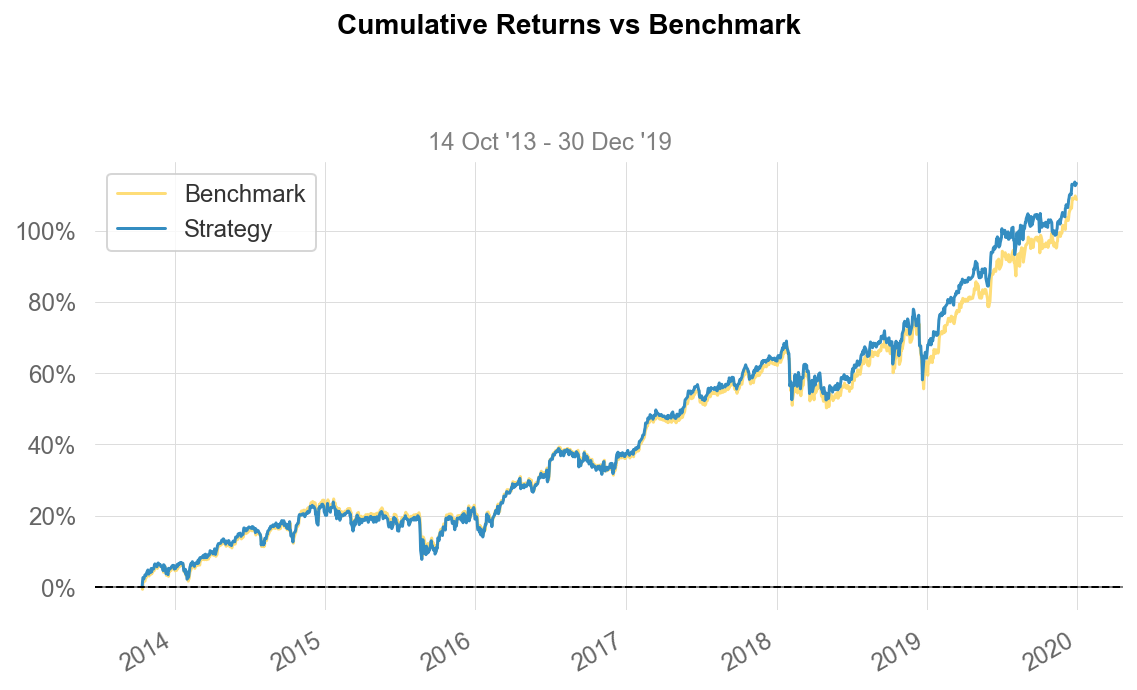

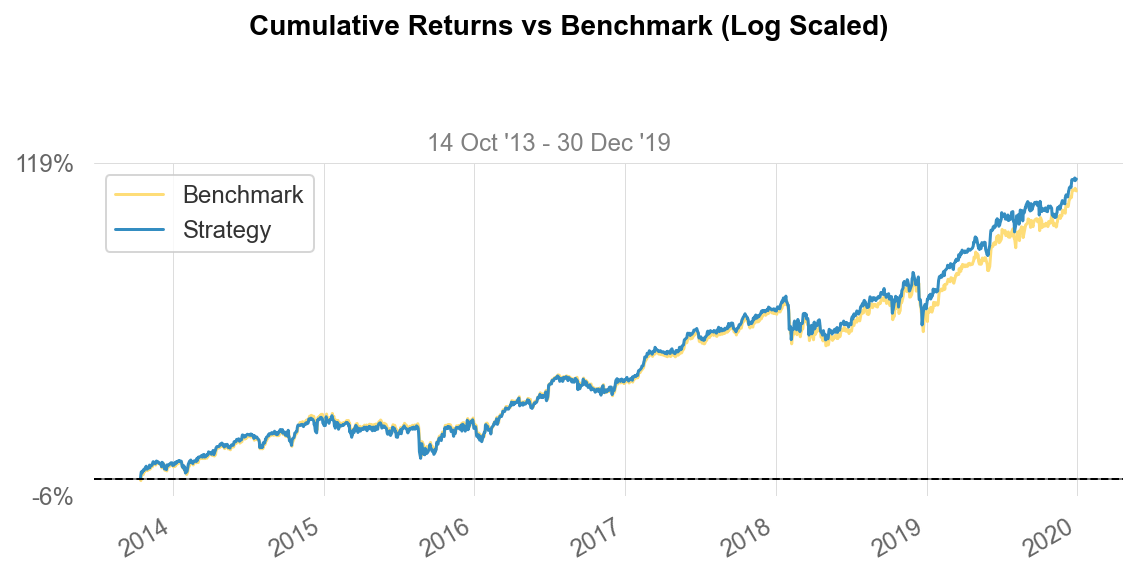

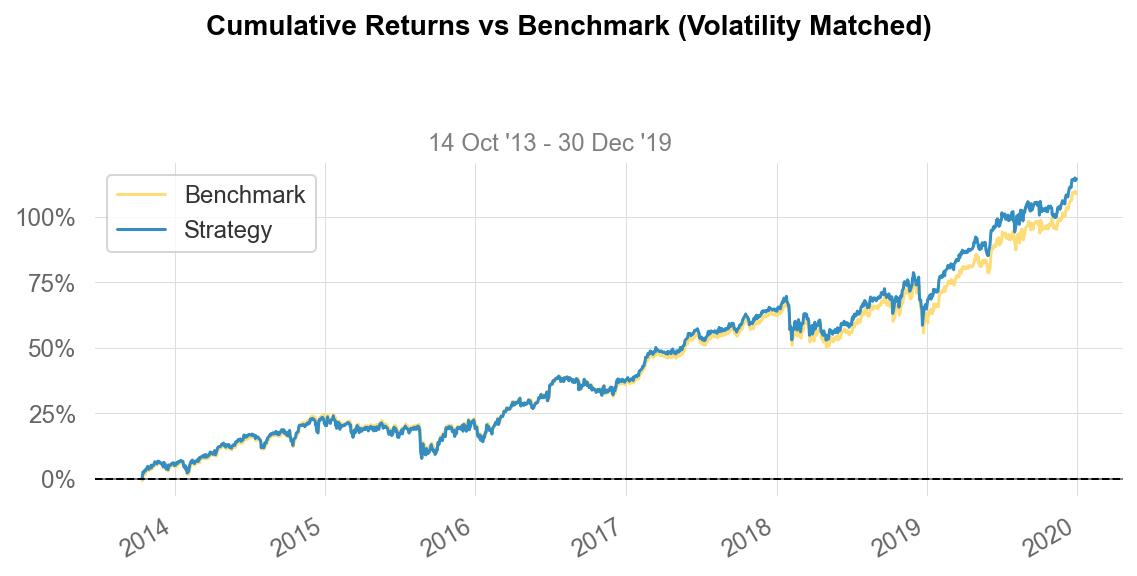

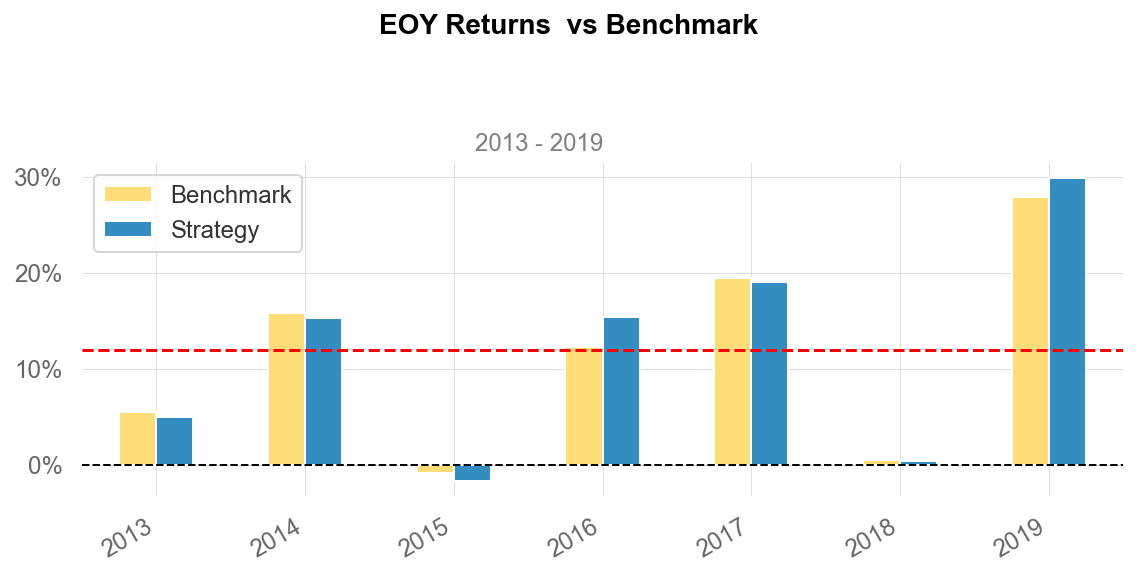

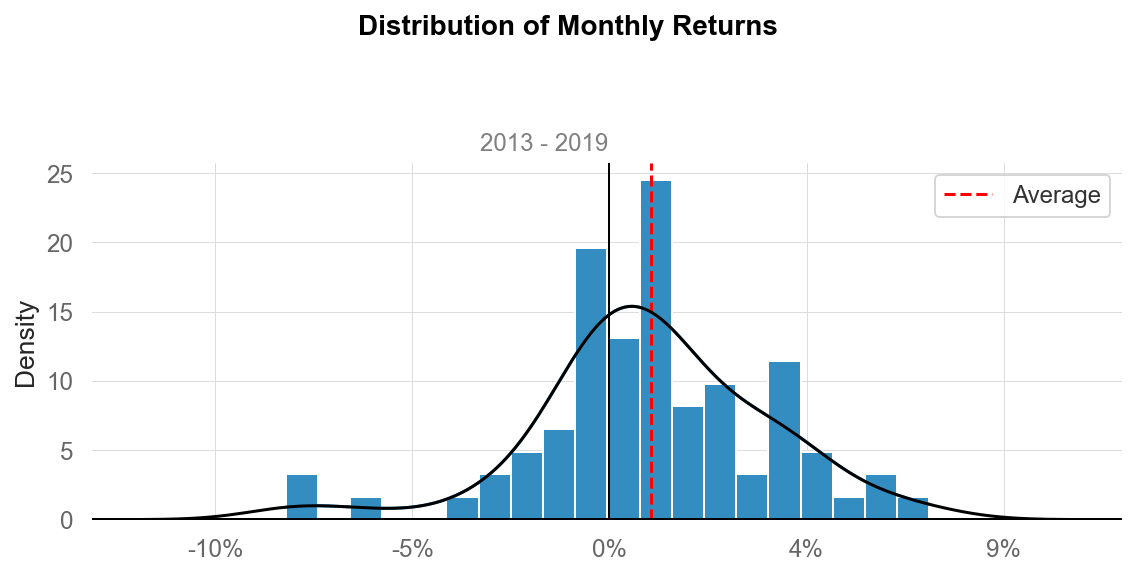

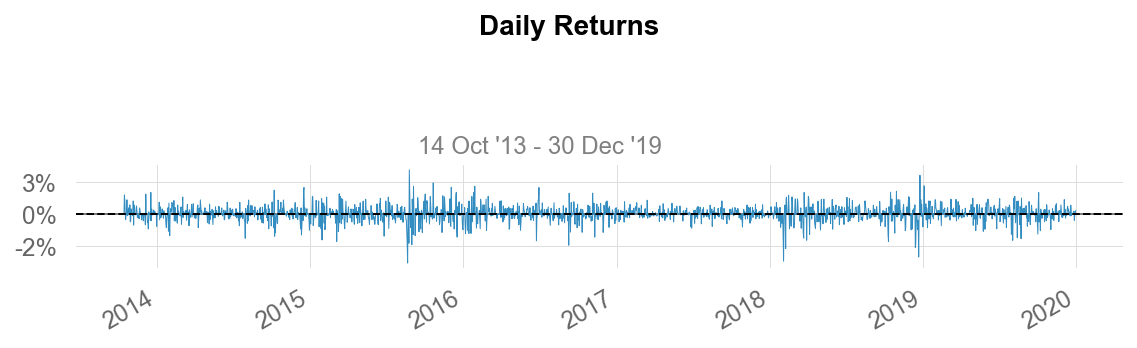

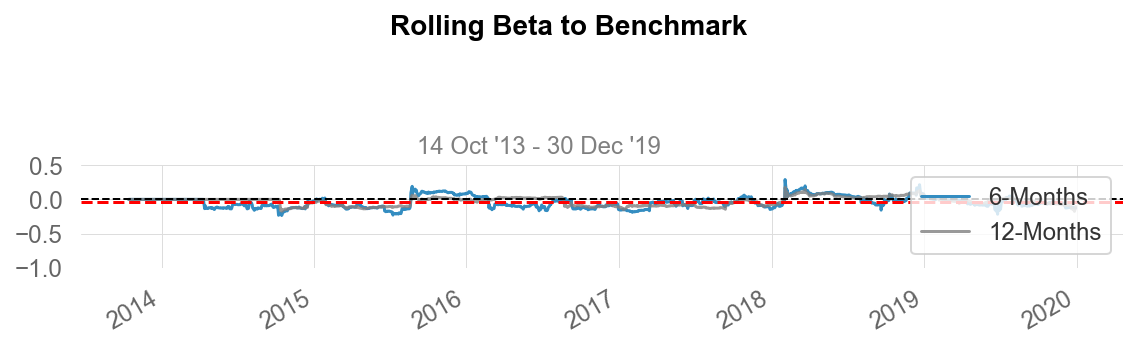

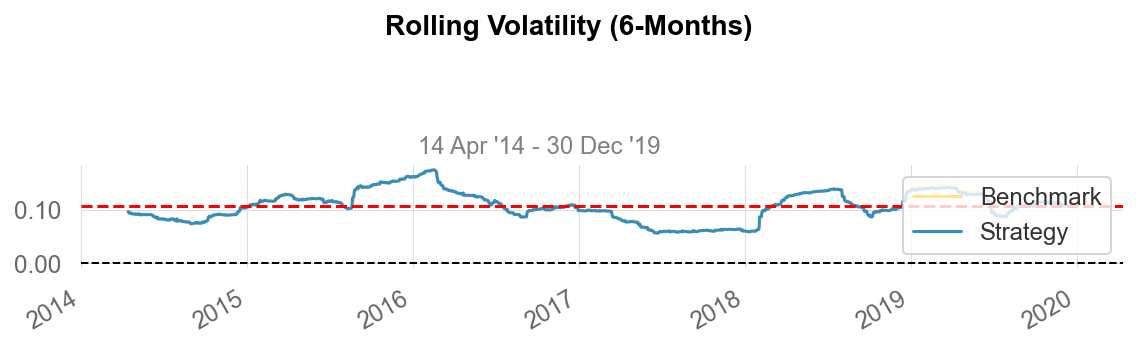

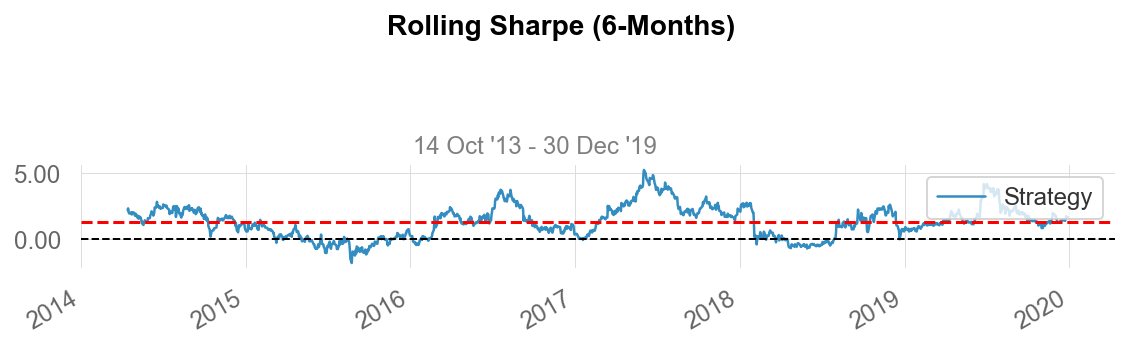

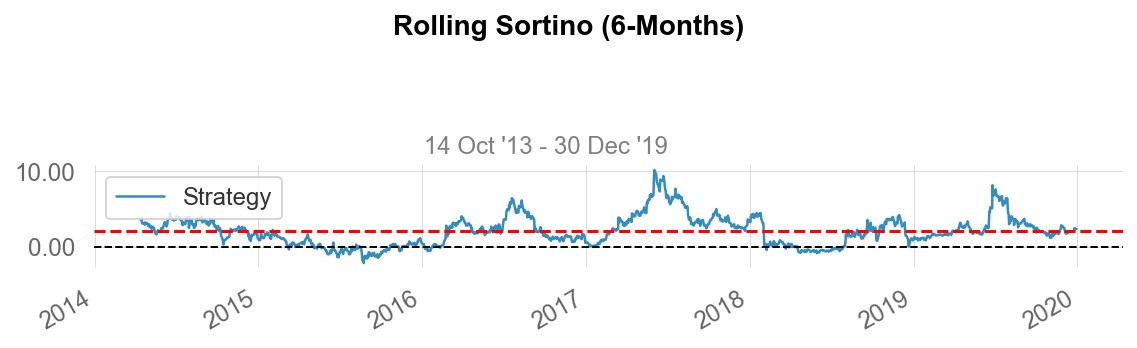

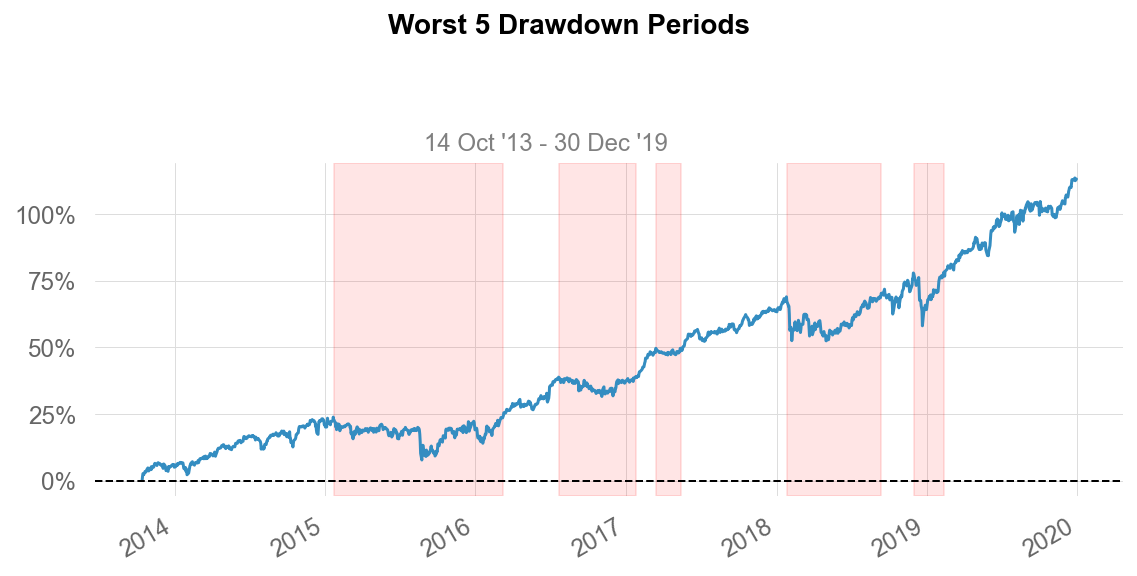

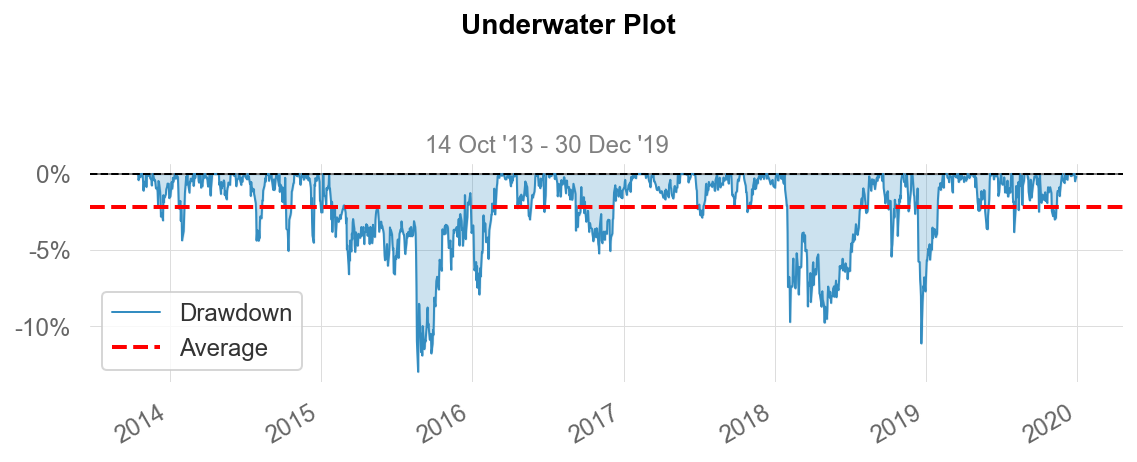

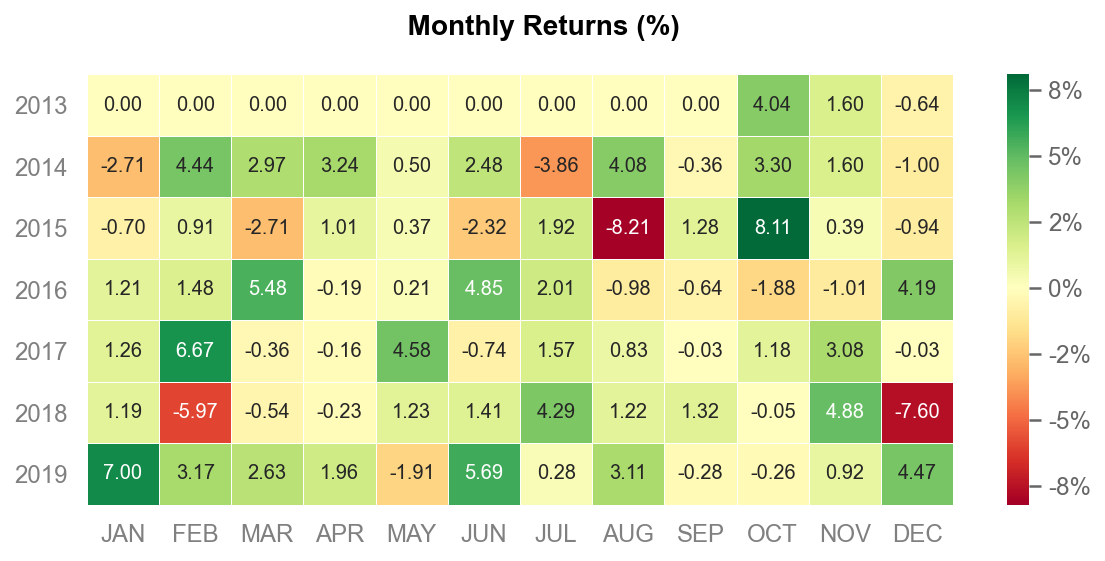

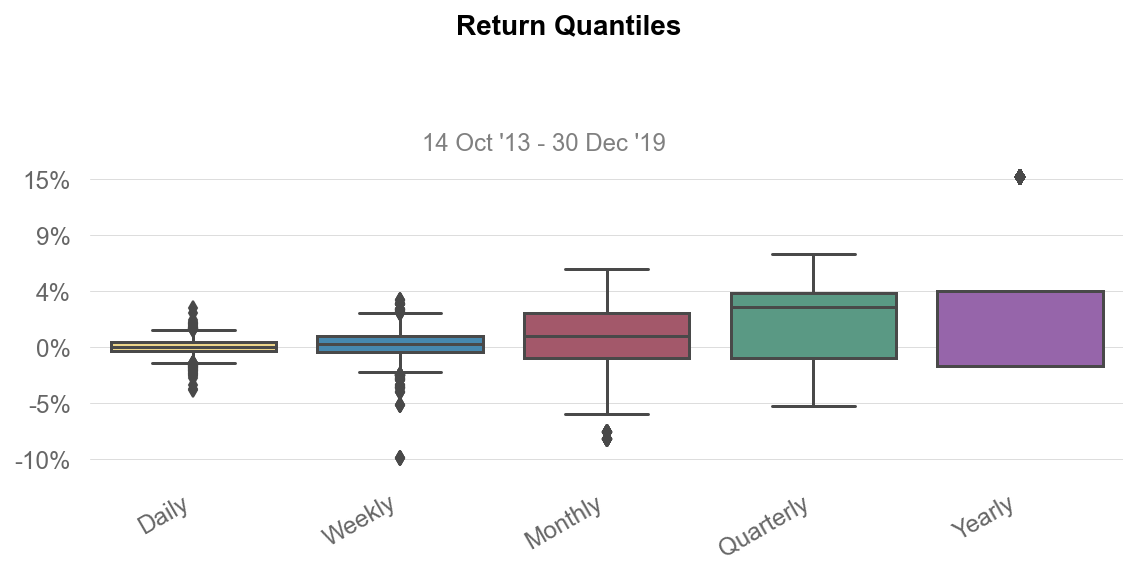

In [79]:
qs.reports.full(ret_str["msr_w_cons"], bnch_ret)

In [80]:
qs.reports.html(ret_str["msr_w_cons"], bnch_ret)